Current issues:
* Very dependent on the `shape` that defines the sparsity level of the cell-factor weights at each layer, and their inheritance between layers.

In [373]:
from functools import partial
import string

from jax.api import jit, grad, vmap
from jax.experimental import optimizers
from jax import random, value_and_grad
from jax.scipy.stats import norm, gamma, poisson
import jax.numpy as jnp
import jax.nn as jnn

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
from graphviz import Graph
from tqdm import tqdm
import time

from anndata import AnnData
from jax.config import config
config.update("jax_debug_nans", False)
config.update("jax_debug_infs", False)

def gaussian_sample(rng, mean, log_scale):
    scale = jnp.exp(log_scale)
    return mean + scale * random.normal(rng, mean.shape)

def gaussian_logpdf(x, mean, log_scale):
    scale = jnp.exp(log_scale)
    return jnp.sum(vmap(norm.logpdf)(x, mean * jnp.ones(x.shape), scale * jnp.ones(x.shape)))

def gamma_sample(rng, log_shape, log_scale):
    shape, scale = jnp.exp(log_shape), jnp.exp(log_scale)
    return scale * random.gamma(rng, shape)

def gamma_logpdf(x, shape, rate):
    scale = 1./rate
    return jnp.sum(vmap(gamma.logpdf)(x, shape * jnp.ones(x.shape), scale=scale * jnp.ones(x.shape)))

class scDPF(object):
    def __init__(self, adata, n_hfactors=10, n_factors=30, shape=0.1):
        self.n_factors = n_factors
        self.n_hfactors = n_hfactors
        self.shape = shape
        self.layer_names = ['factor', 'hfactor']
        self.layer_sizes = [n_factors, n_hfactors]
        self.load_adata(adata)
        self.n_cells, self.n_genes = adata.shape
        self.init_var_params()
        self.set_posterior_means()
        self.hpal = sns.color_palette('Set2', n_hfactors)
        self.graph = self.get_graph()

    def load_adata(self, adata):
        if not isinstance(adata, AnnData):
            raise TypeError("adata must be an instance of AnnData.")
        self.adata = adata
        self.adata.raw = self.adata
        self.X = jnp.array(self.adata.raw.X)

    def init_var_params(self):
        self.var_params = [
            jnp.array((-np.log(np.sum(self.X, axis=1)), jnp.ones((self.n_cells,)))),
            jnp.array(np.random.normal(5, 0.1, size=self.n_genes)),
            jnp.array((0*np.random.normal(5, 0.1, size=self.n_hfactors), jnp.ones((self.n_hfactors,)))),
            jnp.array((0*np.random.normal(5, 0.1, size=self.n_factors), jnp.ones((self.n_factors,)))),
            jnp.array((np.random.normal(1., 0.1, size=(self.n_cells, self.n_hfactors)), 
                        jnp.zeros((self.n_cells, self.n_hfactors)))),
            jnp.array(np.random.normal(1., 0.1, size=(self.n_hfactors, self.n_factors))),
            jnp.array((np.random.normal(0.5, 0.1, size=(self.n_cells, self.n_factors)), 
                        jnp.zeros((self.n_cells, self.n_factors)))),
            jnp.array(np.random.normal(0.5, 0.1, size=(self.n_factors, self.n_genes))) 
        ]

    def elbo(self, rng, indices, var_params):
        print("Computing ELBO...")
        # Single-sample Monte Carlo estimate of the variational lower bound.
        min_loc = jnp.log(1e-3)
        cell_scale_params = jnp.clip(var_params[0], a_min=min_loc)
#         gene_scale_params = jnp.clip(var_params[1], a_min=min_loc)
        unconst_gene_scales = jnp.clip(var_params[1], a_min=min_loc)
#         hfactor_scale_params = jnp.clip(var_params[2], a_min=min_loc)
#         factor_scale_params = jnp.clip(var_params[3], a_min=min_loc)
        hz_params = jnp.clip(var_params[4], a_min=min_loc)
#         hW_params = jnp.clip(var_params[5], a_min=min_loc)
        unconst_hW = jnp.clip(var_params[5], a_min=min_loc)
        z_params = jnp.clip(var_params[6], a_min=min_loc)
#         W_params = jnp.clip(var_params[7], a_min=min_loc)
        unconst_W = jnp.clip(var_params[7], a_min=min_loc)
    
        # Sample from variational distribution
        log_cell_scales = gaussian_sample(rng, cell_scale_params[0][indices], cell_scale_params[1][indices])
        cell_scales = jnp.exp(log_cell_scales)
#         log_gene_scales = gaussian_sample(rng, gene_scale_params[0], gene_scale_params[1])
#         gene_scales = jnp.exp(log_gene_scales)
        gene_scales = jnn.softplus(unconst_gene_scales)
        
#         log_hfactor_scales = gaussian_sample(rng, hfactor_scale_params[0], hfactor_scale_params[1])
#         hfactor_scales = jnp.exp(log_hfactor_scales)
#         log_factor_scales = gaussian_sample(rng, factor_scale_params[0], factor_scale_params[1])
#         factor_scales = jnp.exp(log_factor_scales)
    
        log_hz = gaussian_sample(rng, hz_params[0][indices], hz_params[1][indices])
        hz = jnp.exp(log_hz)
#         log_hW = gaussian_sample(rng, hW_params[0], hW_params[1])
#         hW = jnp.exp(log_hW)
        hW = jnn.softplus(unconst_hW)
        mean_top = jnp.matmul(hz, hW)
        
        log_z = gaussian_sample(rng, z_params[0][indices], z_params[1][indices])
        z = jnp.exp(log_z)
#         log_W = gaussian_sample(rng, W_params[0], W_params[1])
#         W = jnp.exp(log_W)
        W = jnn.softplus(unconst_W)
        mean_bottom = jnp.matmul(z, W)

        # Compute log likelihood
        ll = jnp.sum(vmap(poisson.logpmf)(self.X[indices], mean_bottom))

        # Compute KL divergence
        kl = 0.
        kl += gamma_logpdf(gene_scales, 1., 1.) #-\
#                 gaussian_logpdf(log_gene_scales, gene_scale_params[0], gene_scale_params[1])    
        
#         kl += gamma_logpdf(hfactor_scales, .1, 1.) -\
#                 gaussian_logpdf(log_hfactor_scales, hfactor_scale_params[0], hfactor_scale_params[1])
        
#         kl += gamma_logpdf(factor_scales, 1., 1.) -\
#                 gaussian_logpdf(log_factor_scales, factor_scale_params[0], factor_scale_params[1])
        
        kl += gamma_logpdf(hW, .3, .1) #-\
#                 gaussian_logpdf(log_hW, hW_params[0], hW_params[1])
        
        kl += gamma_logpdf(W, .3, .1 * gene_scales.reshape(1,-1)) #-\
#                 gaussian_logpdf(log_W, W_params[0], W_params[1])
        
        kl *= indices.shape[0] / self.X.shape[0] # scale by minibatch size
        
        kl += gamma_logpdf(cell_scales, 1., 1.) -\
                gaussian_logpdf(log_cell_scales, cell_scale_params[0][indices], cell_scale_params[1][indices])
        
        kl += gamma_logpdf(hz, self.shape, self.shape) -\
                gaussian_logpdf(log_hz, hz_params[0][indices], hz_params[1][indices])
        
        kl += gamma_logpdf(z, self.shape, cell_scales.reshape(-1,1) * self.shape / mean_top) -\
                gaussian_logpdf(log_z, z_params[0][indices], z_params[1][indices])

        return ll + kl

    def batch_elbo(self, rng, indices, var_params, num_samples):
        # Average over a batch of random samples.
        rngs = random.split(rng, num_samples)
        vectorized_elbo = vmap(self.elbo, in_axes=(0, None, None))
        return jnp.mean(vectorized_elbo(rngs, indices, var_params))

    def optimize(self, n_epochs=1000, batch_size=1, step_size=0.1, num_samples=1, init=False):
        if init:
            self.init_var_params()
        init_params = self.var_params
        opt_init, opt_update, get_params = optimizers.adam(step_size=step_size)

        def objective(indices, var_params, t):
            rng = random.PRNGKey(t)
            return -self.batch_elbo(rng, indices, var_params, num_samples) # minimize -ELBO

        loss_grad = jit(value_and_grad(objective, argnums=1))

        def update(indices, i, opt_state):
            params = get_params(opt_state)
            value, gradient = loss_grad(indices, params, i)
            return value, opt_update(i, gradient, opt_state)

        num_complete_batches, leftover = divmod(self.n_cells, batch_size)
        num_batches = num_complete_batches + bool(leftover)
        def data_stream():
            rng = np.random.RandomState(0)
            while True:
              perm = rng.permutation(self.n_cells)
              for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield jnp.array(batch_idx)
        batches = data_stream()

        opt_state = opt_init(init_params)
        losses = []
        print("\nStarting training...")
        t = 0
        for epoch in tqdm(range(n_epochs)):
            epoch_losses = []
            start_time = time.time()
            for it in range(num_batches):
                loss, opt_state = update(next(batches), t, opt_state)
                epoch_losses.append(loss)
                t += 1
            losses.append(np.mean(epoch_losses))
            epoch_time = time.time() - start_time
            print("Epoch {} in {:0.2f} sec || Loss {:0.5f}".format(epoch, epoch_time, losses[-1]))

        params = get_params(opt_state)
        self.var_params = params
        self.set_posterior_means()
        self.annotate_adata()
        return losses

    def get_dimensions(self, threshold=0.1):
        # Look at the scale of the factors and get the ones which are actually used
        return dict(hfactor=np.where(self.pmeans['hfactor_scale'] > threshold)[0],
                    factor=np.where(self.pmeans['factor_scale'] > threshold)[0])

    def set_posterior_means(self):
        cell_scale_params = self.var_params[0]
        gene_scale_params = self.var_params[1]
        hfactor_scale_params = self.var_params[2]
        factor_scale_params = self.var_params[3]
        hz_params = self.var_params[4]
        hW_params = self.var_params[5]
        z_params = self.var_params[6]
        W_params = self.var_params[7]

        self.pmeans = {
            'cell_scale': np.exp(cell_scale_params[0]),
            'gene_scale': np.array(jnn.softplus(gene_scale_params)), #np.exp(gene_scale_params[0]),
            'hfactor_scale': np.exp(hfactor_scale_params[0]),
            'factor_scale': np.exp(factor_scale_params[0]),
            'hz': np.exp(hz_params[0]),
            'hW': np.array(jnn.softplus(hW_params)),#np.exp(hW_params[0]),
            'z': np.exp(z_params[0]),
            'W': np.array(jnn.softplus(W_params))#np.exp(W_params[0]),
        }

    def annotate_adata(self):
        self.adata.obsm['X_hfactors'] = self.pmeans['hz'] * self.pmeans['cell_scale'].reshape(-1,1)
        self.adata.obsm['X_factors'] = self.pmeans['z'] * self.pmeans['cell_scale'].reshape(-1,1)
        self.adata.obs['X_hfactor'] = np.argmax(self.adata.obsm['X_hfactors'], axis=1).astype(str)
        self.adata.obs['X_factor'] = np.argmax(self.adata.obsm['X_factors'], axis=1).astype(str)
        print('Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs')

    def plot_ard(self, layer_idx=0):
        plt.bar(np.arange(self.layer_sizes[layer_idx]), self.pmeans[f'{self.layer_names[layer_idx]}_scale'])
        plt.ylabel('Contribution')
        plt.xlabel('Factor')
        plt.xticks(np.arange(self.layer_sizes[layer_idx]))
        plt.title(f'Layer {layer_idx}')
        plt.show()

    def get_rankings(self, layer_idx=0):
        term_names = self.adata.var_names
        term_scores = self.pmeans['W']/self.pmeans['gene_scale']
        if layer_idx == 1:
            term_names = np.arange(self.n_factors).astype(str)
            term_scores = self.pmeans['hW']

        top_terms = []
        for k in range(self.layer_sizes[layer_idx]):
            top_terms_idx = (term_scores[k, :]).argsort()[::-1]
            top_terms_list = [term_names[i] for i in top_terms_idx]
            top_terms.append(top_terms_list)
        return top_terms

    def get_enrichments(self, libs=['KEGG_2019_Human']):
        enrichments = []
        gene_rankings = self.get_rankings(layer_idx=0)
        for rank in tqdm(gene_rankings):
            enr = gp.enrichr(gene_list=rank,
                         gene_sets=libs,
                         organism='Human',
                         outdir='test/enrichr',
                         cutoff=0.05
                        )
            enrichments.append(enr)
        return enrichments

    def get_graph(self, enrichments=None, top=10, hfactor_list=None, factor_list=None, ard_filter=[0., 0.]):
        if hfactor_list is None:
            hfactor_list = np.arange(self.n_hfactors)
            if ard_filter:
                hfactor_list = np.where(self.pmeans[f'{self.layer_names[1]}_scale']  > ard_filter[0])[0]
        if factor_list is None:
            factor_list = np.arange(self.n_factors)
            if ard_filter:
                factor_list = np.where(self.pmeans[f'{self.layer_names[0]}_scale']  > ard_filter[1])[0]

        gene_rankings = self.get_rankings()
        normalized_htopic_weights = self.pmeans['hW']/np.sum(self.pmeans['hW'][:, factor_list], axis=1).reshape(-1,1)
        normalized_hfactor_scales = self.pmeans['hfactor_scale']/np.sum(self.pmeans['hfactor_scale'][hfactor_list])
        normalized_factor_scales = self.pmeans['factor_scale']/np.sum(self.pmeans['factor_scale'][factor_list])
        g = Graph()
        for htopic in hfactor_list:
            g.node('ht' + str(htopic), label=str(htopic),
                    fillcolor=matplotlib.colors.to_hex(self.hpal[htopic]), ordering='out', style='filled')
        for topic in factor_list:
            if enrichments is not None:
                tlab = str(topic) + '\n\n' + "\n".join([enrichments[topic].results['Term'].values[i] + f" ({enrichments[topic].results['Adjusted P-value'][i]:.3f})" for i in range(top)])
                # tlab = enrichments[topic].results['Term'].values[0] + f" ({enrichments[topic].results['Adjusted P-value'][0]:.3f})" + '\n\n' + tlab
            else:
                tlab = str(topic) + '\n\n' + "\n".join(gene_rankings[topic][:top])
            g.node('t' + str(topic), label=tlab, fontsize="11",
                    fillcolor=matplotlib.colors.to_hex((64/255, 224/255, 208/255, normalized_factor_scales[topic]), keep_alpha=True), ordering='in')
        for htopic in hfactor_list:
            for topic in factor_list:
                g.edge('ht' + str(htopic), 't'+str(topic), penwidth=str(normalized_htopic_weights[htopic,topic]*2), color=matplotlib.colors.to_hex(self.hpal[htopic]))
        return g

In [296]:
normalized_htopic_weights = scdpf.pmeans['hW']/np.sum(scdpf.pmeans['hW'], axis=1).reshape(-1,1)

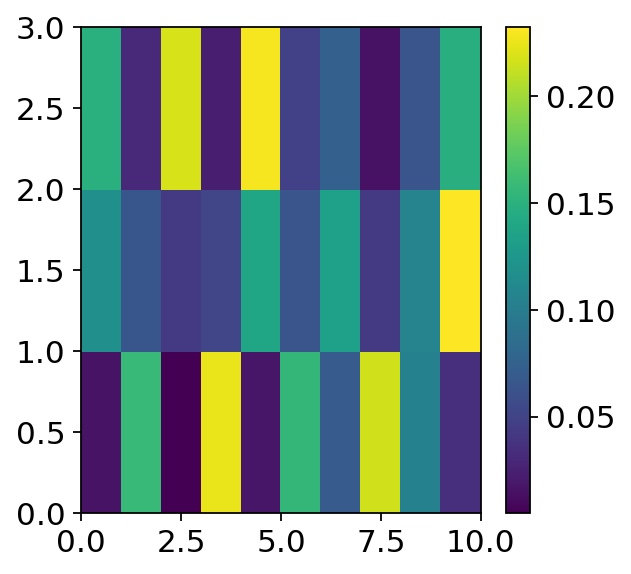

In [298]:
plt.pcolormesh(normalized_htopic_weights);plt.colorbar()

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.18.5 scipy==1.4.1 pandas==1.3.2 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.9.6 pynndescent==0.5.4
... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad
filtered out 19024 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:02)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`

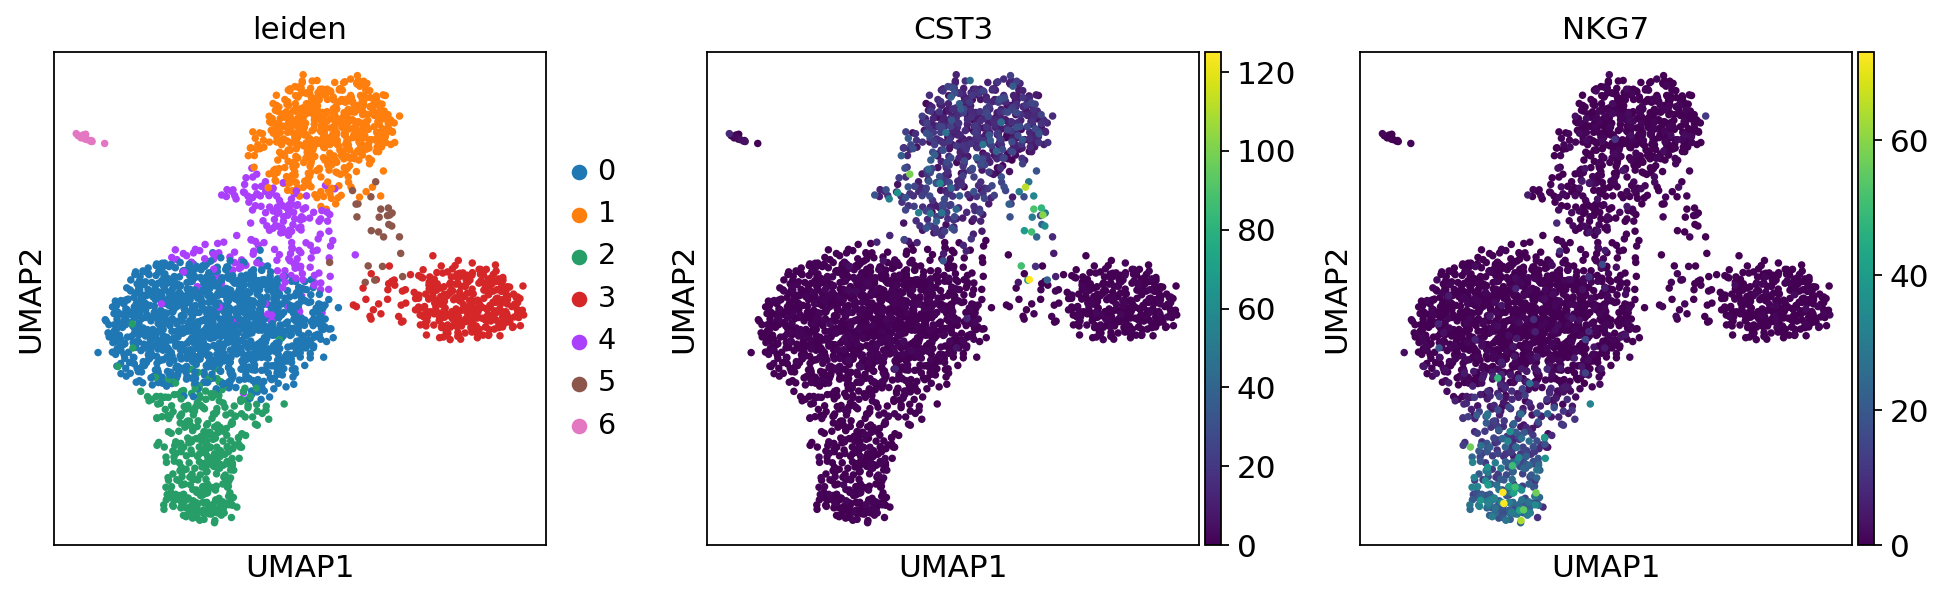

In [5]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata.raw = adata
raw_adata = adata.raw
raw_adata = raw_adata.to_adata()
raw_adata.X = raw_adata.X.toarray()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=1000)
raw_adata = raw_adata[:, adata.var.highly_variable]
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [6]:
raw_adata.obsm['X_umap'] = adata.obsm['X_umap']
raw_adata.obs['leiden'] = adata.obs['leiden']

In [7]:
raw_adata.shape

(2638, 1000)

In [8]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [375]:
scdpf = scDPF(raw_adata, n_factors=10, n_hfactors=3, shape=10.)
for i in range(15):
    if i == 0:
        elbos = scdpf.optimize(n_epochs=10, batch_size=100, step_size=.001, num_samples=1)
    else:
        elbos = scdpf.optimize(n_epochs=100, batch_size=100, step_size=.001, num_samples=1)

  0%|          | 0/10 [00:00<?, ?it/s]


Starting training...
Computing ELBO...
Computing ELBO...


 10%|█         | 1/10 [00:03<00:31,  3.50s/it]

Epoch 0 in 3.50 sec || Loss 2640718.00000


 20%|██        | 2/10 [00:03<00:20,  2.54s/it]

Epoch 1 in 0.32 sec || Loss 2589249.50000


 30%|███       | 3/10 [00:04<00:13,  1.87s/it]

Epoch 2 in 0.31 sec || Loss 2499653.00000


 40%|████      | 4/10 [00:04<00:08,  1.40s/it]

Epoch 3 in 0.30 sec || Loss 2451659.25000


 50%|█████     | 5/10 [00:04<00:05,  1.07s/it]

Epoch 4 in 0.30 sec || Loss 2390386.25000


 60%|██████    | 6/10 [00:05<00:03,  1.19it/s]

Epoch 5 in 0.30 sec || Loss 2330304.50000


 70%|███████   | 7/10 [00:05<00:02,  1.47it/s]

Epoch 6 in 0.30 sec || Loss 2306619.50000


 80%|████████  | 8/10 [00:05<00:01,  1.77it/s]

Epoch 7 in 0.30 sec || Loss 2231511.75000


 90%|█████████ | 9/10 [00:05<00:00,  2.06it/s]

Epoch 8 in 0.30 sec || Loss 2192238.50000


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 9 in 0.30 sec || Loss 2145398.75000
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:03<05:39,  3.43s/it]

Epoch 0 in 3.43 sec || Loss 2138388.00000


  2%|▏         | 2/100 [00:03<04:04,  2.50s/it]

Epoch 1 in 0.32 sec || Loss 2088828.12500


  3%|▎         | 3/100 [00:04<02:58,  1.84s/it]

Epoch 2 in 0.30 sec || Loss 2009610.37500


  4%|▍         | 4/100 [00:04<02:12,  1.38s/it]

Epoch 3 in 0.30 sec || Loss 1964606.62500


  5%|▌         | 5/100 [00:04<01:40,  1.05s/it]

Epoch 4 in 0.30 sec || Loss 1910231.75000


  6%|▌         | 6/100 [00:04<01:17,  1.21it/s]

Epoch 5 in 0.30 sec || Loss 1858307.37500


  7%|▋         | 7/100 [00:05<01:02,  1.49it/s]

Epoch 6 in 0.30 sec || Loss 1834811.37500


  8%|▊         | 8/100 [00:05<00:51,  1.79it/s]

Epoch 7 in 0.30 sec || Loss 1771939.12500


  9%|▉         | 9/100 [00:05<00:43,  2.07it/s]

Epoch 8 in 0.30 sec || Loss 1737416.87500


 10%|█         | 10/100 [00:06<00:38,  2.32it/s]

Epoch 9 in 0.31 sec || Loss 1703313.75000


 11%|█         | 11/100 [00:06<00:35,  2.53it/s]

Epoch 10 in 0.31 sec || Loss 1651521.50000


 12%|█▏        | 12/100 [00:06<00:32,  2.70it/s]

Epoch 11 in 0.31 sec || Loss 1657262.37500


 13%|█▎        | 13/100 [00:07<00:30,  2.82it/s]

Epoch 12 in 0.32 sec || Loss 1601012.25000


 14%|█▍        | 14/100 [00:07<00:29,  2.93it/s]

Epoch 13 in 0.31 sec || Loss 1574003.37500


 15%|█▌        | 15/100 [00:07<00:28,  3.01it/s]

Epoch 14 in 0.31 sec || Loss 1555363.12500


 16%|█▌        | 16/100 [00:08<00:27,  3.06it/s]

Epoch 15 in 0.31 sec || Loss 1520781.12500


 17%|█▋        | 17/100 [00:08<00:26,  3.11it/s]

Epoch 16 in 0.31 sec || Loss 1469388.25000


 18%|█▊        | 18/100 [00:08<00:26,  3.14it/s]

Epoch 17 in 0.31 sec || Loss 1435276.75000


 19%|█▉        | 19/100 [00:08<00:25,  3.16it/s]

Epoch 18 in 0.31 sec || Loss 1440383.00000


 20%|██        | 20/100 [00:09<00:25,  3.18it/s]

Epoch 19 in 0.31 sec || Loss 1395085.50000


 21%|██        | 21/100 [00:09<00:24,  3.18it/s]

Epoch 20 in 0.31 sec || Loss 1368997.75000


 22%|██▏       | 22/100 [00:09<00:24,  3.19it/s]

Epoch 21 in 0.31 sec || Loss 1316555.25000


 23%|██▎       | 23/100 [00:10<00:24,  3.20it/s]

Epoch 22 in 0.31 sec || Loss 1307520.62500


 24%|██▍       | 24/100 [00:10<00:23,  3.19it/s]

Epoch 23 in 0.31 sec || Loss 1279248.00000


 25%|██▌       | 25/100 [00:10<00:23,  3.20it/s]

Epoch 24 in 0.31 sec || Loss 1255482.87500


 26%|██▌       | 26/100 [00:11<00:23,  3.20it/s]

Epoch 25 in 0.31 sec || Loss 1243729.12500


 27%|██▋       | 27/100 [00:11<00:22,  3.19it/s]

Epoch 26 in 0.31 sec || Loss 1200043.75000


 28%|██▊       | 28/100 [00:11<00:22,  3.19it/s]

Epoch 27 in 0.31 sec || Loss 1162398.87500


 29%|██▉       | 29/100 [00:12<00:22,  3.19it/s]

Epoch 28 in 0.31 sec || Loss 1155465.50000


 30%|███       | 30/100 [00:12<00:21,  3.21it/s]

Epoch 29 in 0.31 sec || Loss 1143983.75000


 31%|███       | 31/100 [00:12<00:21,  3.22it/s]

Epoch 30 in 0.31 sec || Loss 1110567.12500


 32%|███▏      | 32/100 [00:13<00:21,  3.20it/s]

Epoch 31 in 0.31 sec || Loss 1083713.12500


 33%|███▎      | 33/100 [00:13<00:21,  3.14it/s]

Epoch 32 in 0.33 sec || Loss 1070932.75000


 34%|███▍      | 34/100 [00:13<00:21,  3.13it/s]

Epoch 33 in 0.32 sec || Loss 1050413.25000


 35%|███▌      | 35/100 [00:14<00:20,  3.15it/s]

Epoch 34 in 0.31 sec || Loss 1041452.06250


 36%|███▌      | 36/100 [00:14<00:20,  3.16it/s]

Epoch 35 in 0.31 sec || Loss 999317.06250


 37%|███▋      | 37/100 [00:14<00:19,  3.17it/s]

Epoch 36 in 0.31 sec || Loss 988240.00000


 38%|███▊      | 38/100 [00:14<00:19,  3.18it/s]

Epoch 37 in 0.31 sec || Loss 965925.31250


 39%|███▉      | 39/100 [00:15<00:19,  3.19it/s]

Epoch 38 in 0.31 sec || Loss 959534.87500


 40%|████      | 40/100 [00:15<00:18,  3.20it/s]

Epoch 39 in 0.31 sec || Loss 938652.43750


 41%|████      | 41/100 [00:15<00:18,  3.21it/s]

Epoch 40 in 0.31 sec || Loss 925556.25000


 42%|████▏     | 42/100 [00:16<00:18,  3.21it/s]

Epoch 41 in 0.31 sec || Loss 901782.25000


 43%|████▎     | 43/100 [00:16<00:17,  3.21it/s]

Epoch 42 in 0.31 sec || Loss 878467.93750


 44%|████▍     | 44/100 [00:16<00:17,  3.21it/s]

Epoch 43 in 0.31 sec || Loss 879141.12500


 45%|████▌     | 45/100 [00:17<00:17,  3.21it/s]

Epoch 44 in 0.31 sec || Loss 861050.37500


 46%|████▌     | 46/100 [00:17<00:16,  3.20it/s]

Epoch 45 in 0.31 sec || Loss 836676.25000


 47%|████▋     | 47/100 [00:17<00:16,  3.20it/s]

Epoch 46 in 0.31 sec || Loss 822203.12500


 48%|████▊     | 48/100 [00:18<00:16,  3.21it/s]

Epoch 47 in 0.31 sec || Loss 823061.87500


 49%|████▉     | 49/100 [00:18<00:15,  3.20it/s]

Epoch 48 in 0.31 sec || Loss 790968.87500


 50%|█████     | 50/100 [00:18<00:15,  3.18it/s]

Epoch 49 in 0.32 sec || Loss 778568.37500


 51%|█████     | 51/100 [00:19<00:15,  3.14it/s]

Epoch 50 in 0.33 sec || Loss 767054.81250


 52%|█████▏    | 52/100 [00:19<00:15,  3.16it/s]

Epoch 51 in 0.31 sec || Loss 750897.50000


 53%|█████▎    | 53/100 [00:19<00:14,  3.16it/s]

Epoch 52 in 0.31 sec || Loss 751724.25000


 54%|█████▍    | 54/100 [00:19<00:14,  3.17it/s]

Epoch 53 in 0.31 sec || Loss 734800.81250


 55%|█████▌    | 55/100 [00:20<00:14,  3.19it/s]

Epoch 54 in 0.31 sec || Loss 712993.12500


 56%|█████▌    | 56/100 [00:20<00:13,  3.21it/s]

Epoch 55 in 0.31 sec || Loss 700062.06250


 57%|█████▋    | 57/100 [00:20<00:13,  3.22it/s]

Epoch 56 in 0.31 sec || Loss 697836.43750


 58%|█████▊    | 58/100 [00:21<00:13,  3.19it/s]

Epoch 57 in 0.32 sec || Loss 677679.06250


 59%|█████▉    | 59/100 [00:21<00:12,  3.15it/s]

Epoch 58 in 0.33 sec || Loss 680465.87500


 60%|██████    | 60/100 [00:21<00:12,  3.12it/s]

Epoch 59 in 0.33 sec || Loss 663589.62500


 61%|██████    | 61/100 [00:22<00:12,  3.11it/s]

Epoch 60 in 0.32 sec || Loss 645826.31250


 62%|██████▏   | 62/100 [00:22<00:12,  3.10it/s]

Epoch 61 in 0.32 sec || Loss 631413.56250


 63%|██████▎   | 63/100 [00:22<00:12,  3.08it/s]

Epoch 62 in 0.33 sec || Loss 632864.93750


 64%|██████▍   | 64/100 [00:23<00:11,  3.11it/s]

Epoch 63 in 0.31 sec || Loss 620683.93750


 65%|██████▌   | 65/100 [00:23<00:11,  3.14it/s]

Epoch 64 in 0.31 sec || Loss 616354.50000


 66%|██████▌   | 66/100 [00:23<00:10,  3.19it/s]

Epoch 65 in 0.30 sec || Loss 595522.56250


 67%|██████▋   | 67/100 [00:24<00:10,  3.20it/s]

Epoch 66 in 0.31 sec || Loss 591112.81250


 68%|██████▊   | 68/100 [00:24<00:10,  3.19it/s]

Epoch 67 in 0.31 sec || Loss 579664.25000


 69%|██████▉   | 69/100 [00:24<00:09,  3.21it/s]

Epoch 68 in 0.31 sec || Loss 570824.75000


 70%|███████   | 70/100 [00:25<00:09,  3.21it/s]

Epoch 69 in 0.31 sec || Loss 563340.81250


 71%|███████   | 71/100 [00:25<00:09,  3.20it/s]

Epoch 70 in 0.31 sec || Loss 553770.50000


 72%|███████▏  | 72/100 [00:25<00:08,  3.19it/s]

Epoch 71 in 0.31 sec || Loss 544315.12500


 73%|███████▎  | 73/100 [00:25<00:08,  3.20it/s]

Epoch 72 in 0.31 sec || Loss 537694.75000


 74%|███████▍  | 74/100 [00:26<00:08,  3.21it/s]

Epoch 73 in 0.31 sec || Loss 533123.25000


 75%|███████▌  | 75/100 [00:26<00:07,  3.22it/s]

Epoch 74 in 0.31 sec || Loss 520761.78125


 76%|███████▌  | 76/100 [00:26<00:07,  3.22it/s]

Epoch 75 in 0.31 sec || Loss 513386.37500


 77%|███████▋  | 77/100 [00:27<00:07,  3.21it/s]

Epoch 76 in 0.31 sec || Loss 506011.56250


 78%|███████▊  | 78/100 [00:27<00:06,  3.21it/s]

Epoch 77 in 0.31 sec || Loss 497456.84375


 79%|███████▉  | 79/100 [00:27<00:06,  3.19it/s]

Epoch 78 in 0.32 sec || Loss 490096.43750


 80%|████████  | 80/100 [00:28<00:06,  3.19it/s]

Epoch 79 in 0.31 sec || Loss 484426.40625


 81%|████████  | 81/100 [00:28<00:05,  3.19it/s]

Epoch 80 in 0.31 sec || Loss 476931.40625


 82%|████████▏ | 82/100 [00:28<00:05,  3.16it/s]

Epoch 81 in 0.32 sec || Loss 466556.34375


 83%|████████▎ | 83/100 [00:29<00:05,  3.17it/s]

Epoch 82 in 0.31 sec || Loss 459447.43750


 84%|████████▍ | 84/100 [00:29<00:05,  3.16it/s]

Epoch 83 in 0.32 sec || Loss 460280.15625


 85%|████████▌ | 85/100 [00:29<00:04,  3.16it/s]

Epoch 84 in 0.31 sec || Loss 450386.71875


 86%|████████▌ | 86/100 [00:30<00:04,  3.16it/s]

Epoch 85 in 0.31 sec || Loss 448494.18750


 87%|████████▋ | 87/100 [00:30<00:04,  3.16it/s]

Epoch 86 in 0.31 sec || Loss 440745.56250


 88%|████████▊ | 88/100 [00:30<00:03,  3.18it/s]

Epoch 87 in 0.31 sec || Loss 432808.06250


 89%|████████▉ | 89/100 [00:30<00:03,  3.19it/s]

Epoch 88 in 0.31 sec || Loss 432255.00000


 90%|█████████ | 90/100 [00:31<00:03,  3.20it/s]

Epoch 89 in 0.31 sec || Loss 424644.87500


 91%|█████████ | 91/100 [00:31<00:02,  3.21it/s]

Epoch 90 in 0.31 sec || Loss 409531.37500


 92%|█████████▏| 92/100 [00:31<00:02,  3.19it/s]

Epoch 91 in 0.32 sec || Loss 403142.71875


 93%|█████████▎| 93/100 [00:32<00:02,  3.16it/s]

Epoch 92 in 0.32 sec || Loss 399326.18750


 94%|█████████▍| 94/100 [00:32<00:01,  3.15it/s]

Epoch 93 in 0.32 sec || Loss 396918.65625


 95%|█████████▌| 95/100 [00:32<00:01,  3.15it/s]

Epoch 94 in 0.32 sec || Loss 391133.18750


 96%|█████████▌| 96/100 [00:33<00:01,  3.15it/s]

Epoch 95 in 0.32 sec || Loss 385468.53125


 97%|█████████▋| 97/100 [00:33<00:00,  3.14it/s]

Epoch 96 in 0.32 sec || Loss 381695.62500


 98%|█████████▊| 98/100 [00:33<00:00,  3.14it/s]

Epoch 97 in 0.32 sec || Loss 377057.59375


 99%|█████████▉| 99/100 [00:34<00:00,  3.15it/s]

Epoch 98 in 0.32 sec || Loss 370726.71875


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.32 sec || Loss 362987.25000
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:03<05:38,  3.42s/it]

Epoch 0 in 3.42 sec || Loss 374109.21875


  2%|▏         | 2/100 [00:03<04:04,  2.49s/it]

Epoch 1 in 0.32 sec || Loss 363458.93750


  3%|▎         | 3/100 [00:04<02:58,  1.84s/it]

Epoch 2 in 0.33 sec || Loss 349045.00000


  4%|▍         | 4/100 [00:04<02:13,  1.39s/it]

Epoch 3 in 0.33 sec || Loss 340136.03125


  5%|▌         | 5/100 [00:04<01:41,  1.07s/it]

Epoch 4 in 0.33 sec || Loss 330396.53125


  6%|▌         | 6/100 [00:05<01:19,  1.18it/s]

Epoch 5 in 0.33 sec || Loss 321376.37500


  7%|▋         | 7/100 [00:05<01:04,  1.44it/s]

Epoch 6 in 0.33 sec || Loss 315429.59375


  8%|▊         | 8/100 [00:05<00:54,  1.70it/s]

Epoch 7 in 0.34 sec || Loss 307375.43750


  9%|▉         | 9/100 [00:06<00:46,  1.95it/s]

Epoch 8 in 0.34 sec || Loss 298524.81250


 10%|█         | 10/100 [00:06<00:41,  2.16it/s]

Epoch 9 in 0.34 sec || Loss 291719.75000


 11%|█         | 11/100 [00:06<00:37,  2.34it/s]

Epoch 10 in 0.34 sec || Loss 282155.46875


 12%|█▏        | 12/100 [00:07<00:35,  2.49it/s]

Epoch 11 in 0.34 sec || Loss 283300.62500


 13%|█▎        | 13/100 [00:07<00:33,  2.62it/s]

Epoch 12 in 0.34 sec || Loss 275175.90625


 14%|█▍        | 14/100 [00:07<00:31,  2.71it/s]

Epoch 13 in 0.34 sec || Loss 269226.50000


 15%|█▌        | 15/100 [00:08<00:30,  2.79it/s]

Epoch 14 in 0.33 sec || Loss 265293.43750


 16%|█▌        | 16/100 [00:08<00:29,  2.83it/s]

Epoch 15 in 0.34 sec || Loss 259195.90625


 17%|█▋        | 17/100 [00:08<00:28,  2.86it/s]

Epoch 16 in 0.34 sec || Loss 252144.62500


 18%|█▊        | 18/100 [00:09<00:27,  2.94it/s]

Epoch 17 in 0.32 sec || Loss 247698.96875


 19%|█▉        | 19/100 [00:09<00:26,  3.01it/s]

Epoch 18 in 0.31 sec || Loss 246205.82812


 20%|██        | 20/100 [00:09<00:26,  3.02it/s]

Epoch 19 in 0.33 sec || Loss 243696.03125


 21%|██        | 21/100 [00:10<00:25,  3.07it/s]

Epoch 20 in 0.31 sec || Loss 234487.48438


 22%|██▏       | 22/100 [00:10<00:25,  3.09it/s]

Epoch 21 in 0.32 sec || Loss 229593.78125


 23%|██▎       | 23/100 [00:10<00:24,  3.13it/s]

Epoch 22 in 0.31 sec || Loss 225921.21875


 24%|██▍       | 24/100 [00:11<00:24,  3.16it/s]

Epoch 23 in 0.31 sec || Loss 222663.56250


 25%|██▌       | 25/100 [00:11<00:23,  3.19it/s]

Epoch 24 in 0.31 sec || Loss 218075.09375


 26%|██▌       | 26/100 [00:11<00:23,  3.19it/s]

Epoch 25 in 0.31 sec || Loss 216487.89062


 27%|██▋       | 27/100 [00:11<00:22,  3.21it/s]

Epoch 26 in 0.31 sec || Loss 210353.85938


 28%|██▊       | 28/100 [00:12<00:22,  3.21it/s]

Epoch 27 in 0.31 sec || Loss 205904.79688


 29%|██▉       | 29/100 [00:12<00:22,  3.11it/s]

Epoch 28 in 0.34 sec || Loss 203268.32812


 30%|███       | 30/100 [00:12<00:22,  3.13it/s]

Epoch 29 in 0.31 sec || Loss 204140.76562


 31%|███       | 31/100 [00:13<00:21,  3.14it/s]

Epoch 30 in 0.32 sec || Loss 197694.09375


 32%|███▏      | 32/100 [00:13<00:21,  3.16it/s]

Epoch 31 in 0.31 sec || Loss 193344.18750


 33%|███▎      | 33/100 [00:13<00:21,  3.17it/s]

Epoch 32 in 0.31 sec || Loss 191228.70312


 34%|███▍      | 34/100 [00:14<00:20,  3.17it/s]

Epoch 33 in 0.32 sec || Loss 189868.68750


 35%|███▌      | 35/100 [00:14<00:20,  3.15it/s]

Epoch 34 in 0.32 sec || Loss 186558.62500


 36%|███▌      | 36/100 [00:14<00:20,  3.17it/s]

Epoch 35 in 0.31 sec || Loss 180667.46875


 37%|███▋      | 37/100 [00:15<00:19,  3.18it/s]

Epoch 36 in 0.31 sec || Loss 179973.50000


 38%|███▊      | 38/100 [00:15<00:19,  3.19it/s]

Epoch 37 in 0.31 sec || Loss 176144.32812


 39%|███▉      | 39/100 [00:15<00:19,  3.17it/s]

Epoch 38 in 0.32 sec || Loss 174625.31250


 40%|████      | 40/100 [00:16<00:18,  3.18it/s]

Epoch 39 in 0.31 sec || Loss 173264.81250


 41%|████      | 41/100 [00:16<00:18,  3.19it/s]

Epoch 40 in 0.31 sec || Loss 170499.89062


 42%|████▏     | 42/100 [00:16<00:18,  3.19it/s]

Epoch 41 in 0.31 sec || Loss 167346.03125


 43%|████▎     | 43/100 [00:16<00:17,  3.20it/s]

Epoch 42 in 0.31 sec || Loss 164683.78125


 44%|████▍     | 44/100 [00:17<00:17,  3.21it/s]

Epoch 43 in 0.31 sec || Loss 164194.37500


 45%|████▌     | 45/100 [00:17<00:17,  3.20it/s]

Epoch 44 in 0.32 sec || Loss 163661.35938


 46%|████▌     | 46/100 [00:17<00:17,  3.14it/s]

Epoch 45 in 0.33 sec || Loss 158568.17188


 47%|████▋     | 47/100 [00:18<00:17,  3.04it/s]

Epoch 46 in 0.35 sec || Loss 157181.42188


 48%|████▊     | 48/100 [00:18<00:17,  3.02it/s]

Epoch 47 in 0.33 sec || Loss 163838.03125


 49%|████▉     | 49/100 [00:18<00:16,  3.01it/s]

Epoch 48 in 0.34 sec || Loss 153971.53125


 50%|█████     | 50/100 [00:19<00:16,  3.04it/s]

Epoch 49 in 0.32 sec || Loss 151204.03125


 51%|█████     | 51/100 [00:19<00:16,  3.04it/s]

Epoch 50 in 0.33 sec || Loss 148895.45312


 52%|█████▏    | 52/100 [00:19<00:15,  3.08it/s]

Epoch 51 in 0.31 sec || Loss 147856.89062


 53%|█████▎    | 53/100 [00:20<00:15,  3.11it/s]

Epoch 52 in 0.32 sec || Loss 153786.70312


 54%|█████▍    | 54/100 [00:20<00:15,  3.06it/s]

Epoch 53 in 0.34 sec || Loss 148157.37500


 55%|█████▌    | 55/100 [00:20<00:14,  3.03it/s]

Epoch 54 in 0.34 sec || Loss 143187.89062


 56%|█████▌    | 56/100 [00:21<00:14,  3.06it/s]

Epoch 55 in 0.32 sec || Loss 141183.75000


 57%|█████▋    | 57/100 [00:21<00:13,  3.08it/s]

Epoch 56 in 0.32 sec || Loss 142165.64062


 58%|█████▊    | 58/100 [00:21<00:13,  3.10it/s]

Epoch 57 in 0.32 sec || Loss 137306.37500


 59%|█████▉    | 59/100 [00:22<00:13,  3.11it/s]

Epoch 58 in 0.32 sec || Loss 137735.45312


 60%|██████    | 60/100 [00:22<00:12,  3.11it/s]

Epoch 59 in 0.32 sec || Loss 135848.62500


 61%|██████    | 61/100 [00:22<00:12,  3.12it/s]

Epoch 60 in 0.32 sec || Loss 135598.78125


 62%|██████▏   | 62/100 [00:23<00:12,  3.08it/s]

Epoch 61 in 0.33 sec || Loss 133389.17188


 63%|██████▎   | 63/100 [00:23<00:11,  3.12it/s]

Epoch 62 in 0.31 sec || Loss 130745.11719


 64%|██████▍   | 64/100 [00:23<00:11,  3.16it/s]

Epoch 63 in 0.31 sec || Loss 130309.31250


 65%|██████▌   | 65/100 [00:24<00:11,  3.16it/s]

Epoch 64 in 0.31 sec || Loss 131403.07812


 66%|██████▌   | 66/100 [00:24<00:10,  3.18it/s]

Epoch 65 in 0.31 sec || Loss 127864.96094


 67%|██████▋   | 67/100 [00:24<00:10,  3.20it/s]

Epoch 66 in 0.31 sec || Loss 127026.78125


 68%|██████▊   | 68/100 [00:25<00:10,  3.20it/s]

Epoch 67 in 0.31 sec || Loss 125588.11719


 69%|██████▉   | 69/100 [00:25<00:09,  3.19it/s]

Epoch 68 in 0.31 sec || Loss 124196.40625


 70%|███████   | 70/100 [00:25<00:09,  3.20it/s]

Epoch 69 in 0.31 sec || Loss 124147.80469


 71%|███████   | 71/100 [00:25<00:09,  3.19it/s]

Epoch 70 in 0.32 sec || Loss 120665.34375


 72%|███████▏  | 72/100 [00:26<00:08,  3.20it/s]

Epoch 71 in 0.31 sec || Loss 121319.03906


 73%|███████▎  | 73/100 [00:26<00:08,  3.21it/s]

Epoch 72 in 0.31 sec || Loss 119307.04688


 74%|███████▍  | 74/100 [00:26<00:08,  3.21it/s]

Epoch 73 in 0.31 sec || Loss 120028.40625


 75%|███████▌  | 75/100 [00:27<00:07,  3.19it/s]

Epoch 74 in 0.32 sec || Loss 119372.66406


 76%|███████▌  | 76/100 [00:27<00:07,  3.18it/s]

Epoch 75 in 0.32 sec || Loss 116522.04688


 77%|███████▋  | 77/100 [00:27<00:07,  3.10it/s]

Epoch 76 in 0.34 sec || Loss 115674.63281


 78%|███████▊  | 78/100 [00:28<00:07,  3.04it/s]

Epoch 77 in 0.34 sec || Loss 115280.81250


 79%|███████▉  | 79/100 [00:28<00:06,  3.09it/s]

Epoch 78 in 0.31 sec || Loss 115057.34375


 80%|████████  | 80/100 [00:28<00:06,  3.14it/s]

Epoch 79 in 0.31 sec || Loss 113308.63281


 81%|████████  | 81/100 [00:29<00:06,  3.15it/s]

Epoch 80 in 0.31 sec || Loss 111814.25781


 82%|████████▏ | 82/100 [00:29<00:05,  3.18it/s]

Epoch 81 in 0.31 sec || Loss 111019.74219


 83%|████████▎ | 83/100 [00:29<00:05,  3.20it/s]

Epoch 82 in 0.31 sec || Loss 113889.85156


 84%|████████▍ | 84/100 [00:30<00:04,  3.20it/s]

Epoch 83 in 0.31 sec || Loss 111437.32031


 85%|████████▌ | 85/100 [00:30<00:04,  3.13it/s]

Epoch 84 in 0.34 sec || Loss 108364.03906


 86%|████████▌ | 86/100 [00:30<00:04,  3.08it/s]

Epoch 85 in 0.34 sec || Loss 108981.00000


 87%|████████▋ | 87/100 [00:31<00:04,  3.05it/s]

Epoch 86 in 0.33 sec || Loss 109412.38281


 88%|████████▊ | 88/100 [00:31<00:03,  3.02it/s]

Epoch 87 in 0.34 sec || Loss 107382.28125


 89%|████████▉ | 89/100 [00:31<00:03,  3.00it/s]

Epoch 88 in 0.34 sec || Loss 106413.68750


 90%|█████████ | 90/100 [00:32<00:03,  2.98it/s]

Epoch 89 in 0.34 sec || Loss 104798.09375


 91%|█████████ | 91/100 [00:32<00:03,  2.96it/s]

Epoch 90 in 0.34 sec || Loss 102812.81250


 92%|█████████▏| 92/100 [00:32<00:02,  3.02it/s]

Epoch 91 in 0.31 sec || Loss 101570.13281


 93%|█████████▎| 93/100 [00:33<00:02,  3.01it/s]

Epoch 92 in 0.33 sec || Loss 102415.33594


 94%|█████████▍| 94/100 [00:33<00:01,  3.04it/s]

Epoch 93 in 0.32 sec || Loss 101813.35938


 95%|█████████▌| 95/100 [00:33<00:01,  3.07it/s]

Epoch 94 in 0.32 sec || Loss 101090.23438


 96%|█████████▌| 96/100 [00:34<00:01,  3.09it/s]

Epoch 95 in 0.32 sec || Loss 100788.78125


 97%|█████████▋| 97/100 [00:34<00:00,  3.11it/s]

Epoch 96 in 0.32 sec || Loss 99879.21875


 98%|█████████▊| 98/100 [00:34<00:00,  3.12it/s]

Epoch 97 in 0.32 sec || Loss 99916.86719


 99%|█████████▉| 99/100 [00:35<00:00,  3.13it/s]

Epoch 98 in 0.32 sec || Loss 98191.32031


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.32 sec || Loss 98829.82031
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:03<05:42,  3.46s/it]

Epoch 0 in 3.46 sec || Loss 102087.08594


  2%|▏         | 2/100 [00:03<04:06,  2.52s/it]

Epoch 1 in 0.30 sec || Loss 100592.81250


  3%|▎         | 3/100 [00:04<02:59,  1.85s/it]

Epoch 2 in 0.30 sec || Loss 98570.56250


  4%|▍         | 4/100 [00:04<02:13,  1.39s/it]

Epoch 3 in 0.31 sec || Loss 98251.07031


  5%|▌         | 5/100 [00:04<01:41,  1.07s/it]

Epoch 4 in 0.31 sec || Loss 95908.67969


  6%|▌         | 6/100 [00:05<01:18,  1.19it/s]

Epoch 5 in 0.31 sec || Loss 94928.50000


  7%|▋         | 7/100 [00:05<01:03,  1.47it/s]

Epoch 6 in 0.31 sec || Loss 93874.28906


  8%|▊         | 8/100 [00:05<00:52,  1.75it/s]

Epoch 7 in 0.31 sec || Loss 95028.32031


  9%|▉         | 9/100 [00:05<00:44,  2.03it/s]

Epoch 8 in 0.31 sec || Loss 91040.16406


 10%|█         | 10/100 [00:06<00:39,  2.28it/s]

Epoch 9 in 0.31 sec || Loss 88786.53125


 11%|█         | 11/100 [00:06<00:35,  2.49it/s]

Epoch 10 in 0.31 sec || Loss 86498.80469


 12%|█▏        | 12/100 [00:06<00:32,  2.67it/s]

Epoch 11 in 0.31 sec || Loss 89405.64062


 13%|█▎        | 13/100 [00:07<00:30,  2.82it/s]

Epoch 12 in 0.31 sec || Loss 89334.08594


 14%|█▍        | 14/100 [00:07<00:29,  2.94it/s]

Epoch 13 in 0.30 sec || Loss 86614.55469


 15%|█▌        | 15/100 [00:07<00:28,  3.02it/s]

Epoch 14 in 0.31 sec || Loss 85584.08594


 16%|█▌        | 16/100 [00:08<00:27,  3.10it/s]

Epoch 15 in 0.30 sec || Loss 84129.53906


 17%|█▋        | 17/100 [00:08<00:26,  3.15it/s]

Epoch 16 in 0.30 sec || Loss 84179.76562


 18%|█▊        | 18/100 [00:08<00:25,  3.18it/s]

Epoch 17 in 0.31 sec || Loss 85363.66406


 19%|█▉        | 19/100 [00:09<00:25,  3.20it/s]

Epoch 18 in 0.31 sec || Loss 83677.98438


 20%|██        | 20/100 [00:09<00:24,  3.22it/s]

Epoch 19 in 0.30 sec || Loss 89488.42969


 21%|██        | 21/100 [00:09<00:24,  3.25it/s]

Epoch 20 in 0.30 sec || Loss 80616.60938


 22%|██▏       | 22/100 [00:09<00:23,  3.26it/s]

Epoch 21 in 0.30 sec || Loss 82427.08594


 23%|██▎       | 23/100 [00:10<00:23,  3.27it/s]

Epoch 22 in 0.30 sec || Loss 79714.01562


 24%|██▍       | 24/100 [00:10<00:23,  3.27it/s]

Epoch 23 in 0.30 sec || Loss 81144.73438


 25%|██▌       | 25/100 [00:10<00:22,  3.28it/s]

Epoch 24 in 0.30 sec || Loss 79365.48438


 26%|██▌       | 26/100 [00:11<00:22,  3.28it/s]

Epoch 25 in 0.30 sec || Loss 79594.06250


 27%|██▋       | 27/100 [00:11<00:22,  3.27it/s]

Epoch 26 in 0.31 sec || Loss 78356.16406


 28%|██▊       | 28/100 [00:11<00:22,  3.27it/s]

Epoch 27 in 0.31 sec || Loss 78541.28906


 29%|██▉       | 29/100 [00:12<00:21,  3.27it/s]

Epoch 28 in 0.31 sec || Loss 76848.50781


 30%|███       | 30/100 [00:12<00:21,  3.27it/s]

Epoch 29 in 0.30 sec || Loss 79389.28125


 31%|███       | 31/100 [00:12<00:21,  3.25it/s]

Epoch 30 in 0.31 sec || Loss 76941.50781


 32%|███▏      | 32/100 [00:13<00:20,  3.25it/s]

Epoch 31 in 0.31 sec || Loss 75861.78125


 33%|███▎      | 33/100 [00:13<00:20,  3.25it/s]

Epoch 32 in 0.31 sec || Loss 75386.79688


 34%|███▍      | 34/100 [00:13<00:20,  3.24it/s]

Epoch 33 in 0.31 sec || Loss 76179.07031


 35%|███▌      | 35/100 [00:13<00:20,  3.23it/s]

Epoch 34 in 0.31 sec || Loss 74327.20312


 36%|███▌      | 36/100 [00:14<00:19,  3.23it/s]

Epoch 35 in 0.31 sec || Loss 73353.37500


 37%|███▋      | 37/100 [00:14<00:19,  3.21it/s]

Epoch 36 in 0.31 sec || Loss 74263.28906


 38%|███▊      | 38/100 [00:14<00:19,  3.20it/s]

Epoch 37 in 0.31 sec || Loss 73042.30469


 39%|███▉      | 39/100 [00:15<00:19,  3.19it/s]

Epoch 38 in 0.31 sec || Loss 72507.09375


 40%|████      | 40/100 [00:15<00:18,  3.21it/s]

Epoch 39 in 0.31 sec || Loss 73834.60156


 41%|████      | 41/100 [00:15<00:18,  3.21it/s]

Epoch 40 in 0.31 sec || Loss 72296.27344


 42%|████▏     | 42/100 [00:16<00:18,  3.19it/s]

Epoch 41 in 0.32 sec || Loss 71868.67969


 43%|████▎     | 43/100 [00:16<00:17,  3.20it/s]

Epoch 42 in 0.31 sec || Loss 71615.00000


 44%|████▍     | 44/100 [00:16<00:17,  3.21it/s]

Epoch 43 in 0.31 sec || Loss 71673.87500


 45%|████▌     | 45/100 [00:17<00:17,  3.21it/s]

Epoch 44 in 0.31 sec || Loss 73056.44531


 46%|████▌     | 46/100 [00:17<00:16,  3.21it/s]

Epoch 45 in 0.31 sec || Loss 70702.64062


 47%|████▋     | 47/100 [00:17<00:16,  3.21it/s]

Epoch 46 in 0.31 sec || Loss 70852.25781


 48%|████▊     | 48/100 [00:17<00:16,  3.21it/s]

Epoch 47 in 0.31 sec || Loss 75436.92969


 49%|████▉     | 49/100 [00:18<00:16,  3.19it/s]

Epoch 48 in 0.32 sec || Loss 71295.74219


 50%|█████     | 50/100 [00:18<00:15,  3.14it/s]

Epoch 49 in 0.33 sec || Loss 70065.76562


 51%|█████     | 51/100 [00:18<00:15,  3.13it/s]

Epoch 50 in 0.32 sec || Loss 69237.07031


 52%|█████▏    | 52/100 [00:19<00:15,  3.12it/s]

Epoch 51 in 0.32 sec || Loss 69676.88281


 53%|█████▎    | 53/100 [00:19<00:15,  3.11it/s]

Epoch 52 in 0.32 sec || Loss 74184.43750


 54%|█████▍    | 54/100 [00:19<00:14,  3.10it/s]

Epoch 53 in 0.32 sec || Loss 71251.72656


 55%|█████▌    | 55/100 [00:20<00:14,  3.09it/s]

Epoch 54 in 0.32 sec || Loss 69195.53125


 56%|█████▌    | 56/100 [00:20<00:14,  3.09it/s]

Epoch 55 in 0.32 sec || Loss 68472.96094


 57%|█████▋    | 57/100 [00:20<00:13,  3.09it/s]

Epoch 56 in 0.32 sec || Loss 69693.09375


 58%|█████▊    | 58/100 [00:21<00:13,  3.08it/s]

Epoch 57 in 0.33 sec || Loss 67357.41406


 59%|█████▉    | 59/100 [00:21<00:13,  3.09it/s]

Epoch 58 in 0.32 sec || Loss 67764.32031


 60%|██████    | 60/100 [00:21<00:12,  3.11it/s]

Epoch 59 in 0.32 sec || Loss 67523.07812


 61%|██████    | 61/100 [00:22<00:12,  3.14it/s]

Epoch 60 in 0.31 sec || Loss 68632.00000


 62%|██████▏   | 62/100 [00:22<00:12,  3.16it/s]

Epoch 61 in 0.31 sec || Loss 68155.05469


 63%|██████▎   | 63/100 [00:22<00:11,  3.16it/s]

Epoch 62 in 0.31 sec || Loss 65959.43750


 64%|██████▍   | 64/100 [00:23<00:11,  3.18it/s]

Epoch 63 in 0.31 sec || Loss 66696.25000


 65%|██████▌   | 65/100 [00:23<00:10,  3.20it/s]

Epoch 64 in 0.31 sec || Loss 68068.84375


 66%|██████▌   | 66/100 [00:23<00:10,  3.21it/s]

Epoch 65 in 0.31 sec || Loss 66837.13281


 67%|██████▋   | 67/100 [00:24<00:10,  3.22it/s]

Epoch 66 in 0.31 sec || Loss 66729.25000


 68%|██████▊   | 68/100 [00:24<00:09,  3.22it/s]

Epoch 67 in 0.31 sec || Loss 66555.60156


 69%|██████▉   | 69/100 [00:24<00:09,  3.23it/s]

Epoch 68 in 0.31 sec || Loss 65955.28906


 70%|███████   | 70/100 [00:24<00:09,  3.23it/s]

Epoch 69 in 0.31 sec || Loss 66580.67969


 71%|███████   | 71/100 [00:25<00:08,  3.23it/s]

Epoch 70 in 0.31 sec || Loss 64521.49219


 72%|███████▏  | 72/100 [00:25<00:08,  3.23it/s]

Epoch 71 in 0.31 sec || Loss 65931.47656


 73%|███████▎  | 73/100 [00:25<00:08,  3.21it/s]

Epoch 72 in 0.32 sec || Loss 64908.16797


 74%|███████▍  | 74/100 [00:26<00:08,  3.22it/s]

Epoch 73 in 0.31 sec || Loss 65741.75000


 75%|███████▌  | 75/100 [00:26<00:07,  3.23it/s]

Epoch 74 in 0.31 sec || Loss 66338.84375


 76%|███████▌  | 76/100 [00:26<00:07,  3.23it/s]

Epoch 75 in 0.31 sec || Loss 64640.39844


 77%|███████▋  | 77/100 [00:27<00:07,  3.23it/s]

Epoch 76 in 0.31 sec || Loss 64571.51562


 78%|███████▊  | 78/100 [00:27<00:06,  3.21it/s]

Epoch 77 in 0.32 sec || Loss 64642.36719


 79%|███████▉  | 79/100 [00:27<00:06,  3.21it/s]

Epoch 78 in 0.31 sec || Loss 65182.73047


 80%|████████  | 80/100 [00:28<00:06,  3.20it/s]

Epoch 79 in 0.31 sec || Loss 64622.50391


 81%|████████  | 81/100 [00:28<00:05,  3.20it/s]

Epoch 80 in 0.31 sec || Loss 63800.10547


 82%|████████▏ | 82/100 [00:28<00:05,  3.20it/s]

Epoch 81 in 0.31 sec || Loss 63919.60938


 83%|████████▎ | 83/100 [00:29<00:05,  3.19it/s]

Epoch 82 in 0.31 sec || Loss 66045.03906


 84%|████████▍ | 84/100 [00:29<00:04,  3.21it/s]

Epoch 83 in 0.31 sec || Loss 64300.17969


 85%|████████▌ | 85/100 [00:29<00:04,  3.21it/s]

Epoch 84 in 0.31 sec || Loss 63076.39844


 86%|████████▌ | 86/100 [00:29<00:04,  3.17it/s]

Epoch 85 in 0.32 sec || Loss 63499.19922


 87%|████████▋ | 87/100 [00:30<00:04,  3.17it/s]

Epoch 86 in 0.32 sec || Loss 64938.61719


 88%|████████▊ | 88/100 [00:30<00:03,  3.16it/s]

Epoch 87 in 0.32 sec || Loss 63785.91016


 89%|████████▉ | 89/100 [00:30<00:03,  3.18it/s]

Epoch 88 in 0.31 sec || Loss 63145.57422


 90%|█████████ | 90/100 [00:31<00:03,  3.20it/s]

Epoch 89 in 0.31 sec || Loss 62150.77734


 91%|█████████ | 91/100 [00:31<00:02,  3.20it/s]

Epoch 90 in 0.31 sec || Loss 61829.94531


 92%|█████████▏| 92/100 [00:31<00:02,  3.21it/s]

Epoch 91 in 0.31 sec || Loss 61340.90234


 93%|█████████▎| 93/100 [00:32<00:02,  3.16it/s]

Epoch 92 in 0.33 sec || Loss 62428.68359


 94%|█████████▍| 94/100 [00:32<00:01,  3.17it/s]

Epoch 93 in 0.31 sec || Loss 62185.77734


 95%|█████████▌| 95/100 [00:32<00:01,  3.19it/s]

Epoch 94 in 0.31 sec || Loss 61930.77344


 96%|█████████▌| 96/100 [00:33<00:01,  3.20it/s]

Epoch 95 in 0.31 sec || Loss 62358.61719


 97%|█████████▋| 97/100 [00:33<00:00,  3.19it/s]

Epoch 96 in 0.32 sec || Loss 61726.92578


 98%|█████████▊| 98/100 [00:33<00:00,  3.20it/s]

Epoch 97 in 0.31 sec || Loss 61841.73438


 99%|█████████▉| 99/100 [00:34<00:00,  3.20it/s]

Epoch 98 in 0.31 sec || Loss 61000.89844


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.31 sec || Loss 62324.91016
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:04<06:45,  4.10s/it]

Epoch 0 in 4.10 sec || Loss 65819.22656


  2%|▏         | 2/100 [00:04<04:49,  2.96s/it]

Epoch 1 in 0.30 sec || Loss 65532.32422


  3%|▎         | 3/100 [00:04<03:29,  2.16s/it]

Epoch 2 in 0.30 sec || Loss 65518.33984


  4%|▍         | 4/100 [00:05<02:33,  1.60s/it]

Epoch 3 in 0.30 sec || Loss 66865.66406


  5%|▌         | 5/100 [00:05<01:55,  1.21s/it]

Epoch 4 in 0.30 sec || Loss 64648.29297


  6%|▌         | 6/100 [00:05<01:28,  1.06it/s]

Epoch 5 in 0.30 sec || Loss 64618.32031


  7%|▋         | 7/100 [00:05<01:09,  1.33it/s]

Epoch 6 in 0.30 sec || Loss 64171.62891


  8%|▊         | 8/100 [00:06<00:56,  1.62it/s]

Epoch 7 in 0.30 sec || Loss 66200.16406


  9%|▉         | 9/100 [00:06<00:47,  1.91it/s]

Epoch 8 in 0.30 sec || Loss 62853.30078


 10%|█         | 10/100 [00:06<00:41,  2.18it/s]

Epoch 9 in 0.31 sec || Loss 61109.32031


 11%|█         | 11/100 [00:07<00:36,  2.42it/s]

Epoch 10 in 0.31 sec || Loss 59769.28516


 12%|█▏        | 12/100 [00:07<00:33,  2.62it/s]

Epoch 11 in 0.31 sec || Loss 63152.87500


 13%|█▎        | 13/100 [00:07<00:31,  2.77it/s]

Epoch 12 in 0.31 sec || Loss 64741.44531


 14%|█▍        | 14/100 [00:08<00:29,  2.90it/s]

Epoch 13 in 0.31 sec || Loss 61658.85938


 15%|█▌        | 15/100 [00:08<00:28,  2.99it/s]

Epoch 14 in 0.31 sec || Loss 61063.12891


 16%|█▌        | 16/100 [00:08<00:27,  3.06it/s]

Epoch 15 in 0.31 sec || Loss 59924.64844


 17%|█▋        | 17/100 [00:09<00:26,  3.10it/s]

Epoch 16 in 0.31 sec || Loss 60970.67969


 18%|█▊        | 18/100 [00:09<00:26,  3.14it/s]

Epoch 17 in 0.31 sec || Loss 63363.65625


 19%|█▉        | 19/100 [00:09<00:25,  3.17it/s]

Epoch 18 in 0.31 sec || Loss 61344.04297


 20%|██        | 20/100 [00:09<00:25,  3.18it/s]

Epoch 19 in 0.31 sec || Loss 70268.31250


 21%|██        | 21/100 [00:10<00:24,  3.18it/s]

Epoch 20 in 0.31 sec || Loss 59043.67578


 22%|██▏       | 22/100 [00:10<00:24,  3.19it/s]

Epoch 21 in 0.31 sec || Loss 61431.94141


 23%|██▎       | 23/100 [00:10<00:24,  3.20it/s]

Epoch 22 in 0.31 sec || Loss 58800.65625


 24%|██▍       | 24/100 [00:11<00:23,  3.22it/s]

Epoch 23 in 0.31 sec || Loss 61371.57812


 25%|██▌       | 25/100 [00:11<00:23,  3.19it/s]

Epoch 24 in 0.32 sec || Loss 59761.70703


 26%|██▌       | 26/100 [00:11<00:23,  3.20it/s]

Epoch 25 in 0.31 sec || Loss 59872.21484


 27%|██▋       | 27/100 [00:12<00:22,  3.21it/s]

Epoch 26 in 0.31 sec || Loss 59294.14062


 28%|██▊       | 28/100 [00:12<00:22,  3.18it/s]

Epoch 27 in 0.32 sec || Loss 59784.45703


 29%|██▉       | 29/100 [00:12<00:22,  3.17it/s]

Epoch 28 in 0.32 sec || Loss 58318.09375


 30%|███       | 30/100 [00:13<00:22,  3.16it/s]

Epoch 29 in 0.32 sec || Loss 60461.42969


 31%|███       | 31/100 [00:13<00:21,  3.15it/s]

Epoch 30 in 0.32 sec || Loss 58988.89844


 32%|███▏      | 32/100 [00:13<00:21,  3.15it/s]

Epoch 31 in 0.32 sec || Loss 58381.40625


 33%|███▎      | 33/100 [00:14<00:21,  3.18it/s]

Epoch 32 in 0.31 sec || Loss 58109.37109


 34%|███▍      | 34/100 [00:14<00:20,  3.16it/s]

Epoch 33 in 0.32 sec || Loss 58561.10938


 35%|███▌      | 35/100 [00:14<00:20,  3.15it/s]

Epoch 34 in 0.32 sec || Loss 57343.77344


 36%|███▌      | 36/100 [00:14<00:20,  3.14it/s]

Epoch 35 in 0.32 sec || Loss 57140.38281


 37%|███▋      | 37/100 [00:15<00:20,  3.14it/s]

Epoch 36 in 0.32 sec || Loss 58180.36719


 38%|███▊      | 38/100 [00:15<00:19,  3.14it/s]

Epoch 37 in 0.32 sec || Loss 57204.49609


 39%|███▉      | 39/100 [00:15<00:19,  3.15it/s]

Epoch 38 in 0.32 sec || Loss 56975.89453


 40%|████      | 40/100 [00:16<00:19,  3.14it/s]

Epoch 39 in 0.32 sec || Loss 58482.73047


 41%|████      | 41/100 [00:16<00:18,  3.15it/s]

Epoch 40 in 0.32 sec || Loss 56988.40625


 42%|████▏     | 42/100 [00:16<00:18,  3.16it/s]

Epoch 41 in 0.31 sec || Loss 56759.57422


 43%|████▎     | 43/100 [00:17<00:18,  3.15it/s]

Epoch 42 in 0.32 sec || Loss 56765.67969


 44%|████▍     | 44/100 [00:17<00:17,  3.15it/s]

Epoch 43 in 0.32 sec || Loss 57107.66797


 45%|████▌     | 45/100 [00:17<00:17,  3.15it/s]

Epoch 44 in 0.31 sec || Loss 58364.85547


 46%|████▌     | 46/100 [00:18<00:17,  3.16it/s]

Epoch 45 in 0.31 sec || Loss 56550.05469


 47%|████▋     | 47/100 [00:18<00:16,  3.16it/s]

Epoch 46 in 0.31 sec || Loss 56738.01953


 48%|████▊     | 48/100 [00:18<00:16,  3.15it/s]

Epoch 47 in 0.32 sec || Loss 59343.53516


 49%|████▉     | 49/100 [00:19<00:16,  3.16it/s]

Epoch 48 in 0.32 sec || Loss 57478.46484


 50%|█████     | 50/100 [00:19<00:15,  3.14it/s]

Epoch 49 in 0.32 sec || Loss 56616.39062


 51%|█████     | 51/100 [00:19<00:15,  3.14it/s]

Epoch 50 in 0.32 sec || Loss 56213.57812


 52%|█████▏    | 52/100 [00:20<00:15,  3.13it/s]

Epoch 51 in 0.32 sec || Loss 56562.80469


 53%|█████▎    | 53/100 [00:20<00:14,  3.14it/s]

Epoch 52 in 0.32 sec || Loss 59187.46875


 54%|█████▍    | 54/100 [00:20<00:14,  3.15it/s]

Epoch 53 in 0.31 sec || Loss 57500.23438


 55%|█████▌    | 55/100 [00:21<00:14,  3.15it/s]

Epoch 54 in 0.32 sec || Loss 56449.29688


 56%|█████▌    | 56/100 [00:21<00:14,  3.14it/s]

Epoch 55 in 0.32 sec || Loss 55905.37891


 57%|█████▋    | 57/100 [00:21<00:13,  3.16it/s]

Epoch 56 in 0.31 sec || Loss 56804.28516


 58%|█████▊    | 58/100 [00:21<00:13,  3.17it/s]

Epoch 57 in 0.31 sec || Loss 55325.17969


 59%|█████▉    | 59/100 [00:22<00:12,  3.17it/s]

Epoch 58 in 0.31 sec || Loss 55673.37500


 60%|██████    | 60/100 [00:22<00:12,  3.18it/s]

Epoch 59 in 0.31 sec || Loss 55608.96875


 61%|██████    | 61/100 [00:22<00:12,  3.20it/s]

Epoch 60 in 0.31 sec || Loss 56201.69141


 62%|██████▏   | 62/100 [00:23<00:11,  3.21it/s]

Epoch 61 in 0.31 sec || Loss 56049.48438


 63%|██████▎   | 63/100 [00:23<00:11,  3.19it/s]

Epoch 62 in 0.32 sec || Loss 54584.17188


 64%|██████▍   | 64/100 [00:23<00:11,  3.17it/s]

Epoch 63 in 0.32 sec || Loss 55257.48047


 65%|██████▌   | 65/100 [00:24<00:11,  3.16it/s]

Epoch 64 in 0.32 sec || Loss 56301.35547


 66%|██████▌   | 66/100 [00:24<00:10,  3.15it/s]

Epoch 65 in 0.32 sec || Loss 55481.20703


 67%|██████▋   | 67/100 [00:24<00:10,  3.14it/s]

Epoch 66 in 0.32 sec || Loss 55573.24219


 68%|██████▊   | 68/100 [00:25<00:10,  3.14it/s]

Epoch 67 in 0.32 sec || Loss 55606.31641


 69%|██████▉   | 69/100 [00:25<00:09,  3.16it/s]

Epoch 68 in 0.31 sec || Loss 55165.94531


 70%|███████   | 70/100 [00:25<00:09,  3.17it/s]

Epoch 69 in 0.31 sec || Loss 55563.33984


 71%|███████   | 71/100 [00:26<00:09,  3.19it/s]

Epoch 70 in 0.31 sec || Loss 54186.61719


 72%|███████▏  | 72/100 [00:26<00:08,  3.20it/s]

Epoch 71 in 0.31 sec || Loss 55190.04297


 73%|███████▎  | 73/100 [00:26<00:08,  3.20it/s]

Epoch 72 in 0.31 sec || Loss 54639.05469


 74%|███████▍  | 74/100 [00:26<00:08,  3.19it/s]

Epoch 73 in 0.32 sec || Loss 55179.80078


 75%|███████▌  | 75/100 [00:27<00:07,  3.19it/s]

Epoch 74 in 0.31 sec || Loss 55609.33984


 76%|███████▌  | 76/100 [00:27<00:07,  3.19it/s]

Epoch 75 in 0.31 sec || Loss 54618.61719


 77%|███████▋  | 77/100 [00:27<00:07,  3.17it/s]

Epoch 76 in 0.32 sec || Loss 54586.84766


 78%|███████▊  | 78/100 [00:28<00:06,  3.16it/s]

Epoch 77 in 0.32 sec || Loss 54556.83984


 79%|███████▉  | 79/100 [00:28<00:06,  3.16it/s]

Epoch 78 in 0.32 sec || Loss 55031.75391


 80%|████████  | 80/100 [00:28<00:06,  3.16it/s]

Epoch 79 in 0.32 sec || Loss 54898.89844


 81%|████████  | 81/100 [00:29<00:06,  3.15it/s]

Epoch 80 in 0.32 sec || Loss 54201.97266


 82%|████████▏ | 82/100 [00:29<00:05,  3.15it/s]

Epoch 81 in 0.32 sec || Loss 54322.26562


 83%|████████▎ | 83/100 [00:29<00:05,  3.14it/s]

Epoch 82 in 0.32 sec || Loss 55309.37109


 84%|████████▍ | 84/100 [00:30<00:05,  3.14it/s]

Epoch 83 in 0.32 sec || Loss 54296.60938


 85%|████████▌ | 85/100 [00:30<00:04,  3.15it/s]

Epoch 84 in 0.32 sec || Loss 53755.35938


 86%|████████▌ | 86/100 [00:30<00:04,  3.15it/s]

Epoch 85 in 0.31 sec || Loss 54093.12891


 87%|████████▋ | 87/100 [00:31<00:04,  3.16it/s]

Epoch 86 in 0.32 sec || Loss 55228.27734


 88%|████████▊ | 88/100 [00:31<00:03,  3.14it/s]

Epoch 87 in 0.32 sec || Loss 54561.50781


 89%|████████▉ | 89/100 [00:31<00:03,  3.16it/s]

Epoch 88 in 0.31 sec || Loss 54037.39453


 90%|█████████ | 90/100 [00:32<00:03,  3.16it/s]

Epoch 89 in 0.32 sec || Loss 53235.03516


 91%|█████████ | 91/100 [00:32<00:02,  3.14it/s]

Epoch 90 in 0.32 sec || Loss 53223.80078


 92%|█████████▏| 92/100 [00:32<00:02,  3.14it/s]

Epoch 91 in 0.32 sec || Loss 52874.21875


 93%|█████████▎| 93/100 [00:33<00:02,  3.15it/s]

Epoch 92 in 0.32 sec || Loss 53695.85156


 94%|█████████▍| 94/100 [00:33<00:01,  3.13it/s]

Epoch 93 in 0.32 sec || Loss 53634.32422


 95%|█████████▌| 95/100 [00:33<00:01,  3.11it/s]

Epoch 94 in 0.33 sec || Loss 53354.07812


 96%|█████████▌| 96/100 [00:33<00:01,  3.12it/s]

Epoch 95 in 0.32 sec || Loss 53832.71875


 97%|█████████▋| 97/100 [00:34<00:00,  3.19it/s]

Epoch 96 in 0.30 sec || Loss 53310.35938


 98%|█████████▊| 98/100 [00:34<00:00,  3.19it/s]

Epoch 97 in 0.31 sec || Loss 53219.77344


 99%|█████████▉| 99/100 [00:34<00:00,  3.15it/s]

Epoch 98 in 0.32 sec || Loss 52710.78516


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.32 sec || Loss 53792.85938
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:03<05:44,  3.48s/it]

Epoch 0 in 3.48 sec || Loss 58255.30469


  2%|▏         | 2/100 [00:03<04:07,  2.53s/it]

Epoch 1 in 0.31 sec || Loss 57858.78125


  3%|▎         | 3/100 [00:04<03:00,  1.86s/it]

Epoch 2 in 0.30 sec || Loss 58120.72656


  4%|▍         | 4/100 [00:04<02:13,  1.40s/it]

Epoch 3 in 0.31 sec || Loss 59880.29297


  5%|▌         | 5/100 [00:04<01:41,  1.07s/it]

Epoch 4 in 0.31 sec || Loss 57203.09766


  6%|▌         | 6/100 [00:05<01:19,  1.19it/s]

Epoch 5 in 0.31 sec || Loss 57072.87891


  7%|▋         | 7/100 [00:05<01:03,  1.46it/s]

Epoch 6 in 0.31 sec || Loss 56606.94531


  8%|▊         | 8/100 [00:05<00:52,  1.75it/s]

Epoch 7 in 0.31 sec || Loss 58372.50781


  9%|▉         | 9/100 [00:05<00:44,  2.03it/s]

Epoch 8 in 0.31 sec || Loss 55375.46875


 10%|█         | 10/100 [00:06<00:39,  2.28it/s]

Epoch 9 in 0.31 sec || Loss 53883.51953


 11%|█         | 11/100 [00:06<00:35,  2.50it/s]

Epoch 10 in 0.31 sec || Loss 52796.46484


 12%|█▏        | 12/100 [00:06<00:32,  2.68it/s]

Epoch 11 in 0.31 sec || Loss 55877.60938


 13%|█▎        | 13/100 [00:07<00:30,  2.81it/s]

Epoch 12 in 0.31 sec || Loss 57859.92969


 14%|█▍        | 14/100 [00:07<00:29,  2.92it/s]

Epoch 13 in 0.31 sec || Loss 54612.27734


 15%|█▌        | 15/100 [00:07<00:28,  3.00it/s]

Epoch 14 in 0.31 sec || Loss 54197.78125


 16%|█▌        | 16/100 [00:08<00:27,  3.06it/s]

Epoch 15 in 0.31 sec || Loss 53022.37891


 17%|█▋        | 17/100 [00:08<00:26,  3.11it/s]

Epoch 16 in 0.31 sec || Loss 54095.18359


 18%|█▊        | 18/100 [00:08<00:26,  3.15it/s]

Epoch 17 in 0.31 sec || Loss 56542.10156


 19%|█▉        | 19/100 [00:09<00:25,  3.17it/s]

Epoch 18 in 0.31 sec || Loss 54589.76562


 20%|██        | 20/100 [00:09<00:25,  3.18it/s]

Epoch 19 in 0.31 sec || Loss 64939.81641


 21%|██        | 21/100 [00:09<00:24,  3.20it/s]

Epoch 20 in 0.31 sec || Loss 52542.05078


 22%|██▏       | 22/100 [00:09<00:24,  3.20it/s]

Epoch 21 in 0.31 sec || Loss 54503.95703


 23%|██▎       | 23/100 [00:10<00:24,  3.20it/s]

Epoch 22 in 0.31 sec || Loss 52233.45312


 24%|██▍       | 24/100 [00:10<00:23,  3.20it/s]

Epoch 23 in 0.31 sec || Loss 54783.57031


 25%|██▌       | 25/100 [00:10<00:23,  3.18it/s]

Epoch 24 in 0.32 sec || Loss 53453.53125


 26%|██▌       | 26/100 [00:11<00:23,  3.18it/s]

Epoch 25 in 0.31 sec || Loss 53305.33203


 27%|██▋       | 27/100 [00:11<00:22,  3.18it/s]

Epoch 26 in 0.31 sec || Loss 52902.87500


 28%|██▊       | 28/100 [00:11<00:22,  3.18it/s]

Epoch 27 in 0.31 sec || Loss 53298.24609


 29%|██▉       | 29/100 [00:12<00:22,  3.19it/s]

Epoch 28 in 0.31 sec || Loss 52086.07422


 30%|███       | 30/100 [00:12<00:21,  3.18it/s]

Epoch 29 in 0.31 sec || Loss 53615.10938


 31%|███       | 31/100 [00:12<00:21,  3.16it/s]

Epoch 30 in 0.32 sec || Loss 52687.37109


 32%|███▏      | 32/100 [00:13<00:21,  3.16it/s]

Epoch 31 in 0.32 sec || Loss 52266.06641


 33%|███▎      | 33/100 [00:13<00:21,  3.17it/s]

Epoch 32 in 0.31 sec || Loss 51971.37109


 34%|███▍      | 34/100 [00:13<00:20,  3.15it/s]

Epoch 33 in 0.32 sec || Loss 52109.20703


 35%|███▌      | 35/100 [00:14<00:20,  3.14it/s]

Epoch 34 in 0.32 sec || Loss 51373.71875


 36%|███▌      | 36/100 [00:14<00:20,  3.13it/s]

Epoch 35 in 0.32 sec || Loss 51325.14062


 37%|███▋      | 37/100 [00:14<00:20,  3.15it/s]

Epoch 36 in 0.31 sec || Loss 52202.25391


 38%|███▊      | 38/100 [00:15<00:19,  3.16it/s]

Epoch 37 in 0.31 sec || Loss 51434.23438


 39%|███▉      | 39/100 [00:15<00:19,  3.16it/s]

Epoch 38 in 0.32 sec || Loss 51262.03125


 40%|████      | 40/100 [00:15<00:18,  3.18it/s]

Epoch 39 in 0.31 sec || Loss 52636.50391


 41%|████      | 41/100 [00:15<00:18,  3.19it/s]

Epoch 40 in 0.31 sec || Loss 51280.33203


 42%|████▏     | 42/100 [00:16<00:18,  3.18it/s]

Epoch 41 in 0.32 sec || Loss 51014.04297


 43%|████▎     | 43/100 [00:16<00:17,  3.18it/s]

Epoch 42 in 0.31 sec || Loss 51079.00781


 44%|████▍     | 44/100 [00:16<00:17,  3.17it/s]

Epoch 43 in 0.32 sec || Loss 51437.18359


 45%|████▌     | 45/100 [00:17<00:17,  3.18it/s]

Epoch 44 in 0.31 sec || Loss 52411.03125


 46%|████▌     | 46/100 [00:17<00:16,  3.18it/s]

Epoch 45 in 0.31 sec || Loss 50975.61719


 47%|████▋     | 47/100 [00:17<00:16,  3.19it/s]

Epoch 46 in 0.31 sec || Loss 51073.87891


 48%|████▊     | 48/100 [00:18<00:16,  3.19it/s]

Epoch 47 in 0.31 sec || Loss 52567.14844


 49%|████▉     | 49/100 [00:18<00:15,  3.19it/s]

Epoch 48 in 0.31 sec || Loss 51732.19141


 50%|█████     | 50/100 [00:18<00:15,  3.19it/s]

Epoch 49 in 0.31 sec || Loss 51094.20312


 51%|█████     | 51/100 [00:19<00:15,  3.19it/s]

Epoch 50 in 0.31 sec || Loss 50864.95312


 52%|█████▏    | 52/100 [00:19<00:15,  3.19it/s]

Epoch 51 in 0.31 sec || Loss 51115.10156


 53%|█████▎    | 53/100 [00:19<00:14,  3.19it/s]

Epoch 52 in 0.31 sec || Loss 52351.52734


 54%|█████▍    | 54/100 [00:20<00:14,  3.19it/s]

Epoch 53 in 0.31 sec || Loss 51534.26562


 55%|█████▌    | 55/100 [00:20<00:14,  3.19it/s]

Epoch 54 in 0.31 sec || Loss 51006.18359


 56%|█████▌    | 56/100 [00:20<00:13,  3.19it/s]

Epoch 55 in 0.31 sec || Loss 50561.26953


 57%|█████▋    | 57/100 [00:21<00:13,  3.18it/s]

Epoch 56 in 0.32 sec || Loss 51060.16016


 58%|█████▊    | 58/100 [00:21<00:13,  3.19it/s]

Epoch 57 in 0.31 sec || Loss 50241.19922


 59%|█████▉    | 59/100 [00:21<00:12,  3.17it/s]

Epoch 58 in 0.32 sec || Loss 50466.37109


 60%|██████    | 60/100 [00:21<00:12,  3.17it/s]

Epoch 59 in 0.31 sec || Loss 50438.07031


 61%|██████    | 61/100 [00:22<00:12,  3.18it/s]

Epoch 60 in 0.31 sec || Loss 50631.28516


 62%|██████▏   | 62/100 [00:22<00:11,  3.18it/s]

Epoch 61 in 0.31 sec || Loss 50617.49219


 63%|██████▎   | 63/100 [00:22<00:11,  3.18it/s]

Epoch 62 in 0.31 sec || Loss 49628.49609


 64%|██████▍   | 64/100 [00:23<00:11,  3.18it/s]

Epoch 63 in 0.31 sec || Loss 50116.34375


 65%|██████▌   | 65/100 [00:23<00:10,  3.19it/s]

Epoch 64 in 0.31 sec || Loss 50911.72266


 66%|██████▌   | 66/100 [00:23<00:10,  3.19it/s]

Epoch 65 in 0.31 sec || Loss 50296.71875


 67%|██████▋   | 67/100 [00:24<00:10,  3.19it/s]

Epoch 66 in 0.31 sec || Loss 50364.84375


 68%|██████▊   | 68/100 [00:24<00:10,  3.19it/s]

Epoch 67 in 0.31 sec || Loss 50464.34766


 69%|██████▉   | 69/100 [00:24<00:09,  3.18it/s]

Epoch 68 in 0.32 sec || Loss 50198.19922


 70%|███████   | 70/100 [00:25<00:09,  3.19it/s]

Epoch 69 in 0.31 sec || Loss 50366.91016


 71%|███████   | 71/100 [00:25<00:09,  3.19it/s]

Epoch 70 in 0.31 sec || Loss 49458.19531


 72%|███████▏  | 72/100 [00:25<00:08,  3.19it/s]

Epoch 71 in 0.31 sec || Loss 50088.83984


 73%|███████▎  | 73/100 [00:26<00:08,  3.18it/s]

Epoch 72 in 0.32 sec || Loss 49766.30078


 74%|███████▍  | 74/100 [00:26<00:08,  3.19it/s]

Epoch 73 in 0.31 sec || Loss 50107.82031


 75%|███████▌  | 75/100 [00:26<00:07,  3.20it/s]

Epoch 74 in 0.31 sec || Loss 50343.43359


 76%|███████▌  | 76/100 [00:26<00:07,  3.22it/s]

Epoch 75 in 0.31 sec || Loss 49822.58203


 77%|███████▋  | 77/100 [00:27<00:07,  3.22it/s]

Epoch 76 in 0.31 sec || Loss 49765.47656


 78%|███████▊  | 78/100 [00:27<00:06,  3.23it/s]

Epoch 77 in 0.31 sec || Loss 49675.08984


 79%|███████▉  | 79/100 [00:27<00:06,  3.23it/s]

Epoch 78 in 0.31 sec || Loss 50018.27344


 80%|████████  | 80/100 [00:28<00:06,  3.23it/s]

Epoch 79 in 0.31 sec || Loss 50005.14453


 81%|████████  | 81/100 [00:28<00:05,  3.23it/s]

Epoch 80 in 0.31 sec || Loss 49400.70312


 82%|████████▏ | 82/100 [00:28<00:05,  3.23it/s]

Epoch 81 in 0.31 sec || Loss 49527.14062


 83%|████████▎ | 83/100 [00:29<00:05,  3.24it/s]

Epoch 82 in 0.31 sec || Loss 49947.04688


 84%|████████▍ | 84/100 [00:29<00:04,  3.24it/s]

Epoch 83 in 0.31 sec || Loss 49346.87500


 85%|████████▌ | 85/100 [00:29<00:04,  3.21it/s]

Epoch 84 in 0.32 sec || Loss 49101.08984


 86%|████████▌ | 86/100 [00:30<00:04,  3.21it/s]

Epoch 85 in 0.31 sec || Loss 49389.94922


 87%|████████▋ | 87/100 [00:30<00:04,  3.21it/s]

Epoch 86 in 0.31 sec || Loss 50053.74219


 88%|████████▊ | 88/100 [00:30<00:03,  3.21it/s]

Epoch 87 in 0.31 sec || Loss 49793.02734


 89%|████████▉ | 89/100 [00:31<00:03,  3.22it/s]

Epoch 88 in 0.31 sec || Loss 49318.39062


 90%|█████████ | 90/100 [00:31<00:03,  3.21it/s]

Epoch 89 in 0.31 sec || Loss 48735.67188


 91%|█████████ | 91/100 [00:31<00:02,  3.21it/s]

Epoch 90 in 0.31 sec || Loss 48825.35547


 92%|█████████▏| 92/100 [00:31<00:02,  3.22it/s]

Epoch 91 in 0.31 sec || Loss 48498.39844


 93%|█████████▎| 93/100 [00:32<00:02,  3.23it/s]

Epoch 92 in 0.31 sec || Loss 49047.85156


 94%|█████████▍| 94/100 [00:32<00:01,  3.22it/s]

Epoch 93 in 0.31 sec || Loss 49172.34375


 95%|█████████▌| 95/100 [00:32<00:01,  3.23it/s]

Epoch 94 in 0.31 sec || Loss 48843.91797


 96%|█████████▌| 96/100 [00:33<00:01,  3.23it/s]

Epoch 95 in 0.31 sec || Loss 49185.80469


 97%|█████████▋| 97/100 [00:33<00:00,  3.23it/s]

Epoch 96 in 0.31 sec || Loss 48869.32422


 98%|█████████▊| 98/100 [00:33<00:00,  3.23it/s]

Epoch 97 in 0.31 sec || Loss 48668.93359


 99%|█████████▉| 99/100 [00:34<00:00,  3.23it/s]

Epoch 98 in 0.31 sec || Loss 48374.17969


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.31 sec || Loss 49136.53125
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:03<05:43,  3.47s/it]

Epoch 0 in 3.47 sec || Loss 54019.03516


  2%|▏         | 2/100 [00:03<04:07,  2.52s/it]

Epoch 1 in 0.32 sec || Loss 53468.29688


  3%|▎         | 3/100 [00:04<03:00,  1.86s/it]

Epoch 2 in 0.31 sec || Loss 53661.07422


  4%|▍         | 4/100 [00:04<02:13,  1.39s/it]

Epoch 3 in 0.30 sec || Loss 55623.75391


  5%|▌         | 5/100 [00:04<01:41,  1.07s/it]

Epoch 4 in 0.30 sec || Loss 52737.16797


  6%|▌         | 6/100 [00:05<01:18,  1.19it/s]

Epoch 5 in 0.30 sec || Loss 52411.33984


  7%|▋         | 7/100 [00:05<01:02,  1.48it/s]

Epoch 6 in 0.30 sec || Loss 51976.10156


  8%|▊         | 8/100 [00:05<00:51,  1.77it/s]

Epoch 7 in 0.30 sec || Loss 53413.07422


  9%|▉         | 9/100 [00:05<00:44,  2.05it/s]

Epoch 8 in 0.30 sec || Loss 50801.67969


 10%|█         | 10/100 [00:06<00:38,  2.31it/s]

Epoch 9 in 0.30 sec || Loss 49574.51953


 11%|█         | 11/100 [00:06<00:35,  2.54it/s]

Epoch 10 in 0.30 sec || Loss 48715.89453


 12%|█▏        | 12/100 [00:06<00:32,  2.71it/s]

Epoch 11 in 0.31 sec || Loss 51276.82031


 13%|█▎        | 13/100 [00:07<00:30,  2.86it/s]

Epoch 12 in 0.30 sec || Loss 53240.48047


 14%|█▍        | 14/100 [00:07<00:28,  2.98it/s]

Epoch 13 in 0.30 sec || Loss 50239.13281


 15%|█▌        | 15/100 [00:07<00:27,  3.06it/s]

Epoch 14 in 0.30 sec || Loss 49971.17188


 16%|█▌        | 16/100 [00:08<00:26,  3.13it/s]

Epoch 15 in 0.30 sec || Loss 48835.54297


 17%|█▋        | 17/100 [00:08<00:26,  3.17it/s]

Epoch 16 in 0.30 sec || Loss 49759.39062


 18%|█▊        | 18/100 [00:08<00:25,  3.20it/s]

Epoch 17 in 0.31 sec || Loss 51902.01562


 19%|█▉        | 19/100 [00:08<00:25,  3.21it/s]

Epoch 18 in 0.31 sec || Loss 50253.11719


 20%|██        | 20/100 [00:09<00:24,  3.23it/s]

Epoch 19 in 0.31 sec || Loss 61294.58984


 21%|██        | 21/100 [00:09<00:24,  3.24it/s]

Epoch 20 in 0.30 sec || Loss 48546.15234


 22%|██▏       | 22/100 [00:09<00:23,  3.25it/s]

Epoch 21 in 0.30 sec || Loss 49975.76953


 23%|██▎       | 23/100 [00:10<00:23,  3.22it/s]

Epoch 22 in 0.32 sec || Loss 48167.12109


 24%|██▍       | 24/100 [00:10<00:23,  3.20it/s]

Epoch 23 in 0.31 sec || Loss 50305.18359


 25%|██▌       | 25/100 [00:10<00:23,  3.23it/s]

Epoch 24 in 0.30 sec || Loss 49333.27344


 26%|██▌       | 26/100 [00:11<00:22,  3.25it/s]

Epoch 25 in 0.30 sec || Loss 49069.42578


 27%|██▋       | 27/100 [00:11<00:22,  3.24it/s]

Epoch 26 in 0.31 sec || Loss 48717.20703


 28%|██▊       | 28/100 [00:11<00:22,  3.20it/s]

Epoch 27 in 0.32 sec || Loss 49081.16797


 29%|██▉       | 29/100 [00:12<00:22,  3.22it/s]

Epoch 28 in 0.30 sec || Loss 48124.10547


 30%|███       | 30/100 [00:12<00:21,  3.24it/s]

Epoch 29 in 0.30 sec || Loss 49173.92969


 31%|███       | 31/100 [00:12<00:21,  3.21it/s]

Epoch 30 in 0.32 sec || Loss 48568.64062


 32%|███▏      | 32/100 [00:13<00:21,  3.20it/s]

Epoch 31 in 0.31 sec || Loss 48287.61719


 33%|███▎      | 33/100 [00:13<00:20,  3.22it/s]

Epoch 32 in 0.31 sec || Loss 47968.08203


 34%|███▍      | 34/100 [00:13<00:20,  3.19it/s]

Epoch 33 in 0.32 sec || Loss 47946.92188


 35%|███▌      | 35/100 [00:13<00:20,  3.18it/s]

Epoch 34 in 0.32 sec || Loss 47538.67969


 36%|███▌      | 36/100 [00:14<00:20,  3.17it/s]

Epoch 35 in 0.32 sec || Loss 47505.94922


 37%|███▋      | 37/100 [00:14<00:19,  3.16it/s]

Epoch 36 in 0.32 sec || Loss 48172.54297


 38%|███▊      | 38/100 [00:14<00:19,  3.16it/s]

Epoch 37 in 0.32 sec || Loss 47626.73047


 39%|███▉      | 39/100 [00:15<00:19,  3.16it/s]

Epoch 38 in 0.32 sec || Loss 47476.69141


 40%|████      | 40/100 [00:15<00:19,  3.15it/s]

Epoch 39 in 0.32 sec || Loss 48603.97266


 41%|████      | 41/100 [00:15<00:18,  3.15it/s]

Epoch 40 in 0.32 sec || Loss 47495.25781


 42%|████▏     | 42/100 [00:16<00:18,  3.16it/s]

Epoch 41 in 0.31 sec || Loss 47220.94922


 43%|████▎     | 43/100 [00:16<00:17,  3.18it/s]

Epoch 42 in 0.31 sec || Loss 47310.75391


 44%|████▍     | 44/100 [00:16<00:17,  3.18it/s]

Epoch 43 in 0.31 sec || Loss 47605.67969


 45%|████▌     | 45/100 [00:17<00:17,  3.21it/s]

Epoch 44 in 0.30 sec || Loss 48323.39453


 46%|████▌     | 46/100 [00:17<00:16,  3.23it/s]

Epoch 45 in 0.31 sec || Loss 47221.90234


 47%|████▋     | 47/100 [00:17<00:16,  3.24it/s]

Epoch 46 in 0.30 sec || Loss 47228.57422


 48%|████▊     | 48/100 [00:18<00:16,  3.24it/s]

Epoch 47 in 0.31 sec || Loss 48165.13281


 49%|████▉     | 49/100 [00:18<00:15,  3.21it/s]

Epoch 48 in 0.32 sec || Loss 47777.08203


 50%|█████     | 50/100 [00:18<00:15,  3.20it/s]

Epoch 49 in 0.31 sec || Loss 47307.00000


 51%|█████     | 51/100 [00:18<00:15,  3.22it/s]

Epoch 50 in 0.31 sec || Loss 47120.83203


 52%|█████▏    | 52/100 [00:19<00:14,  3.20it/s]

Epoch 51 in 0.31 sec || Loss 47331.02734


 53%|█████▎    | 53/100 [00:19<00:14,  3.19it/s]

Epoch 52 in 0.32 sec || Loss 47848.63281


 54%|█████▍    | 54/100 [00:19<00:14,  3.18it/s]

Epoch 53 in 0.31 sec || Loss 47493.51953


 55%|█████▌    | 55/100 [00:20<00:14,  3.18it/s]

Epoch 54 in 0.32 sec || Loss 47182.16797


 56%|█████▌    | 56/100 [00:20<00:13,  3.17it/s]

Epoch 55 in 0.32 sec || Loss 46845.21875


 57%|█████▋    | 57/100 [00:20<00:13,  3.17it/s]

Epoch 56 in 0.32 sec || Loss 47061.30469


 58%|█████▊    | 58/100 [00:21<00:13,  3.17it/s]

Epoch 57 in 0.32 sec || Loss 46694.69141


 59%|█████▉    | 59/100 [00:21<00:12,  3.16it/s]

Epoch 58 in 0.32 sec || Loss 46804.60547


 60%|██████    | 60/100 [00:21<00:12,  3.16it/s]

Epoch 59 in 0.31 sec || Loss 46807.85938


 61%|██████    | 61/100 [00:22<00:12,  3.16it/s]

Epoch 60 in 0.32 sec || Loss 46787.70312


 62%|██████▏   | 62/100 [00:22<00:11,  3.17it/s]

Epoch 61 in 0.31 sec || Loss 46821.41797


 63%|██████▎   | 63/100 [00:22<00:11,  3.16it/s]

Epoch 62 in 0.32 sec || Loss 46135.12500


 64%|██████▍   | 64/100 [00:23<00:11,  3.16it/s]

Epoch 63 in 0.32 sec || Loss 46453.80469


 65%|██████▌   | 65/100 [00:23<00:11,  3.15it/s]

Epoch 64 in 0.32 sec || Loss 47081.28516


 66%|██████▌   | 66/100 [00:23<00:10,  3.16it/s]

Epoch 65 in 0.32 sec || Loss 46611.10938


 67%|██████▋   | 67/100 [00:24<00:10,  3.16it/s]

Epoch 66 in 0.32 sec || Loss 46612.91797


 68%|██████▊   | 68/100 [00:24<00:10,  3.15it/s]

Epoch 67 in 0.32 sec || Loss 46739.79297


 69%|██████▉   | 69/100 [00:24<00:09,  3.15it/s]

Epoch 68 in 0.32 sec || Loss 46592.55859


 70%|███████   | 70/100 [00:24<00:09,  3.17it/s]

Epoch 69 in 0.31 sec || Loss 46622.88281


 71%|███████   | 71/100 [00:25<00:09,  3.20it/s]

Epoch 70 in 0.30 sec || Loss 46017.72266


 72%|███████▏  | 72/100 [00:25<00:08,  3.23it/s]

Epoch 71 in 0.30 sec || Loss 46383.77734


 73%|███████▎  | 73/100 [00:25<00:08,  3.24it/s]

Epoch 72 in 0.31 sec || Loss 46182.20312


 74%|███████▍  | 74/100 [00:26<00:08,  3.23it/s]

Epoch 73 in 0.31 sec || Loss 46387.46484


 75%|███████▌  | 75/100 [00:26<00:07,  3.23it/s]

Epoch 74 in 0.31 sec || Loss 46520.78125


 76%|███████▌  | 76/100 [00:26<00:07,  3.23it/s]

Epoch 75 in 0.31 sec || Loss 46233.90234


 77%|███████▋  | 77/100 [00:27<00:07,  3.24it/s]

Epoch 76 in 0.31 sec || Loss 46181.12891


 78%|███████▊  | 78/100 [00:27<00:06,  3.24it/s]

Epoch 77 in 0.31 sec || Loss 46051.67578


 79%|███████▉  | 79/100 [00:27<00:06,  3.25it/s]

Epoch 78 in 0.31 sec || Loss 46317.67578


 80%|████████  | 80/100 [00:28<00:06,  3.25it/s]

Epoch 79 in 0.31 sec || Loss 46305.52734


 81%|████████  | 81/100 [00:28<00:05,  3.25it/s]

Epoch 80 in 0.31 sec || Loss 45818.29688


 82%|████████▏ | 82/100 [00:28<00:05,  3.25it/s]

Epoch 81 in 0.31 sec || Loss 45936.23438


 83%|████████▎ | 83/100 [00:28<00:05,  3.23it/s]

Epoch 82 in 0.31 sec || Loss 46141.89844


 84%|████████▍ | 84/100 [00:29<00:04,  3.23it/s]

Epoch 83 in 0.31 sec || Loss 45707.43359


 85%|████████▌ | 85/100 [00:29<00:04,  3.22it/s]

Epoch 84 in 0.31 sec || Loss 45598.33203


 86%|████████▌ | 86/100 [00:29<00:04,  3.21it/s]

Epoch 85 in 0.31 sec || Loss 45839.25781


 87%|████████▋ | 87/100 [00:30<00:04,  3.19it/s]

Epoch 86 in 0.32 sec || Loss 46192.13281


 88%|████████▊ | 88/100 [00:30<00:03,  3.11it/s]

Epoch 87 in 0.34 sec || Loss 46138.57812


 89%|████████▉ | 89/100 [00:30<00:03,  3.05it/s]

Epoch 88 in 0.34 sec || Loss 45728.58203


 90%|█████████ | 90/100 [00:31<00:03,  2.99it/s]

Epoch 89 in 0.35 sec || Loss 45311.23438


 91%|█████████ | 91/100 [00:31<00:02,  3.03it/s]

Epoch 90 in 0.32 sec || Loss 45416.45312


 92%|█████████▏| 92/100 [00:31<00:02,  3.08it/s]

Epoch 91 in 0.31 sec || Loss 45106.25391


 93%|█████████▎| 93/100 [00:32<00:02,  3.13it/s]

Epoch 92 in 0.31 sec || Loss 45467.24609


 94%|█████████▍| 94/100 [00:32<00:01,  3.16it/s]

Epoch 93 in 0.31 sec || Loss 45707.37891


 95%|█████████▌| 95/100 [00:32<00:01,  3.18it/s]

Epoch 94 in 0.31 sec || Loss 45356.02344


 96%|█████████▌| 96/100 [00:33<00:01,  3.19it/s]

Epoch 95 in 0.31 sec || Loss 45574.72266


 97%|█████████▋| 97/100 [00:33<00:00,  3.20it/s]

Epoch 96 in 0.31 sec || Loss 45405.85547


 98%|█████████▊| 98/100 [00:33<00:00,  3.21it/s]

Epoch 97 in 0.31 sec || Loss 45180.28516


 99%|█████████▉| 99/100 [00:34<00:00,  3.22it/s]

Epoch 98 in 0.31 sec || Loss 44978.12891


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.31 sec || Loss 45496.94141
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:03<05:42,  3.46s/it]

Epoch 0 in 3.46 sec || Loss 50430.17969


  2%|▏         | 2/100 [00:03<04:06,  2.52s/it]

Epoch 1 in 0.31 sec || Loss 49785.09375


  3%|▎         | 3/100 [00:04<03:00,  1.86s/it]

Epoch 2 in 0.31 sec || Loss 49796.64844


  4%|▍         | 4/100 [00:04<02:13,  1.39s/it]

Epoch 3 in 0.31 sec || Loss 51861.96875


  5%|▌         | 5/100 [00:04<01:41,  1.07s/it]

Epoch 4 in 0.30 sec || Loss 48951.15625


  6%|▌         | 6/100 [00:05<01:19,  1.19it/s]

Epoch 5 in 0.31 sec || Loss 48458.05469


  7%|▋         | 7/100 [00:05<01:03,  1.47it/s]

Epoch 6 in 0.31 sec || Loss 48078.76953


  8%|▊         | 8/100 [00:05<00:52,  1.75it/s]

Epoch 7 in 0.31 sec || Loss 49243.95703


  9%|▉         | 9/100 [00:05<00:44,  2.03it/s]

Epoch 8 in 0.31 sec || Loss 46989.57422


 10%|█         | 10/100 [00:06<00:39,  2.25it/s]

Epoch 9 in 0.33 sec || Loss 45979.23438


 11%|█         | 11/100 [00:06<00:36,  2.41it/s]

Epoch 10 in 0.35 sec || Loss 45316.80078


 12%|█▏        | 12/100 [00:06<00:34,  2.52it/s]

Epoch 11 in 0.35 sec || Loss 47363.98438


 13%|█▎        | 13/100 [00:07<00:32,  2.67it/s]

Epoch 12 in 0.32 sec || Loss 49136.63281


 14%|█▍        | 14/100 [00:07<00:30,  2.79it/s]

Epoch 13 in 0.32 sec || Loss 46559.96484


 15%|█▌        | 15/100 [00:07<00:29,  2.88it/s]

Epoch 14 in 0.32 sec || Loss 46365.22266


 16%|█▌        | 16/100 [00:08<00:28,  2.95it/s]

Epoch 15 in 0.32 sec || Loss 45323.37500


 17%|█▋        | 17/100 [00:08<00:27,  3.00it/s]

Epoch 16 in 0.32 sec || Loss 46040.55078


 18%|█▊        | 18/100 [00:08<00:26,  3.05it/s]

Epoch 17 in 0.31 sec || Loss 47817.27734


 19%|█▉        | 19/100 [00:09<00:26,  3.10it/s]

Epoch 18 in 0.31 sec || Loss 46521.89062


 20%|██        | 20/100 [00:09<00:25,  3.13it/s]

Epoch 19 in 0.31 sec || Loss 57808.42578


 21%|██        | 21/100 [00:09<00:25,  3.15it/s]

Epoch 20 in 0.31 sec || Loss 45144.75000


 22%|██▏       | 22/100 [00:10<00:24,  3.17it/s]

Epoch 21 in 0.31 sec || Loss 46103.44141


 23%|██▎       | 23/100 [00:10<00:24,  3.18it/s]

Epoch 22 in 0.31 sec || Loss 44732.30469


 24%|██▍       | 24/100 [00:10<00:23,  3.21it/s]

Epoch 23 in 0.30 sec || Loss 46388.82031


 25%|██▌       | 25/100 [00:11<00:23,  3.22it/s]

Epoch 24 in 0.31 sec || Loss 45719.55859


 26%|██▌       | 26/100 [00:11<00:22,  3.25it/s]

Epoch 25 in 0.30 sec || Loss 45433.21484


 27%|██▋       | 27/100 [00:11<00:22,  3.24it/s]

Epoch 26 in 0.31 sec || Loss 45097.92188


 28%|██▊       | 28/100 [00:12<00:22,  3.23it/s]

Epoch 27 in 0.31 sec || Loss 45444.48047


 29%|██▉       | 29/100 [00:12<00:21,  3.24it/s]

Epoch 28 in 0.31 sec || Loss 44692.03516


 30%|███       | 30/100 [00:12<00:21,  3.24it/s]

Epoch 29 in 0.31 sec || Loss 45433.81641


 31%|███       | 31/100 [00:12<00:21,  3.23it/s]

Epoch 30 in 0.31 sec || Loss 44973.65625


 32%|███▏      | 32/100 [00:13<00:21,  3.21it/s]

Epoch 31 in 0.31 sec || Loss 44805.47656


 33%|███▎      | 33/100 [00:13<00:20,  3.21it/s]

Epoch 32 in 0.31 sec || Loss 44497.22266


 34%|███▍      | 34/100 [00:13<00:20,  3.21it/s]

Epoch 33 in 0.31 sec || Loss 44384.06641


 35%|███▌      | 35/100 [00:14<00:20,  3.20it/s]

Epoch 34 in 0.31 sec || Loss 44164.61719


 36%|███▌      | 36/100 [00:14<00:19,  3.21it/s]

Epoch 35 in 0.31 sec || Loss 44145.09766


 37%|███▋      | 37/100 [00:14<00:19,  3.21it/s]

Epoch 36 in 0.31 sec || Loss 44600.35156


 38%|███▊      | 38/100 [00:15<00:19,  3.20it/s]

Epoch 37 in 0.31 sec || Loss 44214.26562


 39%|███▉      | 39/100 [00:15<00:19,  3.19it/s]

Epoch 38 in 0.31 sec || Loss 44121.51953


 40%|████      | 40/100 [00:15<00:18,  3.19it/s]

Epoch 39 in 0.31 sec || Loss 44975.42188


 41%|████      | 41/100 [00:16<00:18,  3.19it/s]

Epoch 40 in 0.31 sec || Loss 44122.92578


 42%|████▏     | 42/100 [00:16<00:18,  3.18it/s]

Epoch 41 in 0.31 sec || Loss 43862.04688


 43%|████▎     | 43/100 [00:16<00:17,  3.17it/s]

Epoch 42 in 0.32 sec || Loss 43959.80859


 44%|████▍     | 44/100 [00:17<00:17,  3.18it/s]

Epoch 43 in 0.31 sec || Loss 44154.48438


 45%|████▌     | 45/100 [00:17<00:17,  3.18it/s]

Epoch 44 in 0.31 sec || Loss 44680.45312


 46%|████▌     | 46/100 [00:17<00:17,  3.18it/s]

Epoch 45 in 0.31 sec || Loss 43841.44141


 47%|████▋     | 47/100 [00:17<00:16,  3.18it/s]

Epoch 46 in 0.31 sec || Loss 43786.02734


 48%|████▊     | 48/100 [00:18<00:16,  3.18it/s]

Epoch 47 in 0.31 sec || Loss 44418.64453


 49%|████▉     | 49/100 [00:18<00:16,  3.18it/s]

Epoch 48 in 0.31 sec || Loss 44232.72656


 50%|█████     | 50/100 [00:18<00:15,  3.18it/s]

Epoch 49 in 0.32 sec || Loss 43869.08203


 51%|█████     | 51/100 [00:19<00:15,  3.18it/s]

Epoch 50 in 0.31 sec || Loss 43671.21875


 52%|█████▏    | 52/100 [00:19<00:15,  3.17it/s]

Epoch 51 in 0.32 sec || Loss 43861.25391


 53%|█████▎    | 53/100 [00:19<00:14,  3.15it/s]

Epoch 52 in 0.32 sec || Loss 44067.94141


 54%|█████▍    | 54/100 [00:20<00:14,  3.13it/s]

Epoch 53 in 0.32 sec || Loss 43927.03125


 55%|█████▌    | 55/100 [00:20<00:14,  3.13it/s]

Epoch 54 in 0.32 sec || Loss 43669.78125


 56%|█████▌    | 56/100 [00:20<00:14,  3.12it/s]

Epoch 55 in 0.32 sec || Loss 43446.80469


 57%|█████▋    | 57/100 [00:21<00:13,  3.12it/s]

Epoch 56 in 0.32 sec || Loss 43479.86719


 58%|█████▊    | 58/100 [00:21<00:13,  3.11it/s]

Epoch 57 in 0.32 sec || Loss 43378.96875


 59%|█████▉    | 59/100 [00:21<00:13,  3.08it/s]

Epoch 58 in 0.33 sec || Loss 43421.25391


 60%|██████    | 60/100 [00:22<00:12,  3.09it/s]

Epoch 59 in 0.32 sec || Loss 43433.00781


 61%|██████    | 61/100 [00:22<00:12,  3.08it/s]

Epoch 60 in 0.33 sec || Loss 43338.06641


 62%|██████▏   | 62/100 [00:22<00:12,  3.08it/s]

Epoch 61 in 0.32 sec || Loss 43348.87500


 63%|██████▎   | 63/100 [00:23<00:11,  3.09it/s]

Epoch 62 in 0.32 sec || Loss 42875.92578


 64%|██████▍   | 64/100 [00:23<00:11,  3.10it/s]

Epoch 63 in 0.32 sec || Loss 43063.74609


 65%|██████▌   | 65/100 [00:23<00:11,  3.09it/s]

Epoch 64 in 0.32 sec || Loss 43567.97656


 66%|██████▌   | 66/100 [00:24<00:11,  3.09it/s]

Epoch 65 in 0.32 sec || Loss 43208.60547


 67%|██████▋   | 67/100 [00:24<00:10,  3.08it/s]

Epoch 66 in 0.33 sec || Loss 43156.77734


 68%|██████▊   | 68/100 [00:24<00:10,  3.09it/s]

Epoch 67 in 0.32 sec || Loss 43266.37500


 69%|██████▉   | 69/100 [00:25<00:10,  3.08it/s]

Epoch 68 in 0.32 sec || Loss 43214.35547


 70%|███████   | 70/100 [00:25<00:09,  3.08it/s]

Epoch 69 in 0.33 sec || Loss 43160.09766


 71%|███████   | 71/100 [00:25<00:09,  3.07it/s]

Epoch 70 in 0.33 sec || Loss 42751.45312


 72%|███████▏  | 72/100 [00:26<00:09,  3.08it/s]

Epoch 71 in 0.32 sec || Loss 42942.94922


 73%|███████▎  | 73/100 [00:26<00:08,  3.08it/s]

Epoch 72 in 0.32 sec || Loss 42813.82031


 74%|███████▍  | 74/100 [00:26<00:08,  3.05it/s]

Epoch 73 in 0.33 sec || Loss 42924.37891


 75%|███████▌  | 75/100 [00:26<00:08,  3.06it/s]

Epoch 74 in 0.32 sec || Loss 42990.39844


 76%|███████▌  | 76/100 [00:27<00:07,  3.06it/s]

Epoch 75 in 0.33 sec || Loss 42832.32812


 77%|███████▋  | 77/100 [00:27<00:07,  3.07it/s]

Epoch 76 in 0.32 sec || Loss 42770.90625


 78%|███████▊  | 78/100 [00:27<00:07,  3.07it/s]

Epoch 77 in 0.32 sec || Loss 42626.10938


 79%|███████▉  | 79/100 [00:28<00:06,  3.07it/s]

Epoch 78 in 0.33 sec || Loss 42867.61719


 80%|████████  | 80/100 [00:28<00:06,  3.07it/s]

Epoch 79 in 0.33 sec || Loss 42829.20703


 81%|████████  | 81/100 [00:28<00:06,  3.07it/s]

Epoch 80 in 0.32 sec || Loss 42444.72656


 82%|████████▏ | 82/100 [00:29<00:05,  3.08it/s]

Epoch 81 in 0.32 sec || Loss 42550.30469


 83%|████████▎ | 83/100 [00:29<00:05,  3.07it/s]

Epoch 82 in 0.33 sec || Loss 42668.55859


 84%|████████▍ | 84/100 [00:29<00:05,  3.08it/s]

Epoch 83 in 0.32 sec || Loss 42322.54297


 85%|████████▌ | 85/100 [00:30<00:04,  3.08it/s]

Epoch 84 in 0.33 sec || Loss 42284.65625


 86%|████████▌ | 86/100 [00:30<00:04,  3.09it/s]

Epoch 85 in 0.32 sec || Loss 42462.55859


 87%|████████▋ | 87/100 [00:30<00:04,  3.09it/s]

Epoch 86 in 0.32 sec || Loss 42655.77344


 88%|████████▊ | 88/100 [00:31<00:03,  3.08it/s]

Epoch 87 in 0.32 sec || Loss 42681.41797


 89%|████████▉ | 89/100 [00:31<00:03,  3.07it/s]

Epoch 88 in 0.33 sec || Loss 42358.96875


 90%|█████████ | 90/100 [00:31<00:03,  3.09it/s]

Epoch 89 in 0.32 sec || Loss 42020.95312


 91%|█████████ | 91/100 [00:32<00:02,  3.11it/s]

Epoch 90 in 0.31 sec || Loss 42117.42969


 92%|█████████▏| 92/100 [00:32<00:02,  3.11it/s]

Epoch 91 in 0.32 sec || Loss 41852.75781


 93%|█████████▎| 93/100 [00:32<00:02,  3.12it/s]

Epoch 92 in 0.32 sec || Loss 42093.72656


 94%|█████████▍| 94/100 [00:33<00:01,  3.13it/s]

Epoch 93 in 0.32 sec || Loss 42373.85938


 95%|█████████▌| 95/100 [00:33<00:01,  3.14it/s]

Epoch 94 in 0.32 sec || Loss 42032.52344


 96%|█████████▌| 96/100 [00:33<00:01,  3.14it/s]

Epoch 95 in 0.32 sec || Loss 42155.30469


 97%|█████████▋| 97/100 [00:34<00:00,  3.15it/s]

Epoch 96 in 0.32 sec || Loss 42082.79297


 98%|█████████▊| 98/100 [00:34<00:00,  3.16it/s]

Epoch 97 in 0.31 sec || Loss 41889.33203


 99%|█████████▉| 99/100 [00:34<00:00,  3.15it/s]

Epoch 98 in 0.32 sec || Loss 41719.03516


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.31 sec || Loss 42050.32031
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:03<05:40,  3.44s/it]

Epoch 0 in 3.44 sec || Loss 46881.06641


  2%|▏         | 2/100 [00:03<04:05,  2.51s/it]

Epoch 1 in 0.33 sec || Loss 46161.44922


  3%|▎         | 3/100 [00:04<03:00,  1.86s/it]

Epoch 2 in 0.35 sec || Loss 45970.51562


  4%|▍         | 4/100 [00:04<02:14,  1.40s/it]

Epoch 3 in 0.35 sec || Loss 48061.01562


  5%|▌         | 5/100 [00:04<01:43,  1.09s/it]

Epoch 4 in 0.35 sec || Loss 45248.65234


  6%|▌         | 6/100 [00:05<01:21,  1.16it/s]

Epoch 5 in 0.35 sec || Loss 44654.89453


  7%|▋         | 7/100 [00:05<01:05,  1.41it/s]

Epoch 6 in 0.35 sec || Loss 44361.09375


  8%|▊         | 8/100 [00:05<00:55,  1.66it/s]

Epoch 7 in 0.35 sec || Loss 45282.66797


  9%|▉         | 9/100 [00:06<00:47,  1.91it/s]

Epoch 8 in 0.35 sec || Loss 43344.59375


 10%|█         | 10/100 [00:06<00:41,  2.15it/s]

Epoch 9 in 0.32 sec || Loss 42533.04688


 11%|█         | 11/100 [00:06<00:37,  2.39it/s]

Epoch 10 in 0.31 sec || Loss 42010.53516


 12%|█▏        | 12/100 [00:07<00:33,  2.61it/s]

Epoch 11 in 0.30 sec || Loss 43610.67578


 13%|█▎        | 13/100 [00:07<00:31,  2.77it/s]

Epoch 12 in 0.31 sec || Loss 45151.15625


 14%|█▍        | 14/100 [00:07<00:29,  2.90it/s]

Epoch 13 in 0.31 sec || Loss 43031.19141


 15%|█▌        | 15/100 [00:08<00:28,  3.01it/s]

Epoch 14 in 0.30 sec || Loss 42854.51562


 16%|█▌        | 16/100 [00:08<00:27,  3.08it/s]

Epoch 15 in 0.30 sec || Loss 41961.20312


 17%|█▋        | 17/100 [00:08<00:26,  3.13it/s]

Epoch 16 in 0.31 sec || Loss 42490.19141


 18%|█▊        | 18/100 [00:08<00:25,  3.16it/s]

Epoch 17 in 0.31 sec || Loss 43933.50000


 19%|█▉        | 19/100 [00:09<00:25,  3.19it/s]

Epoch 18 in 0.31 sec || Loss 42972.39453


 20%|██        | 20/100 [00:09<00:24,  3.21it/s]

Epoch 19 in 0.31 sec || Loss 54145.21484


 21%|██        | 21/100 [00:09<00:24,  3.22it/s]

Epoch 20 in 0.31 sec || Loss 41854.57031


 22%|██▏       | 22/100 [00:10<00:24,  3.23it/s]

Epoch 21 in 0.31 sec || Loss 42466.32422


 23%|██▎       | 23/100 [00:10<00:23,  3.23it/s]

Epoch 22 in 0.31 sec || Loss 41475.17969


 24%|██▍       | 24/100 [00:10<00:23,  3.24it/s]

Epoch 23 in 0.31 sec || Loss 42746.18359


 25%|██▌       | 25/100 [00:11<00:23,  3.25it/s]

Epoch 24 in 0.30 sec || Loss 42280.07031


 26%|██▌       | 26/100 [00:11<00:22,  3.24it/s]

Epoch 25 in 0.31 sec || Loss 42006.17188


 27%|██▋       | 27/100 [00:11<00:22,  3.22it/s]

Epoch 26 in 0.31 sec || Loss 41703.90625


 28%|██▊       | 28/100 [00:12<00:22,  3.20it/s]

Epoch 27 in 0.32 sec || Loss 42033.01562


 29%|██▉       | 29/100 [00:12<00:22,  3.19it/s]

Epoch 28 in 0.31 sec || Loss 41451.82422


 30%|███       | 30/100 [00:12<00:21,  3.18it/s]

Epoch 29 in 0.31 sec || Loss 41974.17969


 31%|███       | 31/100 [00:13<00:21,  3.14it/s]

Epoch 30 in 0.33 sec || Loss 41604.62891


 32%|███▏      | 32/100 [00:13<00:21,  3.12it/s]

Epoch 31 in 0.33 sec || Loss 41531.39844


 33%|███▎      | 33/100 [00:13<00:21,  3.11it/s]

Epoch 32 in 0.32 sec || Loss 41267.50000


 34%|███▍      | 34/100 [00:14<00:21,  3.08it/s]

Epoch 33 in 0.33 sec || Loss 41114.03125


 35%|███▌      | 35/100 [00:14<00:21,  3.08it/s]

Epoch 34 in 0.32 sec || Loss 40994.62109


 36%|███▌      | 36/100 [00:14<00:20,  3.09it/s]

Epoch 35 in 0.32 sec || Loss 40998.66797


 37%|███▋      | 37/100 [00:14<00:20,  3.10it/s]

Epoch 36 in 0.32 sec || Loss 41267.27734


 38%|███▊      | 38/100 [00:15<00:20,  3.06it/s]

Epoch 37 in 0.34 sec || Loss 41022.11719


 39%|███▉      | 39/100 [00:15<00:20,  3.03it/s]

Epoch 38 in 0.34 sec || Loss 41009.96875


 40%|████      | 40/100 [00:15<00:19,  3.05it/s]

Epoch 39 in 0.32 sec || Loss 41619.93359


 41%|████      | 41/100 [00:16<00:18,  3.11it/s]

Epoch 40 in 0.31 sec || Loss 40980.77734


 42%|████▏     | 42/100 [00:16<00:18,  3.12it/s]

Epoch 41 in 0.32 sec || Loss 40748.42969


 43%|████▎     | 43/100 [00:16<00:18,  3.16it/s]

Epoch 42 in 0.31 sec || Loss 40848.19531


 44%|████▍     | 44/100 [00:17<00:17,  3.18it/s]

Epoch 43 in 0.31 sec || Loss 40976.23047


 45%|████▌     | 45/100 [00:17<00:17,  3.21it/s]

Epoch 44 in 0.31 sec || Loss 41360.00391


 46%|████▌     | 46/100 [00:17<00:16,  3.22it/s]

Epoch 45 in 0.31 sec || Loss 40729.42969


 47%|████▋     | 47/100 [00:18<00:16,  3.23it/s]

Epoch 46 in 0.31 sec || Loss 40670.87109


 48%|████▊     | 48/100 [00:18<00:16,  3.23it/s]

Epoch 47 in 0.31 sec || Loss 41114.25781


 49%|████▉     | 49/100 [00:18<00:15,  3.21it/s]

Epoch 48 in 0.31 sec || Loss 41021.16016


 50%|█████     | 50/100 [00:19<00:15,  3.23it/s]

Epoch 49 in 0.30 sec || Loss 40745.34766


 51%|█████     | 51/100 [00:19<00:15,  3.24it/s]

Epoch 50 in 0.31 sec || Loss 40561.92578


 52%|█████▏    | 52/100 [00:19<00:14,  3.24it/s]

Epoch 51 in 0.31 sec || Loss 40722.25781


 53%|█████▎    | 53/100 [00:19<00:14,  3.24it/s]

Epoch 52 in 0.31 sec || Loss 40811.76953


 54%|█████▍    | 54/100 [00:20<00:14,  3.24it/s]

Epoch 53 in 0.31 sec || Loss 40757.54688


 55%|█████▌    | 55/100 [00:20<00:13,  3.23it/s]

Epoch 54 in 0.31 sec || Loss 40546.93359


 56%|█████▌    | 56/100 [00:20<00:13,  3.20it/s]

Epoch 55 in 0.32 sec || Loss 40409.65625


 57%|█████▋    | 57/100 [00:21<00:13,  3.17it/s]

Epoch 56 in 0.32 sec || Loss 40341.05859


 58%|█████▊    | 58/100 [00:21<00:13,  3.16it/s]

Epoch 57 in 0.32 sec || Loss 40381.52734


 59%|█████▉    | 59/100 [00:21<00:12,  3.17it/s]

Epoch 58 in 0.31 sec || Loss 40385.60156


 60%|██████    | 60/100 [00:22<00:12,  3.20it/s]

Epoch 59 in 0.31 sec || Loss 40401.29297


 61%|██████    | 61/100 [00:22<00:12,  3.21it/s]

Epoch 60 in 0.31 sec || Loss 40321.73047


 62%|██████▏   | 62/100 [00:22<00:11,  3.22it/s]

Epoch 61 in 0.31 sec || Loss 40283.89844


 63%|██████▎   | 63/100 [00:23<00:11,  3.20it/s]

Epoch 62 in 0.32 sec || Loss 39980.84375


 64%|██████▍   | 64/100 [00:23<00:11,  3.19it/s]

Epoch 63 in 0.31 sec || Loss 40085.28125


 65%|██████▌   | 65/100 [00:23<00:10,  3.19it/s]

Epoch 64 in 0.31 sec || Loss 40507.44141


 66%|██████▌   | 66/100 [00:24<00:10,  3.19it/s]

Epoch 65 in 0.31 sec || Loss 40233.75000


 67%|██████▋   | 67/100 [00:24<00:10,  3.21it/s]

Epoch 66 in 0.31 sec || Loss 40157.91797


 68%|██████▊   | 68/100 [00:24<00:09,  3.22it/s]

Epoch 67 in 0.31 sec || Loss 40245.01953


 69%|██████▉   | 69/100 [00:24<00:09,  3.24it/s]

Epoch 68 in 0.30 sec || Loss 40241.15234


 70%|███████   | 70/100 [00:25<00:09,  3.24it/s]

Epoch 69 in 0.31 sec || Loss 40149.78516


 71%|███████   | 71/100 [00:25<00:08,  3.24it/s]

Epoch 70 in 0.31 sec || Loss 39903.87500


 72%|███████▏  | 72/100 [00:25<00:08,  3.24it/s]

Epoch 71 in 0.31 sec || Loss 40005.41797


 73%|███████▎  | 73/100 [00:26<00:08,  3.23it/s]

Epoch 72 in 0.31 sec || Loss 39892.08984


 74%|███████▍  | 74/100 [00:26<00:08,  3.23it/s]

Epoch 73 in 0.31 sec || Loss 39973.06641


 75%|███████▌  | 75/100 [00:26<00:07,  3.24it/s]

Epoch 74 in 0.31 sec || Loss 39986.48047


 76%|███████▌  | 76/100 [00:27<00:07,  3.25it/s]

Epoch 75 in 0.31 sec || Loss 39915.28516


 77%|███████▋  | 77/100 [00:27<00:07,  3.25it/s]

Epoch 76 in 0.31 sec || Loss 39862.06641


 78%|███████▊  | 78/100 [00:27<00:06,  3.26it/s]

Epoch 77 in 0.30 sec || Loss 39723.07812


 79%|███████▉  | 79/100 [00:28<00:06,  3.26it/s]

Epoch 78 in 0.31 sec || Loss 39941.53516


 80%|████████  | 80/100 [00:28<00:06,  3.25it/s]

Epoch 79 in 0.31 sec || Loss 39909.59766


 81%|████████  | 81/100 [00:28<00:05,  3.25it/s]

Epoch 80 in 0.31 sec || Loss 39592.15234


 82%|████████▏ | 82/100 [00:28<00:05,  3.25it/s]

Epoch 81 in 0.31 sec || Loss 39706.78516


 83%|████████▎ | 83/100 [00:29<00:05,  3.25it/s]

Epoch 82 in 0.31 sec || Loss 39782.76953


 84%|████████▍ | 84/100 [00:29<00:04,  3.26it/s]

Epoch 83 in 0.31 sec || Loss 39515.89844


 85%|████████▌ | 85/100 [00:29<00:04,  3.26it/s]

Epoch 84 in 0.30 sec || Loss 39510.37500


 86%|████████▌ | 86/100 [00:30<00:04,  3.26it/s]

Epoch 85 in 0.31 sec || Loss 39632.68359


 87%|████████▋ | 87/100 [00:30<00:03,  3.26it/s]

Epoch 86 in 0.30 sec || Loss 39764.02734


 88%|████████▊ | 88/100 [00:30<00:03,  3.27it/s]

Epoch 87 in 0.31 sec || Loss 39800.71484


 89%|████████▉ | 89/100 [00:31<00:03,  3.25it/s]

Epoch 88 in 0.31 sec || Loss 39575.79297


 90%|█████████ | 90/100 [00:31<00:03,  3.26it/s]

Epoch 89 in 0.31 sec || Loss 39291.14453


 91%|█████████ | 91/100 [00:31<00:02,  3.25it/s]

Epoch 90 in 0.31 sec || Loss 39376.25781


 92%|█████████▏| 92/100 [00:32<00:02,  3.25it/s]

Epoch 91 in 0.31 sec || Loss 39157.85156


 93%|█████████▎| 93/100 [00:32<00:02,  3.25it/s]

Epoch 92 in 0.31 sec || Loss 39343.29297


 94%|█████████▍| 94/100 [00:32<00:01,  3.24it/s]

Epoch 93 in 0.31 sec || Loss 39598.36719


 95%|█████████▌| 95/100 [00:32<00:01,  3.24it/s]

Epoch 94 in 0.31 sec || Loss 39304.19531


 96%|█████████▌| 96/100 [00:33<00:01,  3.24it/s]

Epoch 95 in 0.31 sec || Loss 39361.73047


 97%|█████████▋| 97/100 [00:33<00:00,  3.25it/s]

Epoch 96 in 0.31 sec || Loss 39363.01562


 98%|█████████▊| 98/100 [00:33<00:00,  3.24it/s]

Epoch 97 in 0.31 sec || Loss 39226.34375


 99%|█████████▉| 99/100 [00:34<00:00,  3.25it/s]

Epoch 98 in 0.30 sec || Loss 39076.01953


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.30 sec || Loss 39272.25781
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:03<05:42,  3.46s/it]

Epoch 0 in 3.46 sec || Loss 43894.23438


  2%|▏         | 2/100 [00:03<04:06,  2.52s/it]

Epoch 1 in 0.31 sec || Loss 43123.99219


  3%|▎         | 3/100 [00:04<03:00,  1.86s/it]

Epoch 2 in 0.31 sec || Loss 42776.95312


  4%|▍         | 4/100 [00:04<02:14,  1.40s/it]

Epoch 3 in 0.32 sec || Loss 44833.53125


  5%|▌         | 5/100 [00:04<01:41,  1.07s/it]

Epoch 4 in 0.30 sec || Loss 42102.41797


  6%|▌         | 6/100 [00:05<01:18,  1.19it/s]

Epoch 5 in 0.30 sec || Loss 41546.88281


  7%|▋         | 7/100 [00:05<01:04,  1.45it/s]

Epoch 6 in 0.34 sec || Loss 41349.94141


  8%|▊         | 8/100 [00:05<00:53,  1.73it/s]

Epoch 7 in 0.32 sec || Loss 42051.98438


  9%|▉         | 9/100 [00:05<00:45,  2.01it/s]

Epoch 8 in 0.31 sec || Loss 40402.85938


 10%|█         | 10/100 [00:06<00:39,  2.27it/s]

Epoch 9 in 0.31 sec || Loss 39768.55078


 11%|█         | 11/100 [00:06<00:35,  2.49it/s]

Epoch 10 in 0.31 sec || Loss 39368.71875


 12%|█▏        | 12/100 [00:06<00:32,  2.67it/s]

Epoch 11 in 0.31 sec || Loss 40615.96484


 13%|█▎        | 13/100 [00:07<00:30,  2.82it/s]

Epoch 12 in 0.31 sec || Loss 41928.54688


 14%|█▍        | 14/100 [00:07<00:29,  2.94it/s]

Epoch 13 in 0.30 sec || Loss 40196.94922


 15%|█▌        | 15/100 [00:07<00:28,  3.03it/s]

Epoch 14 in 0.31 sec || Loss 40041.91016


 16%|█▌        | 16/100 [00:08<00:27,  3.08it/s]

Epoch 15 in 0.31 sec || Loss 39319.98047


 17%|█▋        | 17/100 [00:08<00:26,  3.13it/s]

Epoch 16 in 0.31 sec || Loss 39702.92188


 18%|█▊        | 18/100 [00:08<00:25,  3.17it/s]

Epoch 17 in 0.31 sec || Loss 40874.37891


 19%|█▉        | 19/100 [00:09<00:25,  3.19it/s]

Epoch 18 in 0.31 sec || Loss 40188.73047


 20%|██        | 20/100 [00:09<00:24,  3.21it/s]

Epoch 19 in 0.31 sec || Loss 50945.76953


 21%|██        | 21/100 [00:09<00:24,  3.20it/s]

Epoch 20 in 0.31 sec || Loss 39266.10938


 22%|██▏       | 22/100 [00:10<00:24,  3.20it/s]

Epoch 21 in 0.31 sec || Loss 39658.43359


 23%|██▎       | 23/100 [00:10<00:24,  3.18it/s]

Epoch 22 in 0.32 sec || Loss 38947.55078


 24%|██▍       | 24/100 [00:10<00:23,  3.17it/s]

Epoch 23 in 0.32 sec || Loss 39946.58203


 25%|██▌       | 25/100 [00:10<00:23,  3.16it/s]

Epoch 24 in 0.32 sec || Loss 39587.82812


 26%|██▌       | 26/100 [00:11<00:23,  3.16it/s]

Epoch 25 in 0.31 sec || Loss 39375.48047


 27%|██▋       | 27/100 [00:11<00:23,  3.15it/s]

Epoch 26 in 0.32 sec || Loss 39101.65625


 28%|██▊       | 28/100 [00:11<00:22,  3.14it/s]

Epoch 27 in 0.32 sec || Loss 39397.03516


 29%|██▉       | 29/100 [00:12<00:22,  3.15it/s]

Epoch 28 in 0.31 sec || Loss 38957.89453


 30%|███       | 30/100 [00:12<00:22,  3.18it/s]

Epoch 29 in 0.31 sec || Loss 39320.89062


 31%|███       | 31/100 [00:12<00:21,  3.18it/s]

Epoch 30 in 0.31 sec || Loss 39030.41016


 32%|███▏      | 32/100 [00:13<00:21,  3.19it/s]

Epoch 31 in 0.31 sec || Loss 39026.42969


 33%|███▎      | 33/100 [00:13<00:20,  3.21it/s]

Epoch 32 in 0.31 sec || Loss 38806.59375


 34%|███▍      | 34/100 [00:13<00:20,  3.22it/s]

Epoch 33 in 0.31 sec || Loss 38643.07812


 35%|███▌      | 35/100 [00:14<00:20,  3.23it/s]

Epoch 34 in 0.31 sec || Loss 38592.42969


 36%|███▌      | 36/100 [00:14<00:19,  3.22it/s]

Epoch 35 in 0.31 sec || Loss 38588.39453


 37%|███▋      | 37/100 [00:14<00:19,  3.23it/s]

Epoch 36 in 0.31 sec || Loss 38740.98828


 38%|███▊      | 38/100 [00:15<00:19,  3.23it/s]

Epoch 37 in 0.31 sec || Loss 38612.26953


 39%|███▉      | 39/100 [00:15<00:18,  3.23it/s]

Epoch 38 in 0.31 sec || Loss 38637.53125


 40%|████      | 40/100 [00:15<00:18,  3.23it/s]

Epoch 39 in 0.31 sec || Loss 39070.55859


 41%|████      | 41/100 [00:15<00:18,  3.23it/s]

Epoch 40 in 0.31 sec || Loss 38583.82031


 42%|████▏     | 42/100 [00:16<00:17,  3.23it/s]

Epoch 41 in 0.31 sec || Loss 38391.88281


 43%|████▎     | 43/100 [00:16<00:17,  3.19it/s]

Epoch 42 in 0.32 sec || Loss 38481.28125


 44%|████▍     | 44/100 [00:16<00:17,  3.19it/s]

Epoch 43 in 0.31 sec || Loss 38584.89062


 45%|████▌     | 45/100 [00:17<00:17,  3.17it/s]

Epoch 44 in 0.32 sec || Loss 38848.57031


 46%|████▌     | 46/100 [00:17<00:17,  3.16it/s]

Epoch 45 in 0.32 sec || Loss 38378.41797


 47%|████▋     | 47/100 [00:17<00:16,  3.16it/s]

Epoch 46 in 0.32 sec || Loss 38343.49609


 48%|████▊     | 48/100 [00:18<00:16,  3.15it/s]

Epoch 47 in 0.32 sec || Loss 38647.57812


 49%|████▉     | 49/100 [00:18<00:16,  3.14it/s]

Epoch 48 in 0.32 sec || Loss 38607.85938


 50%|█████     | 50/100 [00:18<00:15,  3.15it/s]

Epoch 49 in 0.32 sec || Loss 38394.36328


 51%|█████     | 51/100 [00:19<00:15,  3.14it/s]

Epoch 50 in 0.32 sec || Loss 38251.60547


 52%|█████▏    | 52/100 [00:19<00:15,  3.16it/s]

Epoch 51 in 0.31 sec || Loss 38370.67969


 53%|█████▎    | 53/100 [00:19<00:14,  3.16it/s]

Epoch 52 in 0.32 sec || Loss 38423.32031


 54%|█████▍    | 54/100 [00:20<00:14,  3.16it/s]

Epoch 53 in 0.32 sec || Loss 38401.03516


 55%|█████▌    | 55/100 [00:20<00:14,  3.16it/s]

Epoch 54 in 0.32 sec || Loss 38238.48438


 56%|█████▌    | 56/100 [00:20<00:13,  3.16it/s]

Epoch 55 in 0.31 sec || Loss 38151.98438


 57%|█████▋    | 57/100 [00:21<00:13,  3.17it/s]

Epoch 56 in 0.31 sec || Loss 38029.24609


 58%|█████▊    | 58/100 [00:21<00:13,  3.15it/s]

Epoch 57 in 0.32 sec || Loss 38135.69922


 59%|█████▉    | 59/100 [00:21<00:13,  3.15it/s]

Epoch 58 in 0.32 sec || Loss 38118.44922


 60%|██████    | 60/100 [00:21<00:12,  3.15it/s]

Epoch 59 in 0.32 sec || Loss 38124.85156


 61%|██████    | 61/100 [00:22<00:12,  3.15it/s]

Epoch 60 in 0.32 sec || Loss 38079.82031


 62%|██████▏   | 62/100 [00:22<00:12,  3.15it/s]

Epoch 61 in 0.32 sec || Loss 38000.49609


 63%|██████▎   | 63/100 [00:22<00:11,  3.15it/s]

Epoch 62 in 0.32 sec || Loss 37832.84375


 64%|██████▍   | 64/100 [00:23<00:11,  3.07it/s]

Epoch 63 in 0.34 sec || Loss 37875.87109


 65%|██████▌   | 65/100 [00:23<00:11,  3.09it/s]

Epoch 64 in 0.32 sec || Loss 38231.79688


 66%|██████▌   | 66/100 [00:23<00:10,  3.10it/s]

Epoch 65 in 0.32 sec || Loss 38020.00391


 67%|██████▋   | 67/100 [00:24<00:10,  3.10it/s]

Epoch 66 in 0.32 sec || Loss 37942.37109


 68%|██████▊   | 68/100 [00:24<00:10,  3.11it/s]

Epoch 67 in 0.32 sec || Loss 38010.87500


 69%|██████▉   | 69/100 [00:24<00:09,  3.11it/s]

Epoch 68 in 0.32 sec || Loss 38005.76953


 70%|███████   | 70/100 [00:25<00:09,  3.11it/s]

Epoch 69 in 0.32 sec || Loss 37906.82031


 71%|███████   | 71/100 [00:25<00:09,  3.11it/s]

Epoch 70 in 0.32 sec || Loss 37785.15234


 72%|███████▏  | 72/100 [00:25<00:08,  3.12it/s]

Epoch 71 in 0.32 sec || Loss 37837.00781


 73%|███████▎  | 73/100 [00:26<00:08,  3.11it/s]

Epoch 72 in 0.32 sec || Loss 37730.56250


 74%|███████▍  | 74/100 [00:26<00:08,  3.11it/s]

Epoch 73 in 0.32 sec || Loss 37801.80078


 75%|███████▌  | 75/100 [00:26<00:07,  3.13it/s]

Epoch 74 in 0.31 sec || Loss 37781.57812


 76%|███████▌  | 76/100 [00:27<00:07,  3.15it/s]

Epoch 75 in 0.31 sec || Loss 37764.53906


 77%|███████▋  | 77/100 [00:27<00:07,  3.15it/s]

Epoch 76 in 0.31 sec || Loss 37719.06641


 78%|███████▊  | 78/100 [00:27<00:06,  3.15it/s]

Epoch 77 in 0.32 sec || Loss 37591.89453


 79%|███████▉  | 79/100 [00:28<00:06,  3.14it/s]

Epoch 78 in 0.32 sec || Loss 37785.80859


 80%|████████  | 80/100 [00:28<00:06,  3.14it/s]

Epoch 79 in 0.32 sec || Loss 37761.81641


 81%|████████  | 81/100 [00:28<00:06,  3.13it/s]

Epoch 80 in 0.32 sec || Loss 37486.22656


 82%|████████▏ | 82/100 [00:29<00:05,  3.13it/s]

Epoch 81 in 0.32 sec || Loss 37616.48047


 83%|████████▎ | 83/100 [00:29<00:05,  3.13it/s]

Epoch 82 in 0.32 sec || Loss 37652.94141


 84%|████████▍ | 84/100 [00:29<00:05,  3.13it/s]

Epoch 83 in 0.32 sec || Loss 37444.71875


 85%|████████▌ | 85/100 [00:29<00:04,  3.13it/s]

Epoch 84 in 0.32 sec || Loss 37459.86328


 86%|████████▌ | 86/100 [00:30<00:04,  3.14it/s]

Epoch 85 in 0.31 sec || Loss 37533.39453


 87%|████████▋ | 87/100 [00:30<00:04,  3.15it/s]

Epoch 86 in 0.32 sec || Loss 37657.95703


 88%|████████▊ | 88/100 [00:30<00:03,  3.15it/s]

Epoch 87 in 0.32 sec || Loss 37661.87891


 89%|████████▉ | 89/100 [00:31<00:03,  3.13it/s]

Epoch 88 in 0.32 sec || Loss 37516.46484


 90%|█████████ | 90/100 [00:31<00:03,  3.15it/s]

Epoch 89 in 0.31 sec || Loss 37287.22266


 91%|█████████ | 91/100 [00:31<00:02,  3.16it/s]

Epoch 90 in 0.31 sec || Loss 37354.61719


 92%|█████████▏| 92/100 [00:32<00:02,  3.17it/s]

Epoch 91 in 0.31 sec || Loss 37179.30469


 93%|█████████▎| 93/100 [00:32<00:02,  3.15it/s]

Epoch 92 in 0.32 sec || Loss 37337.67969


 94%|█████████▍| 94/100 [00:32<00:01,  3.15it/s]

Epoch 93 in 0.32 sec || Loss 37534.04688


 95%|█████████▌| 95/100 [00:33<00:01,  3.15it/s]

Epoch 94 in 0.32 sec || Loss 37286.61328


 96%|█████████▌| 96/100 [00:33<00:01,  3.15it/s]

Epoch 95 in 0.31 sec || Loss 37305.77344


 97%|█████████▋| 97/100 [00:33<00:00,  3.16it/s]

Epoch 96 in 0.31 sec || Loss 37348.46875


 98%|█████████▊| 98/100 [00:34<00:00,  3.16it/s]

Epoch 97 in 0.31 sec || Loss 37259.91797


 99%|█████████▉| 99/100 [00:34<00:00,  3.14it/s]

Epoch 98 in 0.32 sec || Loss 37133.99219


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.32 sec || Loss 37236.14062
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:03<05:46,  3.50s/it]

Epoch 0 in 3.50 sec || Loss 41587.64844


  2%|▏         | 2/100 [00:03<04:09,  2.54s/it]

Epoch 1 in 0.32 sec || Loss 40770.36719


  3%|▎         | 3/100 [00:04<03:02,  1.88s/it]

Epoch 2 in 0.32 sec || Loss 40305.44531


  4%|▍         | 4/100 [00:04<02:14,  1.40s/it]

Epoch 3 in 0.30 sec || Loss 42304.55078


  5%|▌         | 5/100 [00:04<01:42,  1.07s/it]

Epoch 4 in 0.30 sec || Loss 39670.42188


  6%|▌         | 6/100 [00:05<01:19,  1.18it/s]

Epoch 5 in 0.31 sec || Loss 39178.54688


  7%|▋         | 7/100 [00:05<01:03,  1.46it/s]

Epoch 6 in 0.31 sec || Loss 39068.11719


  8%|▊         | 8/100 [00:05<00:52,  1.74it/s]

Epoch 7 in 0.31 sec || Loss 39577.39844


  9%|▉         | 9/100 [00:05<00:45,  2.01it/s]

Epoch 8 in 0.31 sec || Loss 38187.52734


 10%|█         | 10/100 [00:06<00:40,  2.23it/s]

Epoch 9 in 0.33 sec || Loss 37681.08594


 11%|█         | 11/100 [00:06<00:36,  2.45it/s]

Epoch 10 in 0.31 sec || Loss 37399.08984


 12%|█▏        | 12/100 [00:06<00:33,  2.63it/s]

Epoch 11 in 0.31 sec || Loss 38368.78125


 13%|█▎        | 13/100 [00:07<00:31,  2.78it/s]

Epoch 12 in 0.31 sec || Loss 39467.76562


 14%|█▍        | 14/100 [00:07<00:29,  2.89it/s]

Epoch 13 in 0.31 sec || Loss 38037.60547


 15%|█▌        | 15/100 [00:07<00:28,  3.00it/s]

Epoch 14 in 0.30 sec || Loss 37921.14844


 16%|█▌        | 16/100 [00:08<00:27,  3.07it/s]

Epoch 15 in 0.31 sec || Loss 37347.51172


 17%|█▋        | 17/100 [00:08<00:26,  3.12it/s]

Epoch 16 in 0.31 sec || Loss 37615.78125


 18%|█▊        | 18/100 [00:08<00:26,  3.15it/s]

Epoch 17 in 0.31 sec || Loss 38573.51562


 19%|█▉        | 19/100 [00:09<00:25,  3.16it/s]

Epoch 18 in 0.31 sec || Loss 38090.62891


 20%|██        | 20/100 [00:09<00:25,  3.17it/s]

Epoch 19 in 0.31 sec || Loss 48154.35156


 21%|██        | 21/100 [00:09<00:24,  3.20it/s]

Epoch 20 in 0.31 sec || Loss 37316.45312


 22%|██▏       | 22/100 [00:10<00:24,  3.22it/s]

Epoch 21 in 0.30 sec || Loss 37562.92969


 23%|██▎       | 23/100 [00:10<00:23,  3.22it/s]

Epoch 22 in 0.31 sec || Loss 37044.32422


 24%|██▍       | 24/100 [00:10<00:23,  3.23it/s]

Epoch 23 in 0.31 sec || Loss 37862.83594


 25%|██▌       | 25/100 [00:10<00:23,  3.19it/s]

Epoch 24 in 0.32 sec || Loss 37551.68359


 26%|██▌       | 26/100 [00:11<00:23,  3.13it/s]

Epoch 25 in 0.33 sec || Loss 37406.55469


 27%|██▋       | 27/100 [00:11<00:23,  3.11it/s]

Epoch 26 in 0.32 sec || Loss 37146.75781


 28%|██▊       | 28/100 [00:11<00:23,  3.12it/s]

Epoch 27 in 0.32 sec || Loss 37409.03516


 29%|██▉       | 29/100 [00:12<00:22,  3.12it/s]

Epoch 28 in 0.32 sec || Loss 37074.80078


 30%|███       | 30/100 [00:12<00:22,  3.14it/s]

Epoch 29 in 0.31 sec || Loss 37327.94141


 31%|███       | 31/100 [00:12<00:21,  3.15it/s]

Epoch 30 in 0.31 sec || Loss 37091.25781


 32%|███▏      | 32/100 [00:13<00:21,  3.15it/s]

Epoch 31 in 0.31 sec || Loss 37136.41406


 33%|███▎      | 33/100 [00:13<00:21,  3.16it/s]

Epoch 32 in 0.31 sec || Loss 36949.70312


 34%|███▍      | 34/100 [00:13<00:20,  3.17it/s]

Epoch 33 in 0.31 sec || Loss 36791.53906


 35%|███▌      | 35/100 [00:14<00:20,  3.17it/s]

Epoch 34 in 0.31 sec || Loss 36785.36719


 36%|███▌      | 36/100 [00:14<00:20,  3.17it/s]

Epoch 35 in 0.31 sec || Loss 36757.66797


 37%|███▋      | 37/100 [00:14<00:19,  3.17it/s]

Epoch 36 in 0.31 sec || Loss 36848.07812


 38%|███▊      | 38/100 [00:15<00:19,  3.20it/s]

Epoch 37 in 0.31 sec || Loss 36794.43359


 39%|███▉      | 39/100 [00:15<00:18,  3.22it/s]

Epoch 38 in 0.31 sec || Loss 36818.49219


 40%|████      | 40/100 [00:15<00:18,  3.23it/s]

Epoch 39 in 0.31 sec || Loss 37146.58984


 41%|████      | 41/100 [00:16<00:18,  3.23it/s]

Epoch 40 in 0.31 sec || Loss 36761.60938


 42%|████▏     | 42/100 [00:16<00:18,  3.19it/s]

Epoch 41 in 0.32 sec || Loss 36622.99609


 43%|████▎     | 43/100 [00:16<00:17,  3.19it/s]

Epoch 42 in 0.31 sec || Loss 36689.11719


 44%|████▍     | 44/100 [00:16<00:17,  3.19it/s]

Epoch 43 in 0.31 sec || Loss 36781.30078


 45%|████▌     | 45/100 [00:17<00:17,  3.21it/s]

Epoch 44 in 0.31 sec || Loss 36943.85547


 46%|████▌     | 46/100 [00:17<00:16,  3.21it/s]

Epoch 45 in 0.31 sec || Loss 36589.82031


 47%|████▋     | 47/100 [00:17<00:16,  3.21it/s]

Epoch 46 in 0.31 sec || Loss 36581.18750


 48%|████▊     | 48/100 [00:18<00:16,  3.20it/s]

Epoch 47 in 0.31 sec || Loss 36771.84766


 49%|████▉     | 49/100 [00:18<00:15,  3.20it/s]

Epoch 48 in 0.31 sec || Loss 36777.45312


 50%|█████     | 50/100 [00:18<00:15,  3.19it/s]

Epoch 49 in 0.31 sec || Loss 36608.42188


 51%|█████     | 51/100 [00:19<00:15,  3.18it/s]

Epoch 50 in 0.32 sec || Loss 36510.54688


 52%|█████▏    | 52/100 [00:19<00:15,  3.17it/s]

Epoch 51 in 0.32 sec || Loss 36597.34375


 53%|█████▎    | 53/100 [00:19<00:14,  3.17it/s]

Epoch 52 in 0.32 sec || Loss 36627.33203


 54%|█████▍    | 54/100 [00:20<00:14,  3.17it/s]

Epoch 53 in 0.32 sec || Loss 36628.39062


 55%|█████▌    | 55/100 [00:20<00:14,  3.15it/s]

Epoch 54 in 0.32 sec || Loss 36503.60938


 56%|█████▌    | 56/100 [00:20<00:14,  3.09it/s]

Epoch 55 in 0.34 sec || Loss 36443.96484


 57%|█████▋    | 57/100 [00:21<00:13,  3.12it/s]

Epoch 56 in 0.31 sec || Loss 36309.00781


 58%|█████▊    | 58/100 [00:21<00:13,  3.15it/s]

Epoch 57 in 0.31 sec || Loss 36429.30078


 59%|█████▉    | 59/100 [00:21<00:12,  3.18it/s]

Epoch 58 in 0.31 sec || Loss 36405.41016


 60%|██████    | 60/100 [00:22<00:12,  3.12it/s]

Epoch 59 in 0.34 sec || Loss 36384.01562


 61%|██████    | 61/100 [00:22<00:12,  3.14it/s]

Epoch 60 in 0.31 sec || Loss 36363.17188


 62%|██████▏   | 62/100 [00:22<00:12,  3.15it/s]

Epoch 61 in 0.31 sec || Loss 36270.91016


 63%|██████▎   | 63/100 [00:23<00:11,  3.15it/s]

Epoch 62 in 0.32 sec || Loss 36193.53125


 64%|██████▍   | 64/100 [00:23<00:11,  3.12it/s]

Epoch 63 in 0.33 sec || Loss 36195.85156


 65%|██████▌   | 65/100 [00:23<00:11,  3.10it/s]

Epoch 64 in 0.33 sec || Loss 36496.58203


 66%|██████▌   | 66/100 [00:23<00:10,  3.11it/s]

Epoch 65 in 0.32 sec || Loss 36338.56641


 67%|██████▋   | 67/100 [00:24<00:10,  3.12it/s]

Epoch 66 in 0.32 sec || Loss 36262.71875


 68%|██████▊   | 68/100 [00:24<00:10,  3.13it/s]

Epoch 67 in 0.32 sec || Loss 36313.68359


 69%|██████▉   | 69/100 [00:24<00:09,  3.13it/s]

Epoch 68 in 0.32 sec || Loss 36300.13672


 70%|███████   | 70/100 [00:25<00:09,  3.13it/s]

Epoch 69 in 0.32 sec || Loss 36205.96094


 71%|███████   | 71/100 [00:25<00:09,  3.14it/s]

Epoch 70 in 0.32 sec || Loss 36162.89453


 72%|███████▏  | 72/100 [00:25<00:08,  3.14it/s]

Epoch 71 in 0.32 sec || Loss 36177.07031


 73%|███████▎  | 73/100 [00:26<00:08,  3.14it/s]

Epoch 72 in 0.32 sec || Loss 36103.48047


 74%|███████▍  | 74/100 [00:26<00:08,  3.13it/s]

Epoch 73 in 0.32 sec || Loss 36156.02734


 75%|███████▌  | 75/100 [00:26<00:08,  3.12it/s]

Epoch 74 in 0.32 sec || Loss 36119.82031


 76%|███████▌  | 76/100 [00:27<00:07,  3.12it/s]

Epoch 75 in 0.32 sec || Loss 36141.44531


 77%|███████▋  | 77/100 [00:27<00:07,  3.13it/s]

Epoch 76 in 0.32 sec || Loss 36092.25781


 78%|███████▊  | 78/100 [00:27<00:07,  3.14it/s]

Epoch 77 in 0.32 sec || Loss 35979.77734


 79%|███████▉  | 79/100 [00:28<00:06,  3.13it/s]

Epoch 78 in 0.32 sec || Loss 36148.64453


 80%|████████  | 80/100 [00:28<00:06,  3.14it/s]

Epoch 79 in 0.32 sec || Loss 36132.69531


 81%|████████  | 81/100 [00:28<00:06,  3.15it/s]

Epoch 80 in 0.31 sec || Loss 35886.68359


 82%|████████▏ | 82/100 [00:29<00:05,  3.15it/s]

Epoch 81 in 0.32 sec || Loss 36027.16016


 83%|████████▎ | 83/100 [00:29<00:05,  3.16it/s]

Epoch 82 in 0.31 sec || Loss 36028.05469


 84%|████████▍ | 84/100 [00:29<00:05,  3.16it/s]

Epoch 83 in 0.32 sec || Loss 35859.53516


 85%|████████▌ | 85/100 [00:30<00:04,  3.15it/s]

Epoch 84 in 0.32 sec || Loss 35890.01562


 86%|████████▌ | 86/100 [00:30<00:04,  3.12it/s]

Epoch 85 in 0.33 sec || Loss 35930.24609


 87%|████████▋ | 87/100 [00:30<00:04,  3.10it/s]

Epoch 86 in 0.33 sec || Loss 36059.56250


 88%|████████▊ | 88/100 [00:30<00:03,  3.11it/s]

Epoch 87 in 0.32 sec || Loss 36036.57031


 89%|████████▉ | 89/100 [00:31<00:03,  3.10it/s]

Epoch 88 in 0.32 sec || Loss 35938.62109


 90%|█████████ | 90/100 [00:31<00:03,  3.11it/s]

Epoch 89 in 0.32 sec || Loss 35764.04297


 91%|█████████ | 91/100 [00:31<00:02,  3.12it/s]

Epoch 90 in 0.32 sec || Loss 35820.24609


 92%|█████████▏| 92/100 [00:32<00:02,  3.13it/s]

Epoch 91 in 0.32 sec || Loss 35684.48047


 93%|█████████▎| 93/100 [00:32<00:02,  3.13it/s]

Epoch 92 in 0.32 sec || Loss 35816.33594


 94%|█████████▍| 94/100 [00:32<00:01,  3.09it/s]

Epoch 93 in 0.33 sec || Loss 35957.64062


 95%|█████████▌| 95/100 [00:33<00:01,  3.10it/s]

Epoch 94 in 0.32 sec || Loss 35743.23047


 96%|█████████▌| 96/100 [00:33<00:01,  3.11it/s]

Epoch 95 in 0.32 sec || Loss 35750.01172


 97%|█████████▋| 97/100 [00:33<00:00,  3.12it/s]

Epoch 96 in 0.32 sec || Loss 35815.46875


 98%|█████████▊| 98/100 [00:34<00:00,  3.13it/s]

Epoch 97 in 0.32 sec || Loss 35757.34375


 99%|█████████▉| 99/100 [00:34<00:00,  3.14it/s]

Epoch 98 in 0.31 sec || Loss 35656.00781


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.32 sec || Loss 35704.92578
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:04<06:45,  4.10s/it]

Epoch 0 in 4.10 sec || Loss 39774.51562


  2%|▏         | 2/100 [00:04<04:50,  2.97s/it]

Epoch 1 in 0.33 sec || Loss 38897.42969


  3%|▎         | 3/100 [00:04<03:30,  2.17s/it]

Epoch 2 in 0.31 sec || Loss 38357.70312


  4%|▍         | 4/100 [00:05<02:34,  1.61s/it]

Epoch 3 in 0.30 sec || Loss 40291.37500


  5%|▌         | 5/100 [00:05<01:55,  1.22s/it]

Epoch 4 in 0.30 sec || Loss 37768.89844


  6%|▌         | 6/100 [00:05<01:28,  1.06it/s]

Epoch 5 in 0.30 sec || Loss 37343.94141


  7%|▋         | 7/100 [00:05<01:10,  1.33it/s]

Epoch 6 in 0.31 sec || Loss 37307.51172


  8%|▊         | 8/100 [00:06<00:56,  1.61it/s]

Epoch 7 in 0.31 sec || Loss 37648.59375


  9%|▉         | 9/100 [00:06<00:47,  1.90it/s]

Epoch 8 in 0.31 sec || Loss 36489.96875


 10%|█         | 10/100 [00:06<00:41,  2.17it/s]

Epoch 9 in 0.31 sec || Loss 36078.75781


 11%|█         | 11/100 [00:07<00:37,  2.40it/s]

Epoch 10 in 0.31 sec || Loss 35887.62109


 12%|█▏        | 12/100 [00:07<00:33,  2.59it/s]

Epoch 11 in 0.31 sec || Loss 36655.66797


 13%|█▎        | 13/100 [00:07<00:31,  2.75it/s]

Epoch 12 in 0.31 sec || Loss 37558.54688


 14%|█▍        | 14/100 [00:08<00:29,  2.88it/s]

Epoch 13 in 0.31 sec || Loss 36374.43750


 15%|█▌        | 15/100 [00:08<00:28,  2.97it/s]

Epoch 14 in 0.31 sec || Loss 36295.55469


 16%|█▌        | 16/100 [00:08<00:27,  3.05it/s]

Epoch 15 in 0.31 sec || Loss 35834.30469


 17%|█▋        | 17/100 [00:09<00:26,  3.11it/s]

Epoch 16 in 0.31 sec || Loss 36024.95703


 18%|█▊        | 18/100 [00:09<00:26,  3.14it/s]

Epoch 17 in 0.31 sec || Loss 36812.57031


 19%|█▉        | 19/100 [00:09<00:25,  3.16it/s]

Epoch 18 in 0.31 sec || Loss 36478.99609


 20%|██        | 20/100 [00:09<00:25,  3.18it/s]

Epoch 19 in 0.31 sec || Loss 45554.05469


 21%|██        | 21/100 [00:10<00:24,  3.18it/s]

Epoch 20 in 0.32 sec || Loss 35828.33203


 22%|██▏       | 22/100 [00:10<00:24,  3.19it/s]

Epoch 21 in 0.31 sec || Loss 35970.83984


 23%|██▎       | 23/100 [00:10<00:24,  3.19it/s]

Epoch 22 in 0.31 sec || Loss 35581.11719


 24%|██▍       | 24/100 [00:11<00:23,  3.19it/s]

Epoch 23 in 0.31 sec || Loss 36294.94531


 25%|██▌       | 25/100 [00:11<00:23,  3.18it/s]

Epoch 24 in 0.31 sec || Loss 35995.70703


 26%|██▌       | 26/100 [00:11<00:23,  3.20it/s]

Epoch 25 in 0.31 sec || Loss 35907.28125


 27%|██▋       | 27/100 [00:12<00:22,  3.21it/s]

Epoch 26 in 0.31 sec || Loss 35661.50391


 28%|██▊       | 28/100 [00:12<00:22,  3.22it/s]

Epoch 27 in 0.31 sec || Loss 35889.28125


 29%|██▉       | 29/100 [00:12<00:22,  3.22it/s]

Epoch 28 in 0.31 sec || Loss 35635.89453


 30%|███       | 30/100 [00:13<00:21,  3.23it/s]

Epoch 29 in 0.31 sec || Loss 35817.52734


 31%|███       | 31/100 [00:13<00:21,  3.23it/s]

Epoch 30 in 0.31 sec || Loss 35615.71875


 32%|███▏      | 32/100 [00:13<00:21,  3.23it/s]

Epoch 31 in 0.31 sec || Loss 35697.44922


 33%|███▎      | 33/100 [00:14<00:20,  3.23it/s]

Epoch 32 in 0.31 sec || Loss 35537.82812


 34%|███▍      | 34/100 [00:14<00:20,  3.23it/s]

Epoch 33 in 0.31 sec || Loss 35395.30859


 35%|███▌      | 35/100 [00:14<00:20,  3.24it/s]

Epoch 34 in 0.31 sec || Loss 35408.74609


 36%|███▌      | 36/100 [00:14<00:19,  3.24it/s]

Epoch 35 in 0.31 sec || Loss 35356.76562


 37%|███▋      | 37/100 [00:15<00:20,  3.15it/s]

Epoch 36 in 0.34 sec || Loss 35422.03516


 38%|███▊      | 38/100 [00:15<00:19,  3.12it/s]

Epoch 37 in 0.33 sec || Loss 35410.46484


 39%|███▉      | 39/100 [00:15<00:19,  3.12it/s]

Epoch 38 in 0.32 sec || Loss 35419.14453


 40%|████      | 40/100 [00:16<00:19,  3.08it/s]

Epoch 39 in 0.33 sec || Loss 35687.48438


 41%|████      | 41/100 [00:16<00:19,  3.05it/s]

Epoch 40 in 0.33 sec || Loss 35378.91016


 42%|████▏     | 42/100 [00:16<00:18,  3.09it/s]

Epoch 41 in 0.31 sec || Loss 35294.43359


 43%|████▎     | 43/100 [00:17<00:18,  3.10it/s]

Epoch 42 in 0.32 sec || Loss 35327.30859


 44%|████▍     | 44/100 [00:17<00:17,  3.14it/s]

Epoch 43 in 0.31 sec || Loss 35414.42969


 45%|████▌     | 45/100 [00:17<00:17,  3.17it/s]

Epoch 44 in 0.31 sec || Loss 35502.60938


 46%|████▌     | 46/100 [00:18<00:17,  3.17it/s]

Epoch 45 in 0.31 sec || Loss 35231.14453


 47%|████▋     | 47/100 [00:18<00:16,  3.16it/s]

Epoch 46 in 0.32 sec || Loss 35247.64062


 48%|████▊     | 48/100 [00:18<00:16,  3.16it/s]

Epoch 47 in 0.31 sec || Loss 35353.21094


 49%|████▉     | 49/100 [00:19<00:16,  3.17it/s]

Epoch 48 in 0.31 sec || Loss 35401.14453


 50%|█████     | 50/100 [00:19<00:15,  3.19it/s]

Epoch 49 in 0.31 sec || Loss 35262.34766


 51%|█████     | 51/100 [00:19<00:15,  3.20it/s]

Epoch 50 in 0.31 sec || Loss 35200.97266


 52%|█████▏    | 52/100 [00:20<00:14,  3.21it/s]

Epoch 51 in 0.31 sec || Loss 35268.83984


 53%|█████▎    | 53/100 [00:20<00:14,  3.23it/s]

Epoch 52 in 0.31 sec || Loss 35272.50781


 54%|█████▍    | 54/100 [00:20<00:14,  3.23it/s]

Epoch 53 in 0.31 sec || Loss 35296.16406


 55%|█████▌    | 55/100 [00:20<00:14,  3.18it/s]

Epoch 54 in 0.32 sec || Loss 35196.47656


 56%|█████▌    | 56/100 [00:21<00:13,  3.20it/s]

Epoch 55 in 0.31 sec || Loss 35153.60938


 57%|█████▋    | 57/100 [00:21<00:13,  3.20it/s]

Epoch 56 in 0.31 sec || Loss 35027.88672


 58%|█████▊    | 58/100 [00:21<00:13,  3.20it/s]

Epoch 57 in 0.31 sec || Loss 35139.31641


 59%|█████▉    | 59/100 [00:22<00:12,  3.20it/s]

Epoch 58 in 0.31 sec || Loss 35125.41016


 60%|██████    | 60/100 [00:22<00:12,  3.19it/s]

Epoch 59 in 0.32 sec || Loss 35071.61719


 61%|██████    | 61/100 [00:22<00:12,  3.19it/s]

Epoch 60 in 0.31 sec || Loss 35062.89062


 62%|██████▏   | 62/100 [00:23<00:11,  3.17it/s]

Epoch 61 in 0.32 sec || Loss 34982.89062


 63%|██████▎   | 63/100 [00:23<00:11,  3.18it/s]

Epoch 62 in 0.31 sec || Loss 34956.40625


 64%|██████▍   | 64/100 [00:23<00:11,  3.21it/s]

Epoch 63 in 0.30 sec || Loss 34931.68750


 65%|██████▌   | 65/100 [00:24<00:10,  3.24it/s]

Epoch 64 in 0.30 sec || Loss 35188.01562


 66%|██████▌   | 66/100 [00:24<00:10,  3.26it/s]

Epoch 65 in 0.30 sec || Loss 35080.58203


 67%|██████▋   | 67/100 [00:24<00:10,  3.28it/s]

Epoch 66 in 0.30 sec || Loss 35011.62891


 68%|██████▊   | 68/100 [00:25<00:09,  3.30it/s]

Epoch 67 in 0.30 sec || Loss 35038.44141


 69%|██████▉   | 69/100 [00:25<00:09,  3.31it/s]

Epoch 68 in 0.30 sec || Loss 35023.32031


 70%|███████   | 70/100 [00:25<00:09,  3.31it/s]

Epoch 69 in 0.30 sec || Loss 34942.84766


 71%|███████   | 71/100 [00:25<00:08,  3.30it/s]

Epoch 70 in 0.31 sec || Loss 34942.92969


 72%|███████▏  | 72/100 [00:26<00:08,  3.30it/s]

Epoch 71 in 0.30 sec || Loss 34925.43750


 73%|███████▎  | 73/100 [00:26<00:08,  3.29it/s]

Epoch 72 in 0.30 sec || Loss 34895.80469


 74%|███████▍  | 74/100 [00:26<00:08,  3.18it/s]

Epoch 73 in 0.34 sec || Loss 34920.47266


 75%|███████▌  | 75/100 [00:27<00:07,  3.18it/s]

Epoch 74 in 0.31 sec || Loss 34887.05469


 76%|███████▌  | 76/100 [00:27<00:07,  3.19it/s]

Epoch 75 in 0.31 sec || Loss 34931.96875


 77%|███████▋  | 77/100 [00:27<00:07,  3.18it/s]

Epoch 76 in 0.31 sec || Loss 34879.19531


 78%|███████▊  | 78/100 [00:28<00:06,  3.17it/s]

Epoch 77 in 0.32 sec || Loss 34777.20703


 79%|███████▉  | 79/100 [00:28<00:06,  3.19it/s]

Epoch 78 in 0.31 sec || Loss 34918.88281


 80%|████████  | 80/100 [00:28<00:06,  3.18it/s]

Epoch 79 in 0.32 sec || Loss 34909.95703


 81%|████████  | 81/100 [00:29<00:05,  3.19it/s]

Epoch 80 in 0.31 sec || Loss 34695.40234


 82%|████████▏ | 82/100 [00:29<00:05,  3.21it/s]

Epoch 81 in 0.31 sec || Loss 34835.03516


 83%|████████▎ | 83/100 [00:29<00:05,  3.19it/s]

Epoch 82 in 0.32 sec || Loss 34814.73438


 84%|████████▍ | 84/100 [00:30<00:05,  3.14it/s]

Epoch 83 in 0.33 sec || Loss 34678.10156


 85%|████████▌ | 85/100 [00:30<00:04,  3.09it/s]

Epoch 84 in 0.33 sec || Loss 34711.72266


 86%|████████▌ | 86/100 [00:30<00:04,  3.06it/s]

Epoch 85 in 0.33 sec || Loss 34736.19531


 87%|████████▋ | 87/100 [00:31<00:04,  3.04it/s]

Epoch 86 in 0.33 sec || Loss 34861.44141


 88%|████████▊ | 88/100 [00:31<00:03,  3.02it/s]

Epoch 87 in 0.33 sec || Loss 34830.80859


 89%|████████▉ | 89/100 [00:31<00:03,  3.00it/s]

Epoch 88 in 0.34 sec || Loss 34755.29297


 90%|█████████ | 90/100 [00:32<00:03,  2.98it/s]

Epoch 89 in 0.34 sec || Loss 34628.66016


 91%|█████████ | 91/100 [00:32<00:03,  2.98it/s]

Epoch 90 in 0.34 sec || Loss 34674.58203


 92%|█████████▏| 92/100 [00:32<00:02,  2.97it/s]

Epoch 91 in 0.34 sec || Loss 34569.57031


 93%|█████████▎| 93/100 [00:33<00:02,  2.96it/s]

Epoch 92 in 0.34 sec || Loss 34670.62891


 94%|█████████▍| 94/100 [00:33<00:02,  2.96it/s]

Epoch 93 in 0.34 sec || Loss 34784.23047


 95%|█████████▌| 95/100 [00:33<00:01,  2.96it/s]

Epoch 94 in 0.34 sec || Loss 34599.05859


 96%|█████████▌| 96/100 [00:34<00:01,  2.95it/s]

Epoch 95 in 0.34 sec || Loss 34598.98828


 97%|█████████▋| 97/100 [00:34<00:01,  2.95it/s]

Epoch 96 in 0.34 sec || Loss 34673.32422


 98%|█████████▊| 98/100 [00:34<00:00,  3.05it/s]

Epoch 97 in 0.30 sec || Loss 34627.46484


 99%|█████████▉| 99/100 [00:35<00:00,  3.12it/s]

Epoch 98 in 0.30 sec || Loss 34549.47656


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.31 sec || Loss 34577.67578
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:03<05:50,  3.54s/it]

Epoch 0 in 3.54 sec || Loss 38365.65234


  2%|▏         | 2/100 [00:03<04:12,  2.57s/it]

Epoch 1 in 0.31 sec || Loss 37436.30859


  3%|▎         | 3/100 [00:04<03:03,  1.89s/it]

Epoch 2 in 0.30 sec || Loss 36848.95312


  4%|▍         | 4/100 [00:04<02:15,  1.42s/it]

Epoch 3 in 0.30 sec || Loss 38715.19141


  5%|▌         | 5/100 [00:04<01:42,  1.08s/it]

Epoch 4 in 0.30 sec || Loss 36311.12109


  6%|▌         | 6/100 [00:05<01:19,  1.18it/s]

Epoch 5 in 0.30 sec || Loss 35944.29688


  7%|▋         | 7/100 [00:05<01:03,  1.46it/s]

Epoch 6 in 0.30 sec || Loss 35967.30469


  8%|▊         | 8/100 [00:05<00:52,  1.75it/s]

Epoch 7 in 0.30 sec || Loss 36174.79688


  9%|▉         | 9/100 [00:05<00:44,  2.04it/s]

Epoch 8 in 0.30 sec || Loss 35213.20703


 10%|█         | 10/100 [00:06<00:39,  2.30it/s]

Epoch 9 in 0.30 sec || Loss 34877.73438


 11%|█         | 11/100 [00:06<00:35,  2.53it/s]

Epoch 10 in 0.30 sec || Loss 34746.22266


 12%|█▏        | 12/100 [00:06<00:32,  2.73it/s]

Epoch 11 in 0.30 sec || Loss 35352.25391


 13%|█▎        | 13/100 [00:07<00:30,  2.88it/s]

Epoch 12 in 0.30 sec || Loss 36096.16406


 14%|█▍        | 14/100 [00:07<00:28,  3.00it/s]

Epoch 13 in 0.30 sec || Loss 35126.74219


 15%|█▌        | 15/100 [00:07<00:27,  3.08it/s]

Epoch 14 in 0.30 sec || Loss 35072.42188


 16%|█▌        | 16/100 [00:08<00:26,  3.15it/s]

Epoch 15 in 0.30 sec || Loss 34689.17969


 17%|█▋        | 17/100 [00:08<00:26,  3.19it/s]

Epoch 16 in 0.30 sec || Loss 34832.89453


 18%|█▊        | 18/100 [00:08<00:25,  3.22it/s]

Epoch 17 in 0.30 sec || Loss 35479.25391


 19%|█▉        | 19/100 [00:09<00:24,  3.24it/s]

Epoch 18 in 0.30 sec || Loss 35261.14453


 20%|██        | 20/100 [00:09<00:24,  3.26it/s]

Epoch 19 in 0.30 sec || Loss 43270.44141


 21%|██        | 21/100 [00:09<00:24,  3.28it/s]

Epoch 20 in 0.30 sec || Loss 34711.66406


 22%|██▏       | 22/100 [00:09<00:23,  3.29it/s]

Epoch 21 in 0.30 sec || Loss 34781.23047


 23%|██▎       | 23/100 [00:10<00:23,  3.29it/s]

Epoch 22 in 0.30 sec || Loss 34477.92969


 24%|██▍       | 24/100 [00:10<00:23,  3.25it/s]

Epoch 23 in 0.31 sec || Loss 35126.47266


 25%|██▌       | 25/100 [00:10<00:22,  3.26it/s]

Epoch 24 in 0.30 sec || Loss 34821.08594


 26%|██▌       | 26/100 [00:11<00:22,  3.28it/s]

Epoch 25 in 0.30 sec || Loss 34778.80859


 27%|██▋       | 27/100 [00:11<00:22,  3.29it/s]

Epoch 26 in 0.30 sec || Loss 34558.59375


 28%|██▊       | 28/100 [00:11<00:21,  3.30it/s]

Epoch 27 in 0.30 sec || Loss 34746.69141


 29%|██▉       | 29/100 [00:12<00:21,  3.31it/s]

Epoch 28 in 0.30 sec || Loss 34557.26953


 30%|███       | 30/100 [00:12<00:21,  3.31it/s]

Epoch 29 in 0.30 sec || Loss 34690.66016


 31%|███       | 31/100 [00:12<00:20,  3.31it/s]

Epoch 30 in 0.30 sec || Loss 34515.40234


 32%|███▏      | 32/100 [00:12<00:20,  3.31it/s]

Epoch 31 in 0.30 sec || Loss 34617.27734


 33%|███▎      | 33/100 [00:13<00:20,  3.30it/s]

Epoch 32 in 0.30 sec || Loss 34485.10938


 34%|███▍      | 34/100 [00:13<00:20,  3.28it/s]

Epoch 33 in 0.31 sec || Loss 34357.40625


 35%|███▌      | 35/100 [00:13<00:19,  3.28it/s]

Epoch 34 in 0.30 sec || Loss 34374.83984


 36%|███▌      | 36/100 [00:14<00:19,  3.26it/s]

Epoch 35 in 0.31 sec || Loss 34305.20312


 37%|███▋      | 37/100 [00:14<00:19,  3.26it/s]

Epoch 36 in 0.31 sec || Loss 34363.26953


 38%|███▊      | 38/100 [00:14<00:18,  3.27it/s]

Epoch 37 in 0.30 sec || Loss 34374.67578


 39%|███▉      | 39/100 [00:15<00:18,  3.27it/s]

Epoch 38 in 0.30 sec || Loss 34370.34375


 40%|████      | 40/100 [00:15<00:18,  3.25it/s]

Epoch 39 in 0.31 sec || Loss 34593.07031


 41%|████      | 41/100 [00:15<00:18,  3.24it/s]

Epoch 40 in 0.31 sec || Loss 34343.42188


 42%|████▏     | 42/100 [00:16<00:17,  3.24it/s]

Epoch 41 in 0.31 sec || Loss 34299.99219


 43%|████▎     | 43/100 [00:16<00:17,  3.25it/s]

Epoch 42 in 0.31 sec || Loss 34302.94141


 44%|████▍     | 44/100 [00:16<00:17,  3.25it/s]

Epoch 43 in 0.31 sec || Loss 34388.47266


 45%|████▌     | 45/100 [00:16<00:16,  3.25it/s]

Epoch 44 in 0.31 sec || Loss 34422.97656


 46%|████▌     | 46/100 [00:17<00:16,  3.25it/s]

Epoch 45 in 0.31 sec || Loss 34218.33594


 47%|████▋     | 47/100 [00:17<00:16,  3.25it/s]

Epoch 46 in 0.31 sec || Loss 34246.73828


 48%|████▊     | 48/100 [00:17<00:15,  3.26it/s]

Epoch 47 in 0.30 sec || Loss 34300.89062


 49%|████▉     | 49/100 [00:18<00:15,  3.27it/s]

Epoch 48 in 0.30 sec || Loss 34375.96875


 50%|█████     | 50/100 [00:18<00:15,  3.26it/s]

Epoch 49 in 0.31 sec || Loss 34253.05078


 51%|█████     | 51/100 [00:18<00:15,  3.24it/s]

Epoch 50 in 0.31 sec || Loss 34218.77734


 52%|█████▏    | 52/100 [00:19<00:14,  3.21it/s]

Epoch 51 in 0.32 sec || Loss 34277.98438


 53%|█████▎    | 53/100 [00:19<00:14,  3.22it/s]

Epoch 52 in 0.31 sec || Loss 34254.66406


 54%|█████▍    | 54/100 [00:19<00:14,  3.23it/s]

Epoch 53 in 0.31 sec || Loss 34293.55859


 55%|█████▌    | 55/100 [00:20<00:13,  3.24it/s]

Epoch 54 in 0.31 sec || Loss 34211.77344


 56%|█████▌    | 56/100 [00:20<00:13,  3.22it/s]

Epoch 55 in 0.31 sec || Loss 34180.33984


 57%|█████▋    | 57/100 [00:20<00:13,  3.22it/s]

Epoch 56 in 0.31 sec || Loss 34066.70703


 58%|█████▊    | 58/100 [00:20<00:13,  3.21it/s]

Epoch 57 in 0.31 sec || Loss 34163.20703


 59%|█████▉    | 59/100 [00:21<00:12,  3.22it/s]

Epoch 58 in 0.31 sec || Loss 34170.15625


 60%|██████    | 60/100 [00:21<00:12,  3.22it/s]

Epoch 59 in 0.31 sec || Loss 34093.45312


 61%|██████    | 61/100 [00:21<00:12,  3.23it/s]

Epoch 60 in 0.31 sec || Loss 34088.39062


 62%|██████▏   | 62/100 [00:22<00:11,  3.25it/s]

Epoch 61 in 0.30 sec || Loss 34022.51562


 63%|██████▎   | 63/100 [00:22<00:11,  3.26it/s]

Epoch 62 in 0.31 sec || Loss 34022.02344


 64%|██████▍   | 64/100 [00:22<00:11,  3.25it/s]

Epoch 63 in 0.31 sec || Loss 33980.52344


 65%|██████▌   | 65/100 [00:23<00:10,  3.25it/s]

Epoch 64 in 0.31 sec || Loss 34196.89453


 66%|██████▌   | 66/100 [00:23<00:10,  3.25it/s]

Epoch 65 in 0.31 sec || Loss 34130.44531


 67%|██████▋   | 67/100 [00:23<00:10,  3.24it/s]

Epoch 66 in 0.31 sec || Loss 34076.01953


 68%|██████▊   | 68/100 [00:24<00:10,  3.19it/s]

Epoch 67 in 0.32 sec || Loss 34073.10938


 69%|██████▉   | 69/100 [00:24<00:09,  3.18it/s]

Epoch 68 in 0.32 sec || Loss 34064.42188


 70%|███████   | 70/100 [00:24<00:09,  3.16it/s]

Epoch 69 in 0.32 sec || Loss 33996.65234


 71%|███████   | 71/100 [00:25<00:09,  3.15it/s]

Epoch 70 in 0.32 sec || Loss 34018.20703


 72%|███████▏  | 72/100 [00:25<00:08,  3.15it/s]

Epoch 71 in 0.32 sec || Loss 33981.64062


 73%|███████▎  | 73/100 [00:25<00:08,  3.15it/s]

Epoch 72 in 0.32 sec || Loss 33983.13672


 74%|███████▍  | 74/100 [00:25<00:08,  3.15it/s]

Epoch 73 in 0.32 sec || Loss 33981.34375


 75%|███████▌  | 75/100 [00:26<00:07,  3.16it/s]

Epoch 74 in 0.31 sec || Loss 33959.34766


 76%|███████▌  | 76/100 [00:26<00:07,  3.17it/s]

Epoch 75 in 0.31 sec || Loss 34013.29688


 77%|███████▋  | 77/100 [00:26<00:07,  3.16it/s]

Epoch 76 in 0.32 sec || Loss 33967.72266


 78%|███████▊  | 78/100 [00:27<00:06,  3.16it/s]

Epoch 77 in 0.31 sec || Loss 33866.54297


 79%|███████▉  | 79/100 [00:27<00:06,  3.16it/s]

Epoch 78 in 0.32 sec || Loss 33983.29688


 80%|████████  | 80/100 [00:27<00:06,  3.16it/s]

Epoch 79 in 0.32 sec || Loss 33974.48047


 81%|████████  | 81/100 [00:28<00:06,  3.13it/s]

Epoch 80 in 0.33 sec || Loss 33799.71094


 82%|████████▏ | 82/100 [00:28<00:05,  3.14it/s]

Epoch 81 in 0.31 sec || Loss 33923.89453


 83%|████████▎ | 83/100 [00:28<00:05,  3.15it/s]

Epoch 82 in 0.32 sec || Loss 33894.34766


 84%|████████▍ | 84/100 [00:29<00:05,  3.14it/s]

Epoch 83 in 0.32 sec || Loss 33788.60547


 85%|████████▌ | 85/100 [00:29<00:04,  3.15it/s]

Epoch 84 in 0.32 sec || Loss 33811.74219


 86%|████████▌ | 86/100 [00:29<00:04,  3.15it/s]

Epoch 85 in 0.31 sec || Loss 33831.98438


 87%|████████▋ | 87/100 [00:30<00:04,  3.13it/s]

Epoch 86 in 0.32 sec || Loss 33946.78516


 88%|████████▊ | 88/100 [00:30<00:03,  3.08it/s]

Epoch 87 in 0.34 sec || Loss 33914.42188


 89%|████████▉ | 89/100 [00:30<00:03,  3.11it/s]

Epoch 88 in 0.31 sec || Loss 33849.65234


 90%|█████████ | 90/100 [00:31<00:03,  3.14it/s]

Epoch 89 in 0.31 sec || Loss 33759.80859


 91%|█████████ | 91/100 [00:31<00:02,  3.15it/s]

Epoch 90 in 0.31 sec || Loss 33797.10938


 92%|█████████▏| 92/100 [00:31<00:02,  3.17it/s]

Epoch 91 in 0.31 sec || Loss 33711.04688


 93%|█████████▎| 93/100 [00:32<00:02,  3.17it/s]

Epoch 92 in 0.31 sec || Loss 33785.23828


 94%|█████████▍| 94/100 [00:32<00:01,  3.18it/s]

Epoch 93 in 0.31 sec || Loss 33887.73828


 95%|█████████▌| 95/100 [00:32<00:01,  3.18it/s]

Epoch 94 in 0.31 sec || Loss 33724.58984


 96%|█████████▌| 96/100 [00:32<00:01,  3.17it/s]

Epoch 95 in 0.32 sec || Loss 33721.06641


 97%|█████████▋| 97/100 [00:33<00:00,  3.17it/s]

Epoch 96 in 0.31 sec || Loss 33792.86719


 98%|█████████▊| 98/100 [00:33<00:00,  3.18it/s]

Epoch 97 in 0.31 sec || Loss 33753.16797


 99%|█████████▉| 99/100 [00:33<00:00,  3.18it/s]

Epoch 98 in 0.31 sec || Loss 33693.93750


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.31 sec || Loss 33714.64844
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:03<05:41,  3.45s/it]

Epoch 0 in 3.45 sec || Loss 37256.31641


  2%|▏         | 2/100 [00:03<04:06,  2.51s/it]

Epoch 1 in 0.33 sec || Loss 36285.19531


  3%|▎         | 3/100 [00:04<03:00,  1.86s/it]

Epoch 2 in 0.34 sec || Loss 35657.98047


  4%|▍         | 4/100 [00:04<02:14,  1.40s/it]

Epoch 3 in 0.33 sec || Loss 37449.96484


  5%|▌         | 5/100 [00:04<01:43,  1.08s/it]

Epoch 4 in 0.34 sec || Loss 35166.54688


  6%|▌         | 6/100 [00:05<01:21,  1.16it/s]

Epoch 5 in 0.34 sec || Loss 34837.55469


  7%|▋         | 7/100 [00:05<01:05,  1.41it/s]

Epoch 6 in 0.35 sec || Loss 34903.97266


  8%|▊         | 8/100 [00:05<00:54,  1.68it/s]

Epoch 7 in 0.33 sec || Loss 35018.26172


  9%|▉         | 9/100 [00:06<00:46,  1.95it/s]

Epoch 8 in 0.31 sec || Loss 34220.28516


 10%|█         | 10/100 [00:06<00:40,  2.22it/s]

Epoch 9 in 0.30 sec || Loss 33946.24219


 11%|█         | 11/100 [00:06<00:36,  2.45it/s]

Epoch 10 in 0.31 sec || Loss 33849.93359


 12%|█▏        | 12/100 [00:07<00:33,  2.61it/s]

Epoch 11 in 0.32 sec || Loss 34323.71875


 13%|█▎        | 13/100 [00:07<00:31,  2.73it/s]

Epoch 12 in 0.33 sec || Loss 34932.47266


 14%|█▍        | 14/100 [00:07<00:30,  2.81it/s]

Epoch 13 in 0.33 sec || Loss 34153.62500


 15%|█▌        | 15/100 [00:08<00:28,  2.94it/s]

Epoch 14 in 0.30 sec || Loss 34116.11328


 16%|█▌        | 16/100 [00:08<00:27,  3.05it/s]

Epoch 15 in 0.30 sec || Loss 33783.25000


 17%|█▋        | 17/100 [00:08<00:26,  3.14it/s]

Epoch 16 in 0.30 sec || Loss 33902.98047


 18%|█▊        | 18/100 [00:08<00:25,  3.17it/s]

Epoch 17 in 0.31 sec || Loss 34424.23438


 19%|█▉        | 19/100 [00:09<00:26,  3.11it/s]

Epoch 18 in 0.33 sec || Loss 34302.82812


 20%|██        | 20/100 [00:09<00:25,  3.09it/s]

Epoch 19 in 0.33 sec || Loss 41267.19531


 21%|██        | 21/100 [00:09<00:25,  3.14it/s]

Epoch 20 in 0.30 sec || Loss 33831.25000


 22%|██▏       | 22/100 [00:10<00:24,  3.19it/s]

Epoch 21 in 0.30 sec || Loss 33850.75781


 23%|██▎       | 23/100 [00:10<00:23,  3.23it/s]

Epoch 22 in 0.30 sec || Loss 33608.73047


 24%|██▍       | 24/100 [00:10<00:24,  3.12it/s]

Epoch 23 in 0.34 sec || Loss 34203.99219


 25%|██▌       | 25/100 [00:11<00:24,  3.10it/s]

Epoch 24 in 0.32 sec || Loss 33892.53125


 26%|██▌       | 26/100 [00:11<00:24,  3.06it/s]

Epoch 25 in 0.34 sec || Loss 33886.74219


 27%|██▋       | 27/100 [00:11<00:24,  3.03it/s]

Epoch 26 in 0.34 sec || Loss 33689.15234


 28%|██▊       | 28/100 [00:12<00:23,  3.04it/s]

Epoch 27 in 0.32 sec || Loss 33848.98047


 29%|██▉       | 29/100 [00:12<00:22,  3.10it/s]

Epoch 28 in 0.31 sec || Loss 33703.47266


 30%|███       | 30/100 [00:12<00:22,  3.06it/s]

Epoch 29 in 0.34 sec || Loss 33798.76562


 31%|███       | 31/100 [00:13<00:21,  3.15it/s]

Epoch 30 in 0.29 sec || Loss 33650.46875


 32%|███▏      | 32/100 [00:13<00:20,  3.24it/s]

Epoch 31 in 0.29 sec || Loss 33756.44531


 33%|███▎      | 33/100 [00:13<00:20,  3.27it/s]

Epoch 32 in 0.30 sec || Loss 33648.47266


 34%|███▍      | 34/100 [00:14<00:20,  3.28it/s]

Epoch 33 in 0.30 sec || Loss 33534.68359


 35%|███▌      | 35/100 [00:14<00:19,  3.29it/s]

Epoch 34 in 0.30 sec || Loss 33553.98047


 36%|███▌      | 36/100 [00:14<00:19,  3.28it/s]

Epoch 35 in 0.31 sec || Loss 33470.95703


 37%|███▋      | 37/100 [00:14<00:19,  3.26it/s]

Epoch 36 in 0.31 sec || Loss 33524.79297


 38%|███▊      | 38/100 [00:15<00:19,  3.24it/s]

Epoch 37 in 0.31 sec || Loss 33550.96094


 39%|███▉      | 39/100 [00:15<00:18,  3.25it/s]

Epoch 38 in 0.30 sec || Loss 33538.83984


 40%|████      | 40/100 [00:15<00:18,  3.19it/s]

Epoch 39 in 0.33 sec || Loss 33720.00000


 41%|████      | 41/100 [00:16<00:18,  3.12it/s]

Epoch 40 in 0.33 sec || Loss 33516.34766


 42%|████▏     | 42/100 [00:16<00:18,  3.08it/s]

Epoch 41 in 0.34 sec || Loss 33500.92188


 43%|████▎     | 43/100 [00:16<00:18,  3.04it/s]

Epoch 42 in 0.34 sec || Loss 33484.79688


 44%|████▍     | 44/100 [00:17<00:18,  3.04it/s]

Epoch 43 in 0.33 sec || Loss 33563.76953


 45%|████▌     | 45/100 [00:17<00:18,  3.00it/s]

Epoch 44 in 0.34 sec || Loss 33569.15234


 46%|████▌     | 46/100 [00:17<00:17,  3.01it/s]

Epoch 45 in 0.33 sec || Loss 33412.57031


 47%|████▋     | 47/100 [00:18<00:17,  2.99it/s]

Epoch 46 in 0.34 sec || Loss 33442.94531


 48%|████▊     | 48/100 [00:18<00:17,  2.98it/s]

Epoch 47 in 0.34 sec || Loss 33470.15625


 49%|████▉     | 49/100 [00:18<00:17,  2.97it/s]

Epoch 48 in 0.34 sec || Loss 33556.70312


 50%|█████     | 50/100 [00:19<00:16,  2.96it/s]

Epoch 49 in 0.34 sec || Loss 33437.45312


 51%|█████     | 51/100 [00:19<00:16,  2.97it/s]

Epoch 50 in 0.33 sec || Loss 33427.36328


 52%|█████▏    | 52/100 [00:19<00:16,  2.96it/s]

Epoch 51 in 0.34 sec || Loss 33479.84766


 53%|█████▎    | 53/100 [00:20<00:15,  2.95it/s]

Epoch 52 in 0.34 sec || Loss 33433.59375


 54%|█████▍    | 54/100 [00:20<00:15,  2.97it/s]

Epoch 53 in 0.33 sec || Loss 33481.25391


 55%|█████▌    | 55/100 [00:20<00:15,  2.96it/s]

Epoch 54 in 0.34 sec || Loss 33416.77344


 56%|█████▌    | 56/100 [00:21<00:14,  2.97it/s]

Epoch 55 in 0.33 sec || Loss 33388.90625


 57%|█████▋    | 57/100 [00:21<00:14,  2.97it/s]

Epoch 56 in 0.33 sec || Loss 33289.35547


 58%|█████▊    | 58/100 [00:21<00:14,  2.98it/s]

Epoch 57 in 0.33 sec || Loss 33367.72266


 59%|█████▉    | 59/100 [00:22<00:13,  2.98it/s]

Epoch 58 in 0.33 sec || Loss 33393.72266


 60%|██████    | 60/100 [00:22<00:13,  2.98it/s]

Epoch 59 in 0.34 sec || Loss 33307.86719


 61%|██████    | 61/100 [00:22<00:12,  3.03it/s]

Epoch 60 in 0.31 sec || Loss 33301.21484


 62%|██████▏   | 62/100 [00:23<00:12,  3.03it/s]

Epoch 61 in 0.33 sec || Loss 33246.80859


 63%|██████▎   | 63/100 [00:23<00:12,  3.01it/s]

Epoch 62 in 0.34 sec || Loss 33257.73438


 64%|██████▍   | 64/100 [00:23<00:12,  3.00it/s]

Epoch 63 in 0.34 sec || Loss 33206.75000


 65%|██████▌   | 65/100 [00:24<00:11,  2.98it/s]

Epoch 64 in 0.34 sec || Loss 33387.16797


 66%|██████▌   | 66/100 [00:24<00:11,  2.98it/s]

Epoch 65 in 0.34 sec || Loss 33346.88281


 67%|██████▋   | 67/100 [00:24<00:11,  2.97it/s]

Epoch 66 in 0.34 sec || Loss 33308.50391


 68%|██████▊   | 68/100 [00:25<00:10,  3.01it/s]

Epoch 67 in 0.32 sec || Loss 33279.46875


 69%|██████▉   | 69/100 [00:25<00:10,  3.07it/s]

Epoch 68 in 0.31 sec || Loss 33279.87891


 70%|███████   | 70/100 [00:25<00:09,  3.11it/s]

Epoch 69 in 0.31 sec || Loss 33221.50391


 71%|███████   | 71/100 [00:26<00:09,  3.15it/s]

Epoch 70 in 0.31 sec || Loss 33252.13281


 72%|███████▏  | 72/100 [00:26<00:08,  3.17it/s]

Epoch 71 in 0.31 sec || Loss 33208.86719


 73%|███████▎  | 73/100 [00:26<00:08,  3.18it/s]

Epoch 72 in 0.31 sec || Loss 33223.24219


 74%|███████▍  | 74/100 [00:27<00:08,  3.20it/s]

Epoch 73 in 0.31 sec || Loss 33204.24609


 75%|███████▌  | 75/100 [00:27<00:07,  3.21it/s]

Epoch 74 in 0.31 sec || Loss 33196.53125


 76%|███████▌  | 76/100 [00:27<00:07,  3.19it/s]

Epoch 75 in 0.32 sec || Loss 33250.01562


 77%|███████▋  | 77/100 [00:28<00:07,  3.19it/s]

Epoch 76 in 0.31 sec || Loss 33216.03516


 78%|███████▊  | 78/100 [00:28<00:06,  3.21it/s]

Epoch 77 in 0.30 sec || Loss 33114.01172


 79%|███████▉  | 79/100 [00:28<00:06,  3.23it/s]

Epoch 78 in 0.31 sec || Loss 33205.82031


 80%|████████  | 80/100 [00:28<00:06,  3.23it/s]

Epoch 79 in 0.31 sec || Loss 33193.12109


 81%|████████  | 81/100 [00:29<00:05,  3.23it/s]

Epoch 80 in 0.31 sec || Loss 33061.65625


 82%|████████▏ | 82/100 [00:29<00:05,  3.21it/s]

Epoch 81 in 0.31 sec || Loss 33162.75781


 83%|████████▎ | 83/100 [00:29<00:05,  3.21it/s]

Epoch 82 in 0.31 sec || Loss 33130.75391


 84%|████████▍ | 84/100 [00:30<00:04,  3.22it/s]

Epoch 83 in 0.31 sec || Loss 33051.21875


 85%|████████▌ | 85/100 [00:30<00:04,  3.22it/s]

Epoch 84 in 0.31 sec || Loss 33059.10156


 86%|████████▌ | 86/100 [00:30<00:04,  3.23it/s]

Epoch 85 in 0.31 sec || Loss 33078.19531


 87%|████████▋ | 87/100 [00:31<00:04,  3.24it/s]

Epoch 86 in 0.31 sec || Loss 33182.23047


 88%|████████▊ | 88/100 [00:31<00:03,  3.25it/s]

Epoch 87 in 0.31 sec || Loss 33147.17969


 89%|████████▉ | 89/100 [00:31<00:03,  3.25it/s]

Epoch 88 in 0.31 sec || Loss 33090.71484


 90%|█████████ | 90/100 [00:32<00:03,  3.27it/s]

Epoch 89 in 0.30 sec || Loss 33027.17969


 91%|█████████ | 91/100 [00:32<00:02,  3.27it/s]

Epoch 90 in 0.30 sec || Loss 33060.50000


 92%|█████████▏| 92/100 [00:32<00:02,  3.26it/s]

Epoch 91 in 0.31 sec || Loss 32983.16797


 93%|█████████▎| 93/100 [00:33<00:02,  3.25it/s]

Epoch 92 in 0.31 sec || Loss 33037.39844


 94%|█████████▍| 94/100 [00:33<00:01,  3.18it/s]

Epoch 93 in 0.33 sec || Loss 33129.67969


 95%|█████████▌| 95/100 [00:33<00:01,  3.15it/s]

Epoch 94 in 0.33 sec || Loss 32983.26953


 96%|█████████▌| 96/100 [00:33<00:01,  3.11it/s]

Epoch 95 in 0.33 sec || Loss 32981.41406


 97%|█████████▋| 97/100 [00:34<00:00,  3.07it/s]

Epoch 96 in 0.34 sec || Loss 33042.54688


 98%|█████████▊| 98/100 [00:34<00:00,  3.04it/s]

Epoch 97 in 0.33 sec || Loss 33008.72656


 99%|█████████▉| 99/100 [00:34<00:00,  3.03it/s]

Epoch 98 in 0.33 sec || Loss 32965.05859


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99 in 0.33 sec || Loss 32978.25781
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs

Starting training...
Computing ELBO...
Computing ELBO...


  1%|          | 1/100 [00:03<05:52,  3.56s/it]

Epoch 0 in 3.56 sec || Loss 36344.35156


  2%|▏         | 2/100 [00:03<04:14,  2.60s/it]

Epoch 1 in 0.34 sec || Loss 35339.32031


  3%|▎         | 3/100 [00:04<03:05,  1.91s/it]

Epoch 2 in 0.32 sec || Loss 34663.76953


  4%|▍         | 4/100 [00:04<02:17,  1.43s/it]

Epoch 3 in 0.31 sec || Loss 36362.59375


  5%|▌         | 5/100 [00:04<01:44,  1.10s/it]

Epoch 4 in 0.31 sec || Loss 34203.75000


  6%|▌         | 6/100 [00:05<01:21,  1.16it/s]

Epoch 5 in 0.32 sec || Loss 33887.21484


  7%|▋         | 7/100 [00:05<01:04,  1.43it/s]

Epoch 6 in 0.31 sec || Loss 33981.69531


  8%|▊         | 8/100 [00:05<00:53,  1.72it/s]

Epoch 7 in 0.31 sec || Loss 34039.72266


  9%|▉         | 9/100 [00:06<00:45,  2.00it/s]

Epoch 8 in 0.31 sec || Loss 33374.83984


 10%|█         | 10/100 [00:06<00:39,  2.25it/s]

Epoch 9 in 0.31 sec || Loss 33154.41016


 11%|█         | 11/100 [00:06<00:36,  2.44it/s]

Epoch 10 in 0.33 sec || Loss 33073.46094


 12%|█▏        | 12/100 [00:07<00:33,  2.59it/s]

Epoch 11 in 0.33 sec || Loss 33441.48047


 13%|█▎        | 13/100 [00:07<00:31,  2.75it/s]

Epoch 12 in 0.31 sec || Loss 33932.93359


 14%|█▍        | 14/100 [00:07<00:30,  2.82it/s]

Epoch 13 in 0.33 sec || Loss 33320.07031


 15%|█▌        | 15/100 [00:08<00:29,  2.86it/s]

Epoch 14 in 0.34 sec || Loss 33300.71875


 16%|█▌        | 16/100 [00:08<00:29,  2.89it/s]

Epoch 15 in 0.33 sec || Loss 33000.71094


 17%|█▋        | 17/100 [00:08<00:27,  2.98it/s]

Epoch 16 in 0.31 sec || Loss 33114.44922


 18%|█▊        | 18/100 [00:09<00:26,  3.05it/s]

Epoch 17 in 0.31 sec || Loss 33517.02734


 19%|█▉        | 19/100 [00:09<00:26,  3.10it/s]

Epoch 18 in 0.31 sec || Loss 33473.19141


 20%|██        | 20/100 [00:09<00:25,  3.14it/s]

Epoch 19 in 0.31 sec || Loss 39461.37109


 21%|██        | 21/100 [00:09<00:24,  3.17it/s]

Epoch 20 in 0.31 sec || Loss 33065.98438


 22%|██▏       | 22/100 [00:10<00:24,  3.19it/s]

Epoch 21 in 0.31 sec || Loss 33051.92188


 23%|██▎       | 23/100 [00:10<00:24,  3.19it/s]

Epoch 22 in 0.31 sec || Loss 32857.23438


 24%|██▍       | 24/100 [00:10<00:23,  3.18it/s]

Epoch 23 in 0.32 sec || Loss 33406.43359


 25%|██▌       | 25/100 [00:11<00:23,  3.22it/s]

Epoch 24 in 0.30 sec || Loss 33093.22266


 26%|██▌       | 26/100 [00:11<00:22,  3.24it/s]

Epoch 25 in 0.30 sec || Loss 33116.43359


 27%|██▋       | 27/100 [00:11<00:22,  3.23it/s]

Epoch 26 in 0.31 sec || Loss 32931.89844


 28%|██▊       | 28/100 [00:12<00:22,  3.22it/s]

Epoch 27 in 0.31 sec || Loss 33073.39453


 29%|██▉       | 29/100 [00:12<00:22,  3.21it/s]

Epoch 28 in 0.31 sec || Loss 32959.08984


 30%|███       | 30/100 [00:12<00:21,  3.21it/s]

Epoch 29 in 0.31 sec || Loss 33022.42969


 31%|███       | 31/100 [00:13<00:21,  3.21it/s]

Epoch 30 in 0.31 sec || Loss 32899.49219


 32%|███▏      | 32/100 [00:13<00:21,  3.21it/s]

Epoch 31 in 0.31 sec || Loss 33000.23828


 33%|███▎      | 33/100 [00:13<00:20,  3.21it/s]

Epoch 32 in 0.31 sec || Loss 32909.90625


 34%|███▍      | 34/100 [00:14<00:21,  3.14it/s]

Epoch 33 in 0.33 sec || Loss 32813.26953


 35%|███▌      | 35/100 [00:14<00:21,  3.08it/s]

Epoch 34 in 0.34 sec || Loss 32834.76562


 36%|███▌      | 36/100 [00:14<00:21,  3.03it/s]

Epoch 35 in 0.34 sec || Loss 32741.25977


 37%|███▋      | 37/100 [00:15<00:20,  3.01it/s]

Epoch 36 in 0.34 sec || Loss 32789.64453


 38%|███▊      | 38/100 [00:15<00:20,  3.06it/s]

Epoch 37 in 0.31 sec || Loss 32828.36719


 39%|███▉      | 39/100 [00:15<00:19,  3.08it/s]

Epoch 38 in 0.32 sec || Loss 32812.78125


 40%|████      | 40/100 [00:15<00:19,  3.11it/s]

Epoch 39 in 0.31 sec || Loss 32950.08594


 41%|████      | 41/100 [00:16<00:18,  3.12it/s]

Epoch 40 in 0.32 sec || Loss 32787.95312


 42%|████▏     | 42/100 [00:16<00:18,  3.16it/s]

Epoch 41 in 0.30 sec || Loss 32794.43359


 43%|████▎     | 43/100 [00:16<00:17,  3.19it/s]

Epoch 42 in 0.30 sec || Loss 32763.52539


 44%|████▍     | 44/100 [00:17<00:17,  3.21it/s]

Epoch 43 in 0.31 sec || Loss 32833.26953


 45%|████▌     | 45/100 [00:17<00:17,  3.23it/s]

Epoch 44 in 0.30 sec || Loss 32826.89453


 46%|████▌     | 46/100 [00:17<00:16,  3.23it/s]

Epoch 45 in 0.31 sec || Loss 32707.06055


 47%|████▋     | 47/100 [00:18<00:16,  3.24it/s]

Epoch 46 in 0.31 sec || Loss 32732.36133


 48%|████▊     | 48/100 [00:18<00:16,  3.24it/s]

Epoch 47 in 0.31 sec || Loss 32746.40430


 49%|████▉     | 49/100 [00:18<00:15,  3.21it/s]

Epoch 48 in 0.32 sec || Loss 32827.34375


 50%|█████     | 50/100 [00:19<00:15,  3.20it/s]

Epoch 49 in 0.31 sec || Loss 32710.85742


 51%|█████     | 51/100 [00:19<00:15,  3.24it/s]

Epoch 50 in 0.30 sec || Loss 32726.79688


 52%|█████▏    | 52/100 [00:19<00:14,  3.27it/s]

Epoch 51 in 0.30 sec || Loss 32765.36523


 53%|█████▎    | 53/100 [00:19<00:14,  3.30it/s]

Epoch 52 in 0.30 sec || Loss 32705.31641


 54%|█████▍    | 54/100 [00:20<00:14,  3.27it/s]

Epoch 53 in 0.31 sec || Loss 32758.97852


 55%|█████▌    | 55/100 [00:20<00:14,  3.18it/s]

Epoch 54 in 0.33 sec || Loss 32709.93359


 56%|█████▌    | 56/100 [00:20<00:14,  3.14it/s]

Epoch 55 in 0.33 sec || Loss 32680.20508


 57%|█████▋    | 57/100 [00:21<00:13,  3.12it/s]

Epoch 56 in 0.33 sec || Loss 32596.48633


 58%|█████▊    | 58/100 [00:21<00:13,  3.09it/s]

Epoch 57 in 0.33 sec || Loss 32655.03711


 59%|█████▉    | 59/100 [00:21<00:13,  3.09it/s]

Epoch 58 in 0.32 sec || Loss 32695.05859


 60%|██████    | 60/100 [00:22<00:12,  3.08it/s]

Epoch 59 in 0.32 sec || Loss 32610.76367


 61%|██████    | 61/100 [00:22<00:12,  3.08it/s]

Epoch 60 in 0.33 sec || Loss 32599.95898


 62%|██████▏   | 62/100 [00:22<00:12,  3.06it/s]

Epoch 61 in 0.33 sec || Loss 32558.52344


 63%|██████▎   | 63/100 [00:23<00:12,  3.05it/s]

Epoch 62 in 0.33 sec || Loss 32570.79883


 64%|██████▍   | 64/100 [00:23<00:11,  3.05it/s]

Epoch 63 in 0.33 sec || Loss 32516.64844


 65%|██████▌   | 65/100 [00:23<00:11,  3.05it/s]

Epoch 64 in 0.33 sec || Loss 32665.67188


 66%|██████▌   | 66/100 [00:24<00:11,  3.05it/s]

Epoch 65 in 0.33 sec || Loss 32641.45117


 67%|██████▋   | 67/100 [00:24<00:10,  3.04it/s]

Epoch 66 in 0.33 sec || Loss 32611.34766


 68%|██████▊   | 68/100 [00:24<00:10,  3.05it/s]

Epoch 67 in 0.33 sec || Loss 32565.72852


 69%|██████▉   | 69/100 [00:25<00:10,  3.06it/s]

Epoch 68 in 0.32 sec || Loss 32575.93945


 70%|███████   | 70/100 [00:25<00:09,  3.04it/s]

Epoch 69 in 0.33 sec || Loss 32529.20117


 71%|███████   | 71/100 [00:25<00:09,  3.04it/s]

Epoch 70 in 0.33 sec || Loss 32558.94727


 72%|███████▏  | 72/100 [00:26<00:09,  3.05it/s]

Epoch 71 in 0.32 sec || Loss 32515.86133


 73%|███████▎  | 73/100 [00:26<00:08,  3.06it/s]

Epoch 72 in 0.33 sec || Loss 32530.36719


 74%|███████▍  | 74/100 [00:26<00:08,  3.06it/s]

Epoch 73 in 0.32 sec || Loss 32507.77344


 75%|███████▌  | 75/100 [00:27<00:08,  3.06it/s]

Epoch 74 in 0.33 sec || Loss 32510.56445


 76%|███████▌  | 76/100 [00:27<00:07,  3.06it/s]

Epoch 75 in 0.33 sec || Loss 32557.45508


 77%|███████▋  | 77/100 [00:27<00:07,  3.06it/s]

Epoch 76 in 0.33 sec || Loss 32532.69922


 78%|███████▊  | 78/100 [00:28<00:07,  3.06it/s]

Epoch 77 in 0.33 sec || Loss 32438.19141


 79%|███████▉  | 79/100 [00:28<00:06,  3.06it/s]

Epoch 78 in 0.33 sec || Loss 32506.87305


 80%|████████  | 80/100 [00:28<00:06,  3.07it/s]

Epoch 79 in 0.32 sec || Loss 32489.25781


 81%|████████  | 81/100 [00:29<00:06,  3.07it/s]

Epoch 80 in 0.32 sec || Loss 32398.43750


 82%|████████▏ | 82/100 [00:29<00:05,  3.04it/s]

Epoch 81 in 0.33 sec || Loss 32475.08398


 83%|████████▎ | 83/100 [00:29<00:05,  3.01it/s]

Epoch 82 in 0.34 sec || Loss 32443.27539


 84%|████████▍ | 84/100 [00:30<00:05,  2.99it/s]

Epoch 83 in 0.34 sec || Loss 32381.68359


 85%|████████▌ | 85/100 [00:30<00:05,  2.96it/s]

Epoch 84 in 0.34 sec || Loss 32381.97852


 86%|████████▌ | 86/100 [00:30<00:04,  2.95it/s]

Epoch 85 in 0.34 sec || Loss 32397.76172


 87%|████████▋ | 87/100 [00:31<00:04,  2.95it/s]

Epoch 86 in 0.34 sec || Loss 32493.07227


 88%|████████▊ | 88/100 [00:31<00:04,  2.95it/s]

Epoch 87 in 0.34 sec || Loss 32451.84766


 89%|████████▉ | 89/100 [00:31<00:03,  2.95it/s]

Epoch 88 in 0.34 sec || Loss 32409.79492


 90%|█████████ | 90/100 [00:32<00:03,  2.95it/s]

Epoch 89 in 0.34 sec || Loss 32361.68945


 91%|█████████ | 91/100 [00:32<00:03,  2.95it/s]

Epoch 90 in 0.34 sec || Loss 32395.88867


 92%|█████████▏| 92/100 [00:32<00:02,  2.95it/s]

Epoch 91 in 0.34 sec || Loss 32320.62695


 93%|█████████▎| 93/100 [00:33<00:02,  2.95it/s]

Epoch 92 in 0.34 sec || Loss 32362.34961


 94%|█████████▍| 94/100 [00:33<00:02,  2.95it/s]

Epoch 93 in 0.34 sec || Loss 32443.45508


 95%|█████████▌| 95/100 [00:33<00:01,  2.95it/s]

Epoch 94 in 0.34 sec || Loss 32311.32031


 96%|█████████▌| 96/100 [00:34<00:01,  2.95it/s]

Epoch 95 in 0.34 sec || Loss 32314.26367


 97%|█████████▋| 97/100 [00:34<00:01,  2.94it/s]

Epoch 96 in 0.34 sec || Loss 32363.18555


 98%|█████████▊| 98/100 [00:34<00:00,  2.99it/s]

Epoch 97 in 0.32 sec || Loss 32332.92969


 99%|█████████▉| 99/100 [00:35<00:00,  2.99it/s]

Epoch 98 in 0.33 sec || Loss 32304.04688


100%|██████████| 100/100 [00:35<00:00,  2.81it/s]

Epoch 99 in 0.33 sec || Loss 32306.03516
Added `X_hfactors` and `X_factors` to adata.obsm and the corresponding cell assignments to adata.obs


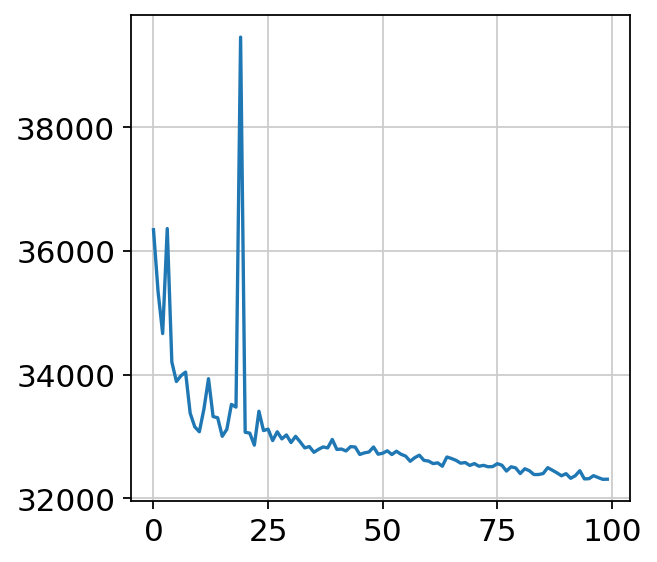

In [376]:
plt.plot(elbos[:])

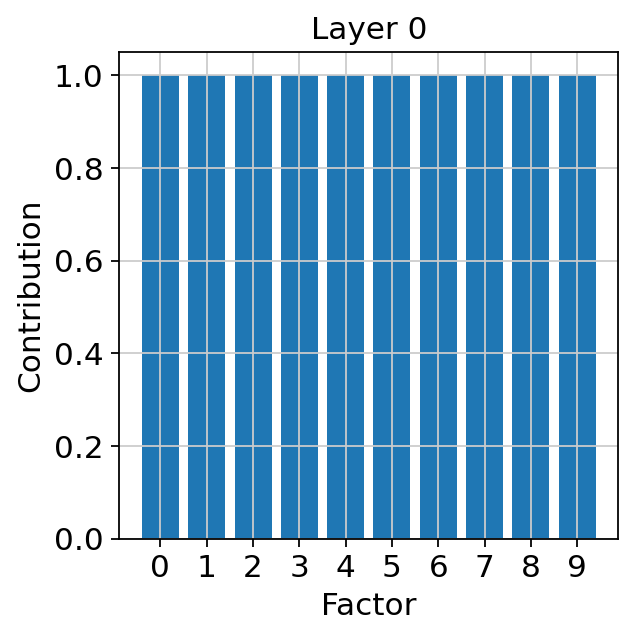

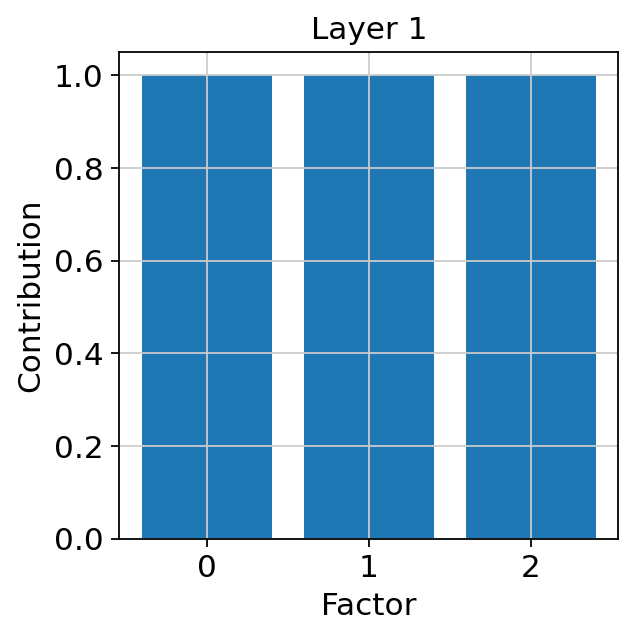

In [377]:
scdpf.plot_ard(layer_idx=0)
scdpf.plot_ard(layer_idx=1)

In [378]:
scdpf.adata.obsm['X_hfactors'] = scdpf.pmeans['hz']
scdpf.adata.obsm['X_factors'] = scdpf.pmeans['z'] * scdpf.pmeans['cell_scale'].reshape(-1,1)

In [379]:
scdpf.adata.obs['X_hfactor'] = np.argmax(scdpf.adata.obsm['X_hfactors'], axis=1).astype(str)
scdpf.adata.obs['X_factor'] = np.argmax(scdpf.adata.obsm['X_factors'], axis=1).astype(str)

In [380]:
for i in range(10):
    scdpf.adata.obs[f'{i}'] = scdpf.adata.obsm['X_factors'][:,i]
    
for i in range(3):
    scdpf.adata.obs[f'h{i}'] = scdpf.adata.obsm['X_hfactors'][:,i]

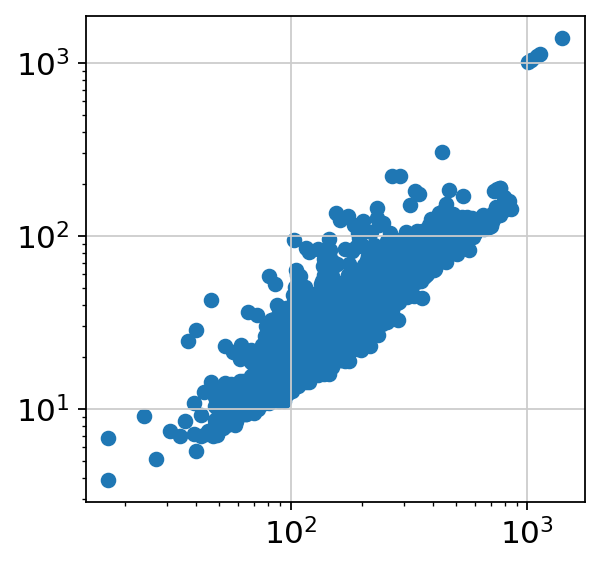

In [381]:
plt.scatter(np.sum(scdpf.adata.X, axis=1), 1./scdpf.pmeans['cell_scale'])
plt.xscale('log')
plt.yscale('log')

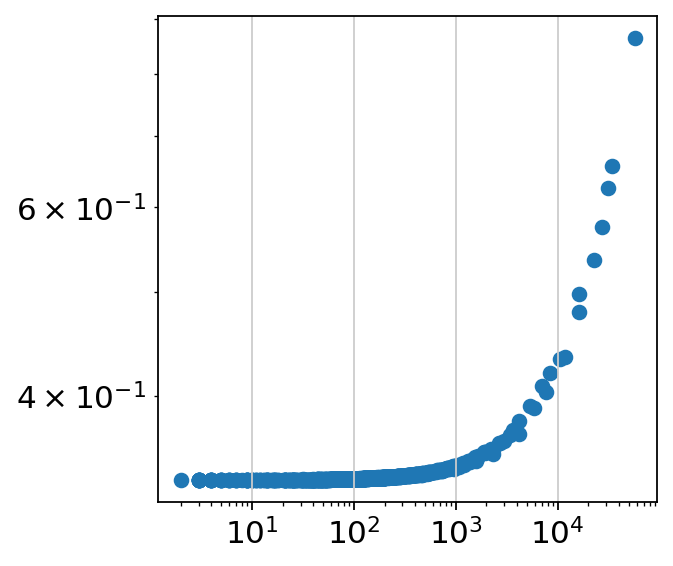

In [382]:
plt.scatter(np.sum(scdpf.adata.X, axis=0), 1/scdpf.pmeans['gene_scale'])
plt.xscale('log')
plt.yscale('log')

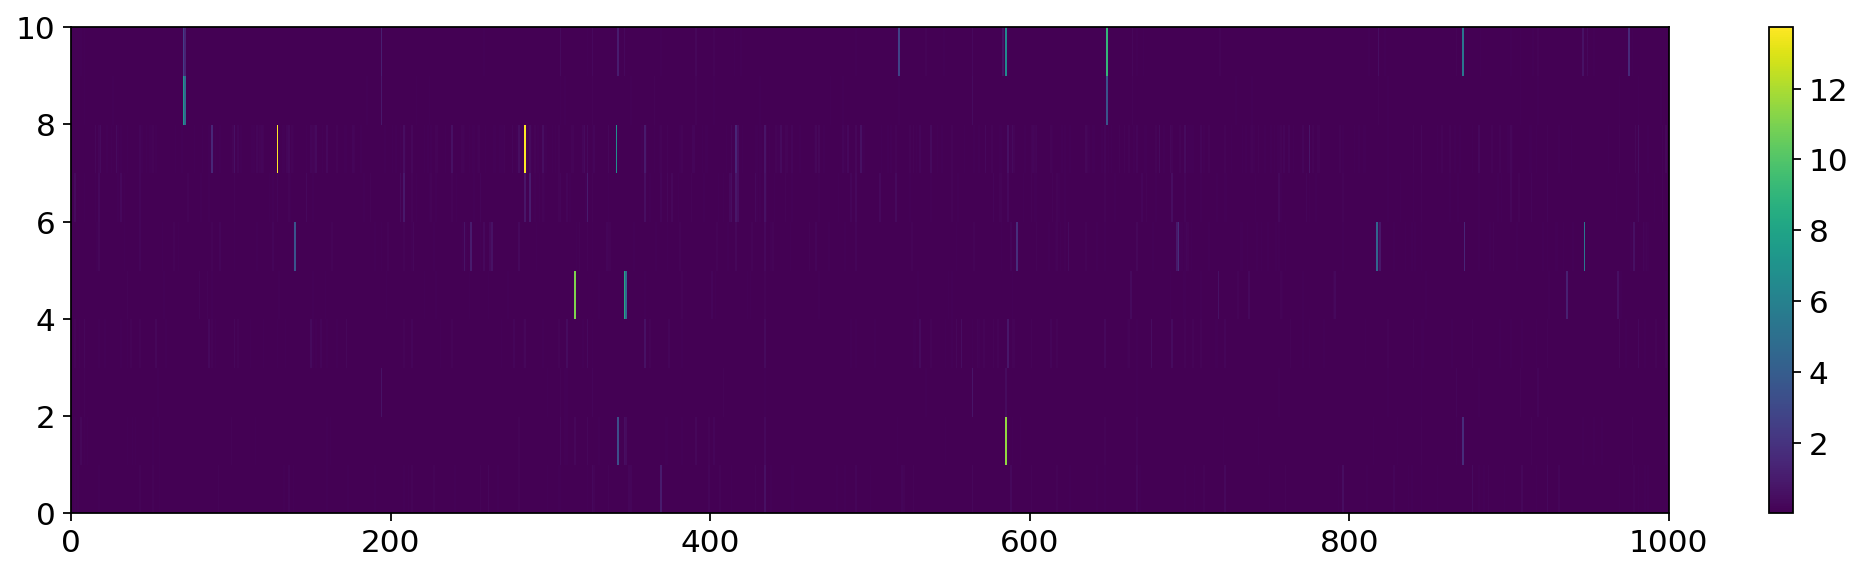

In [383]:
plt.figure(figsize=(16,4))
plt.pcolormesh(scdpf.pmeans['W'] * scdpf.pmeans['gene_scale'])
plt.colorbar()

/cluster/home/pedrof/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'X_hfactor' as categorical
/cluster/home/pedrof/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'X_factor' as categorical


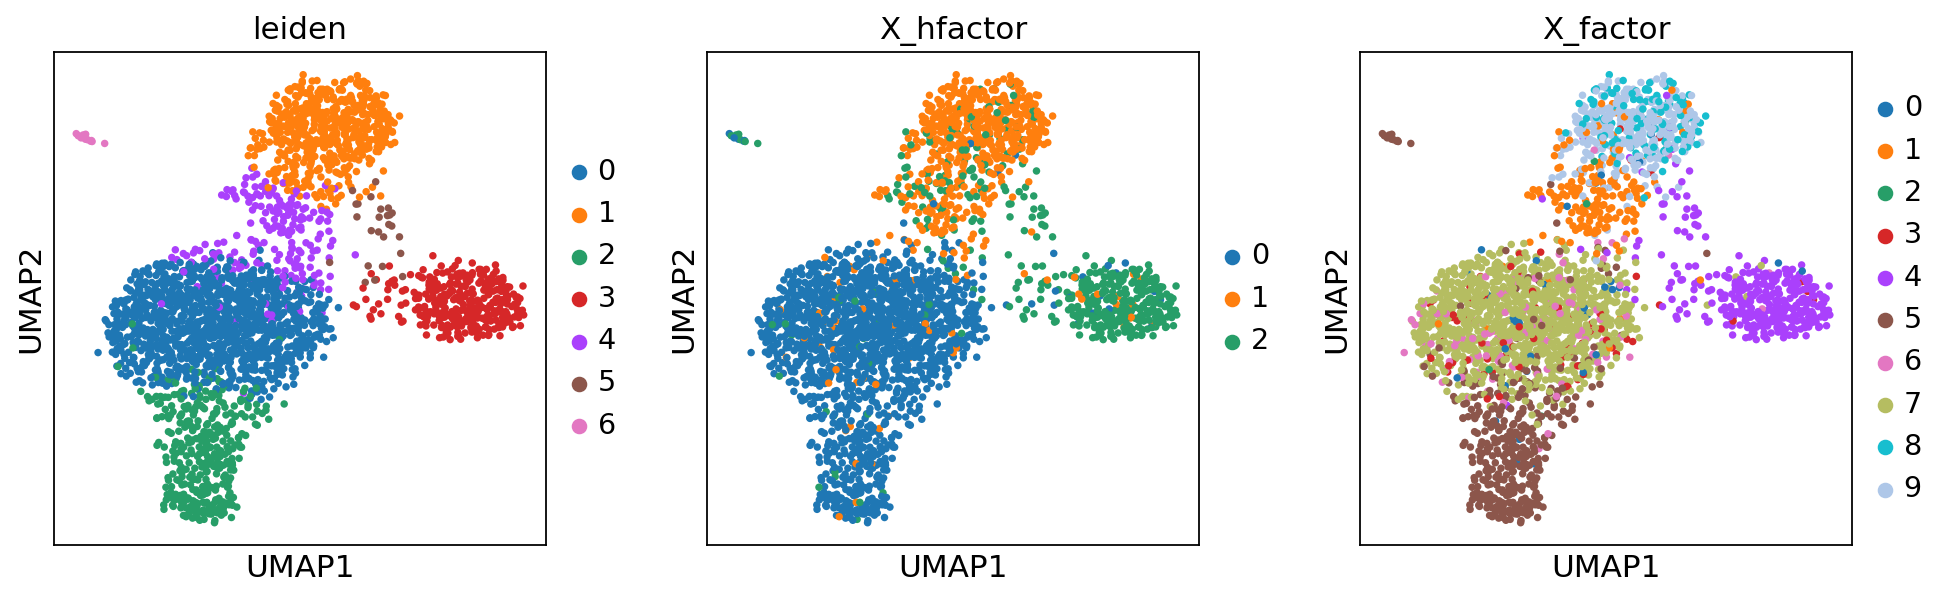

In [384]:
sc.pl.umap(scdpf.adata, color=['leiden', 'X_hfactor', 'X_factor'])

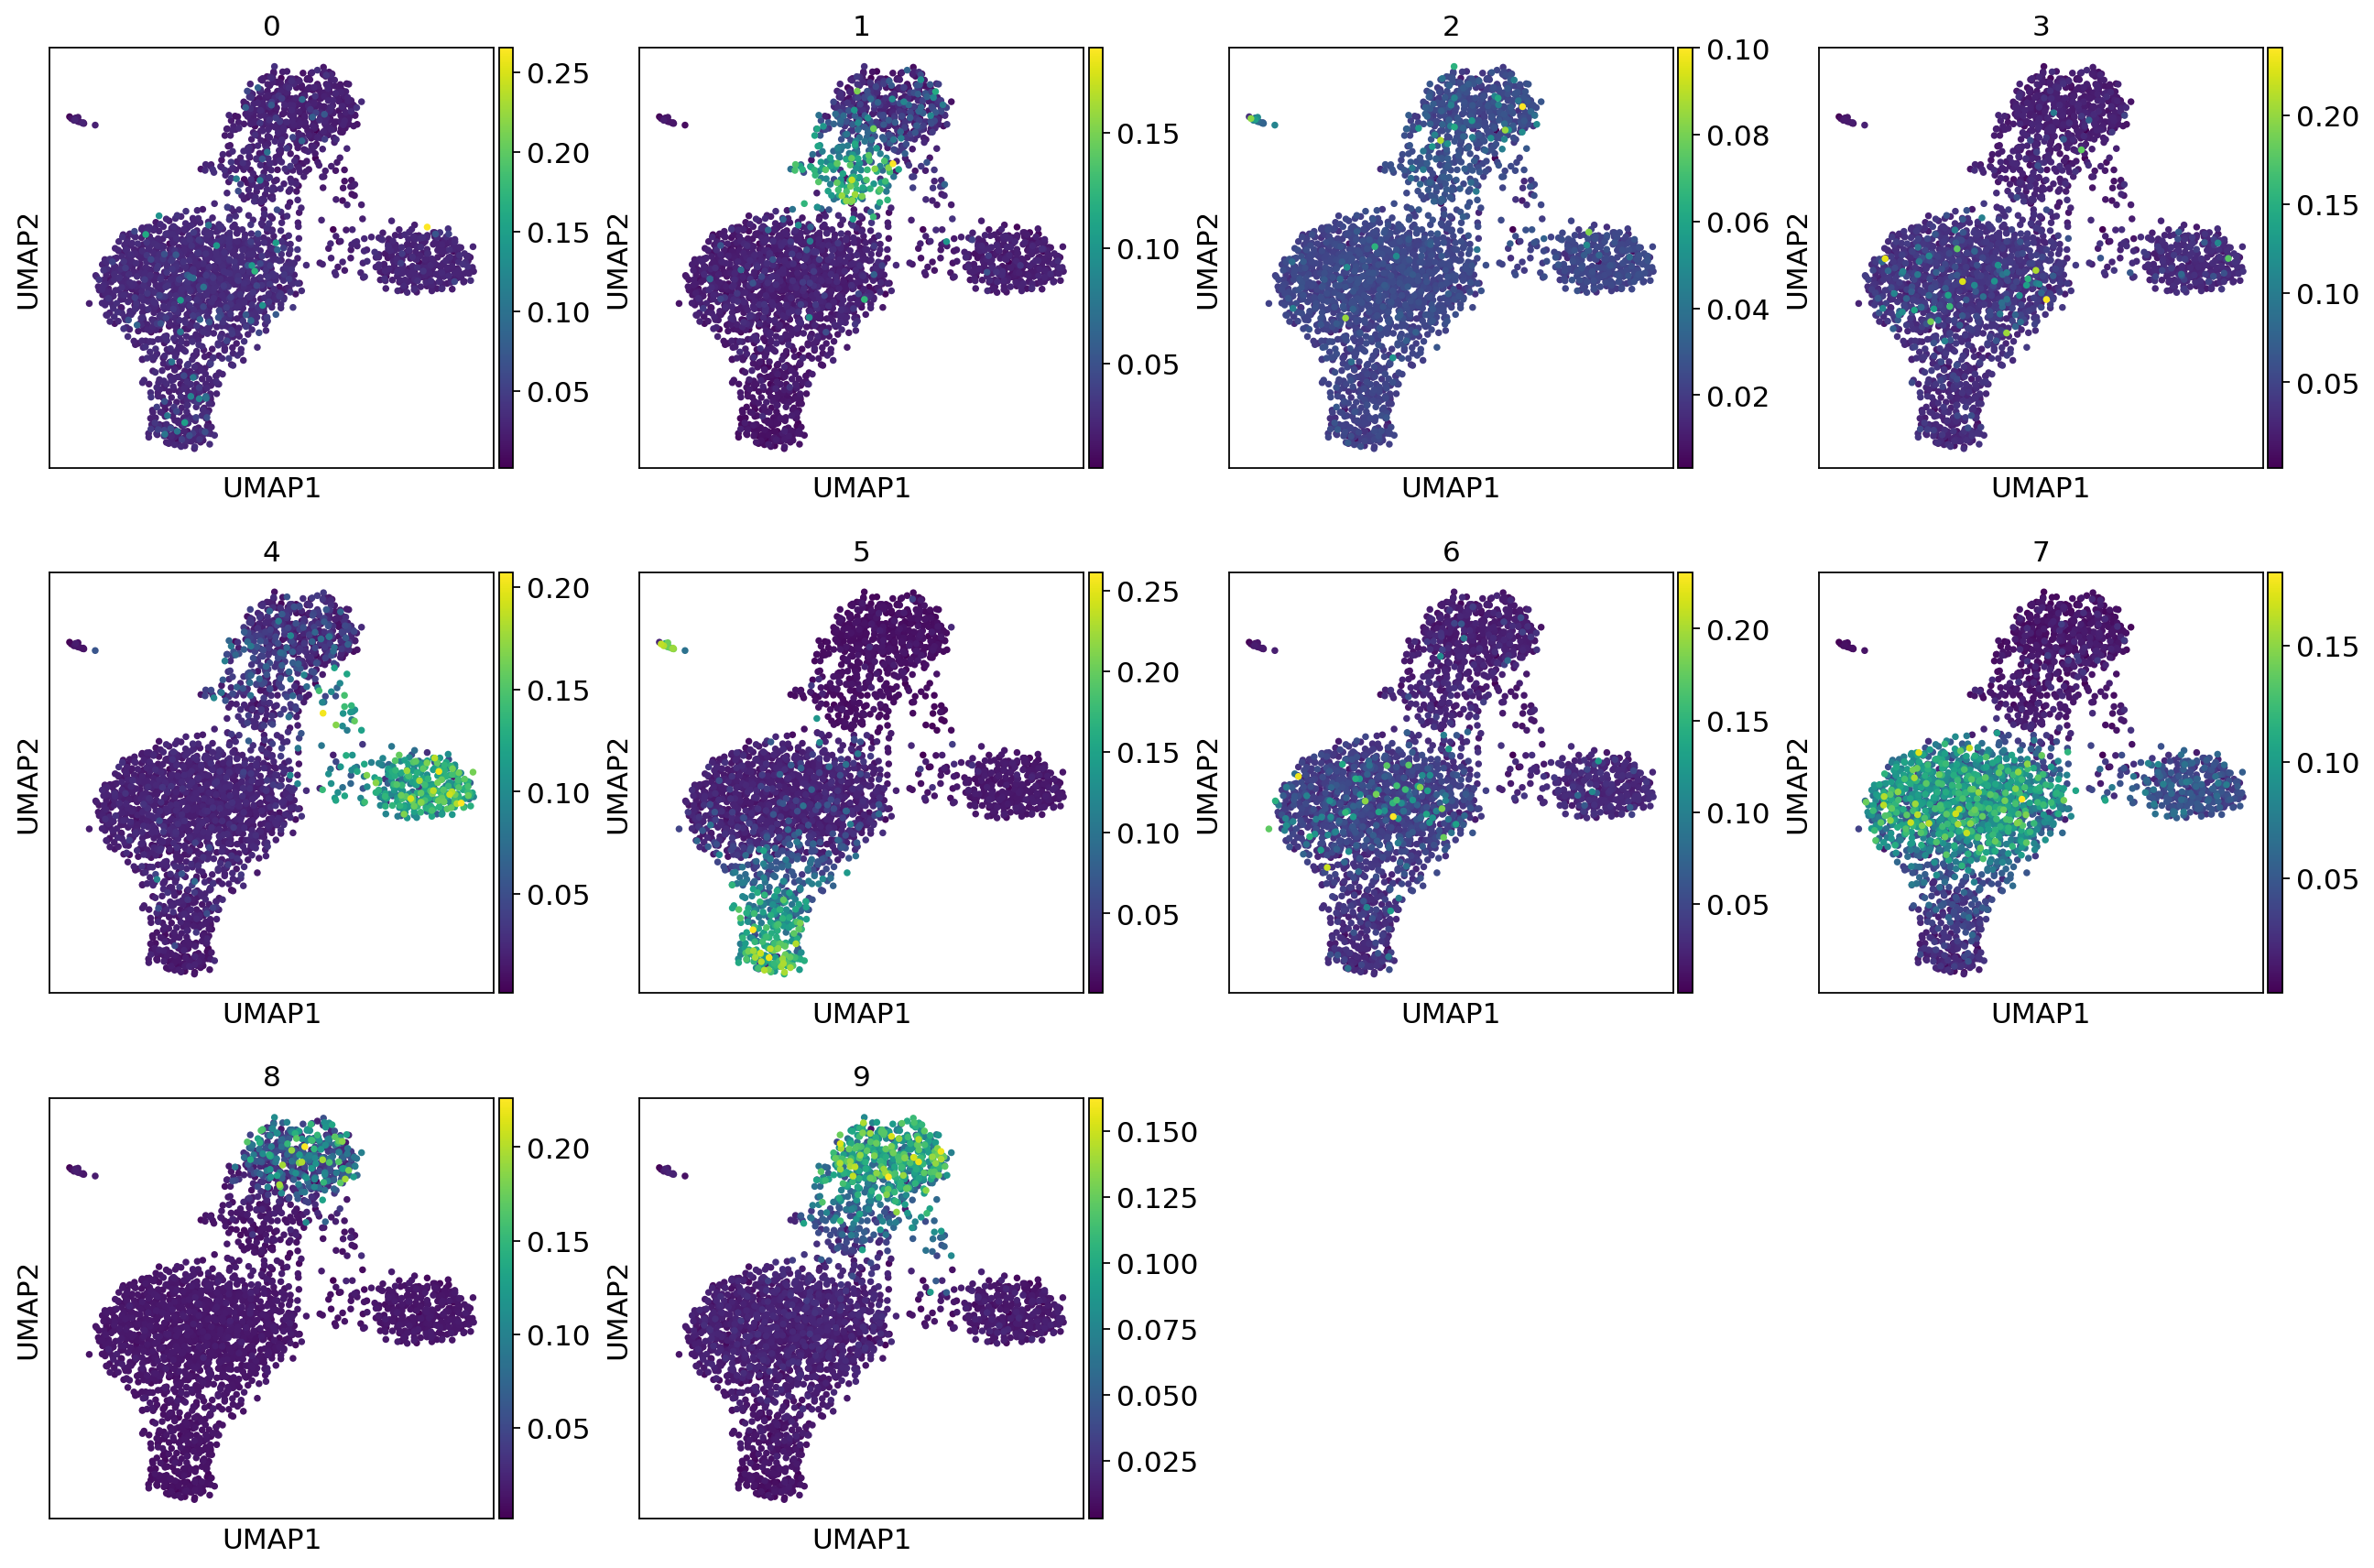

In [385]:
sc.pl.umap(scdpf.adata, color=[str(i) for i in range(10)])

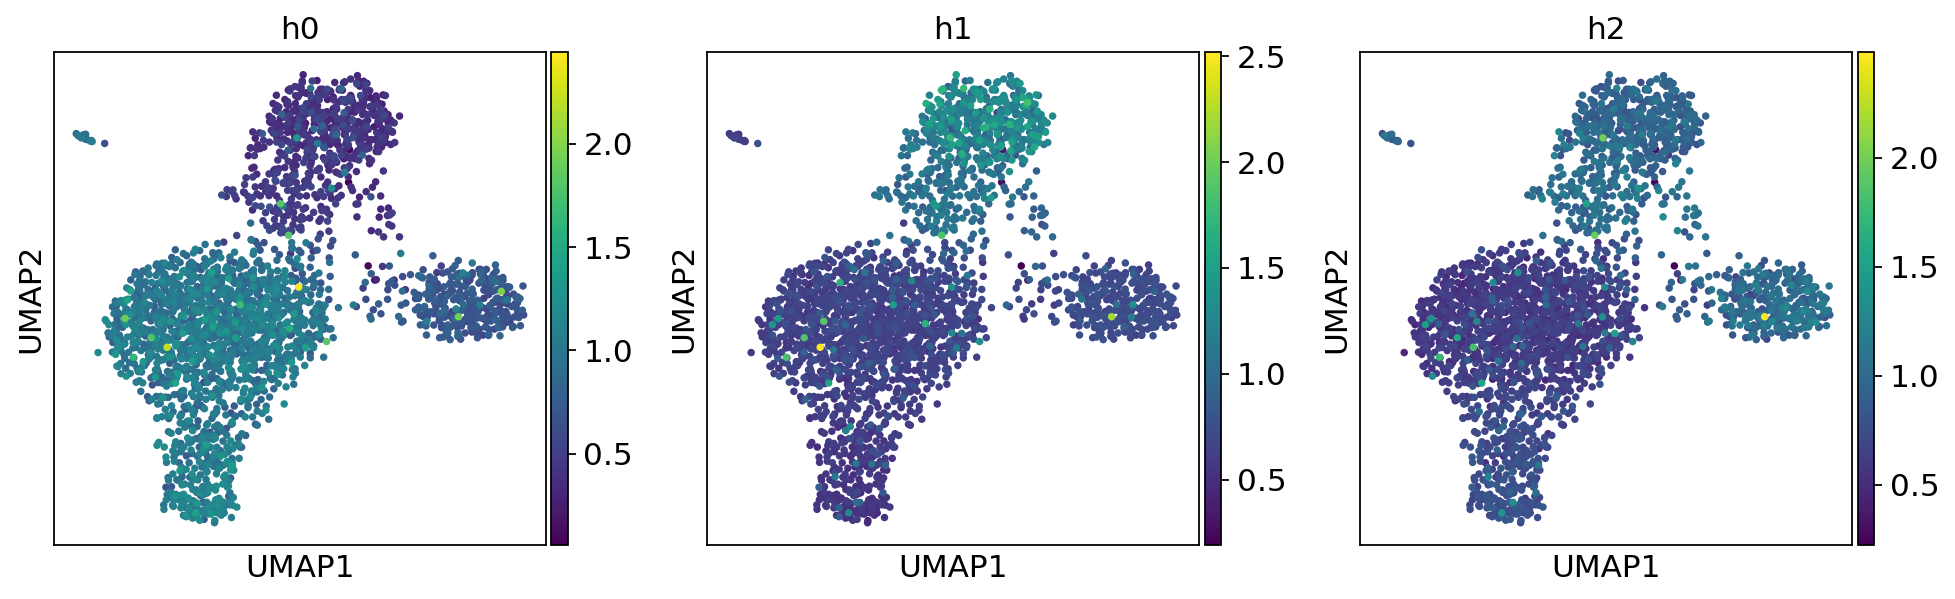

In [386]:
sc.pl.umap(scdpf.adata, color=[f'h{i}' for i in range(3)])

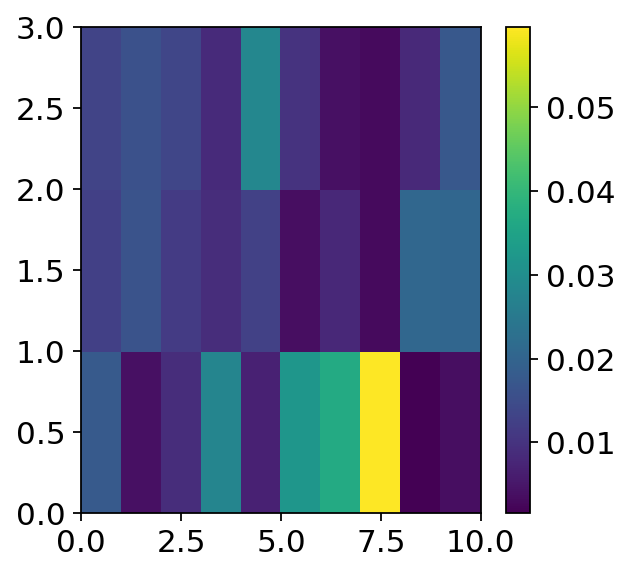

In [387]:
plt.pcolormesh(scdpf.pmeans['hW']);plt.colorbar()

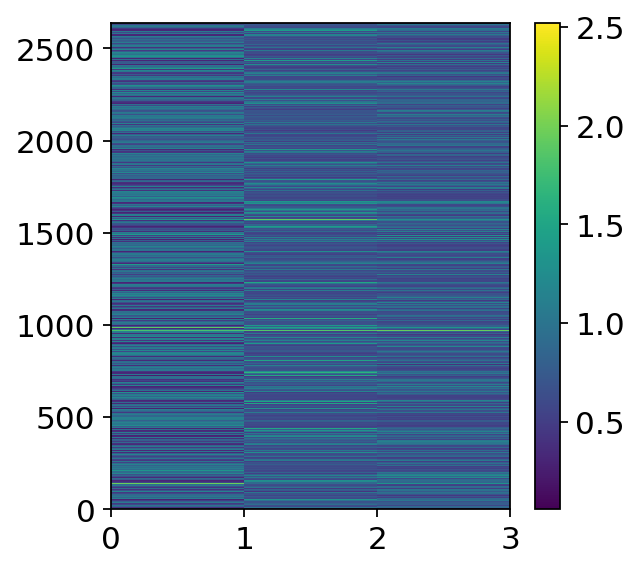

In [388]:
# plt.figure(figsize=(10,22))
plt.pcolormesh(scdpf.pmeans['hz']);plt.colorbar()

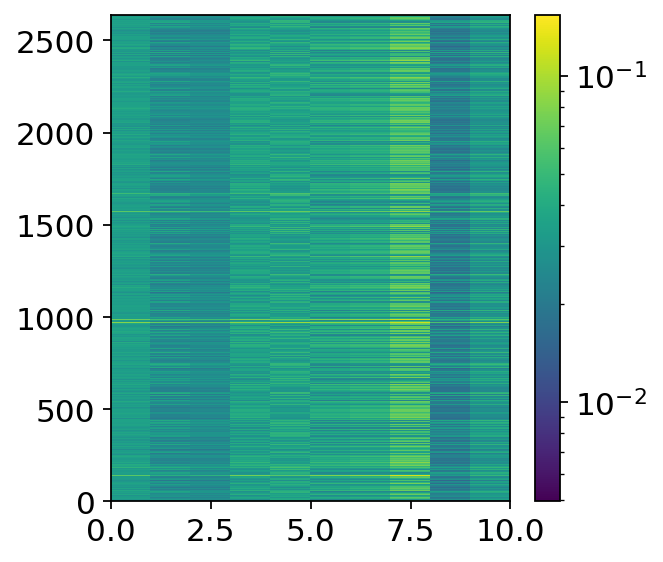

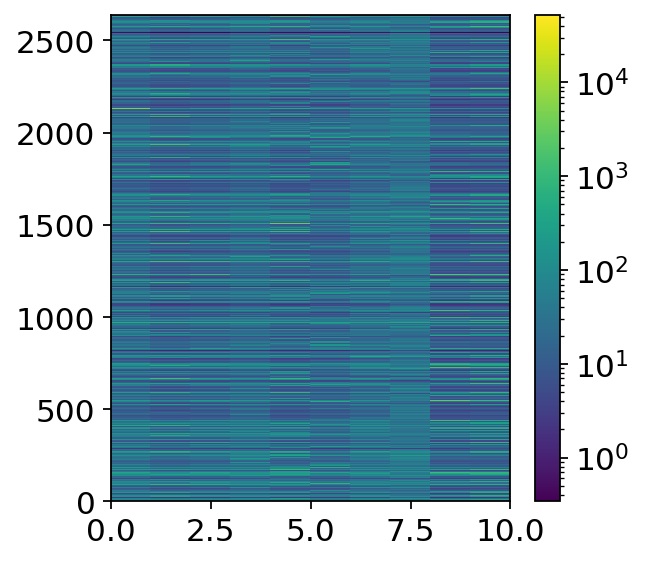

In [389]:
means = scdpf.pmeans['hz'].dot(scdpf.pmeans['hW'])
obs = scdpf.pmeans['z'] /scdpf.pmeans['cell_scale'][:,None]

from matplotlib import colors

plt.pcolormesh(means,  norm=colors.LogNorm(vmin=means.min(), vmax=means.max()));plt.colorbar();plt.show()

plt.pcolormesh(obs,  norm=colors.LogNorm(vmin=obs.min(), vmax=obs.max()));plt.colorbar();plt.show()

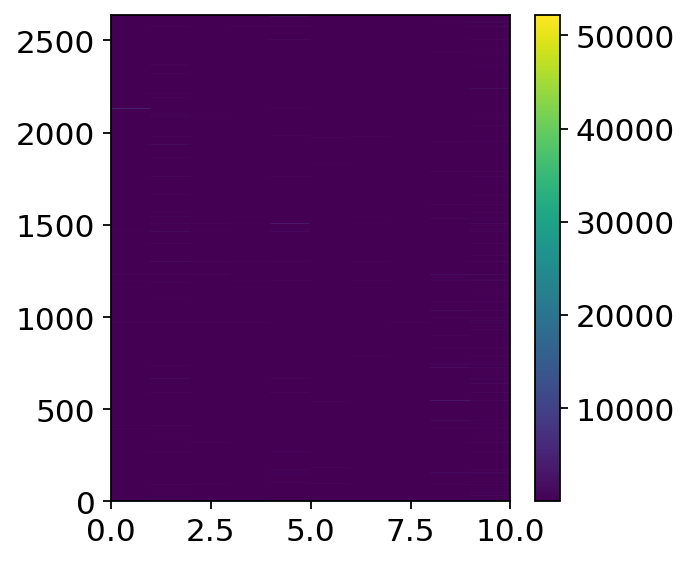

In [390]:
means = obs - means
plt.pcolormesh(means);plt.colorbar();plt.show()

In [391]:
import seaborn as sns

/cluster/apps/python/3.8.5_gpu_gcc630/x86_64/lib64/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


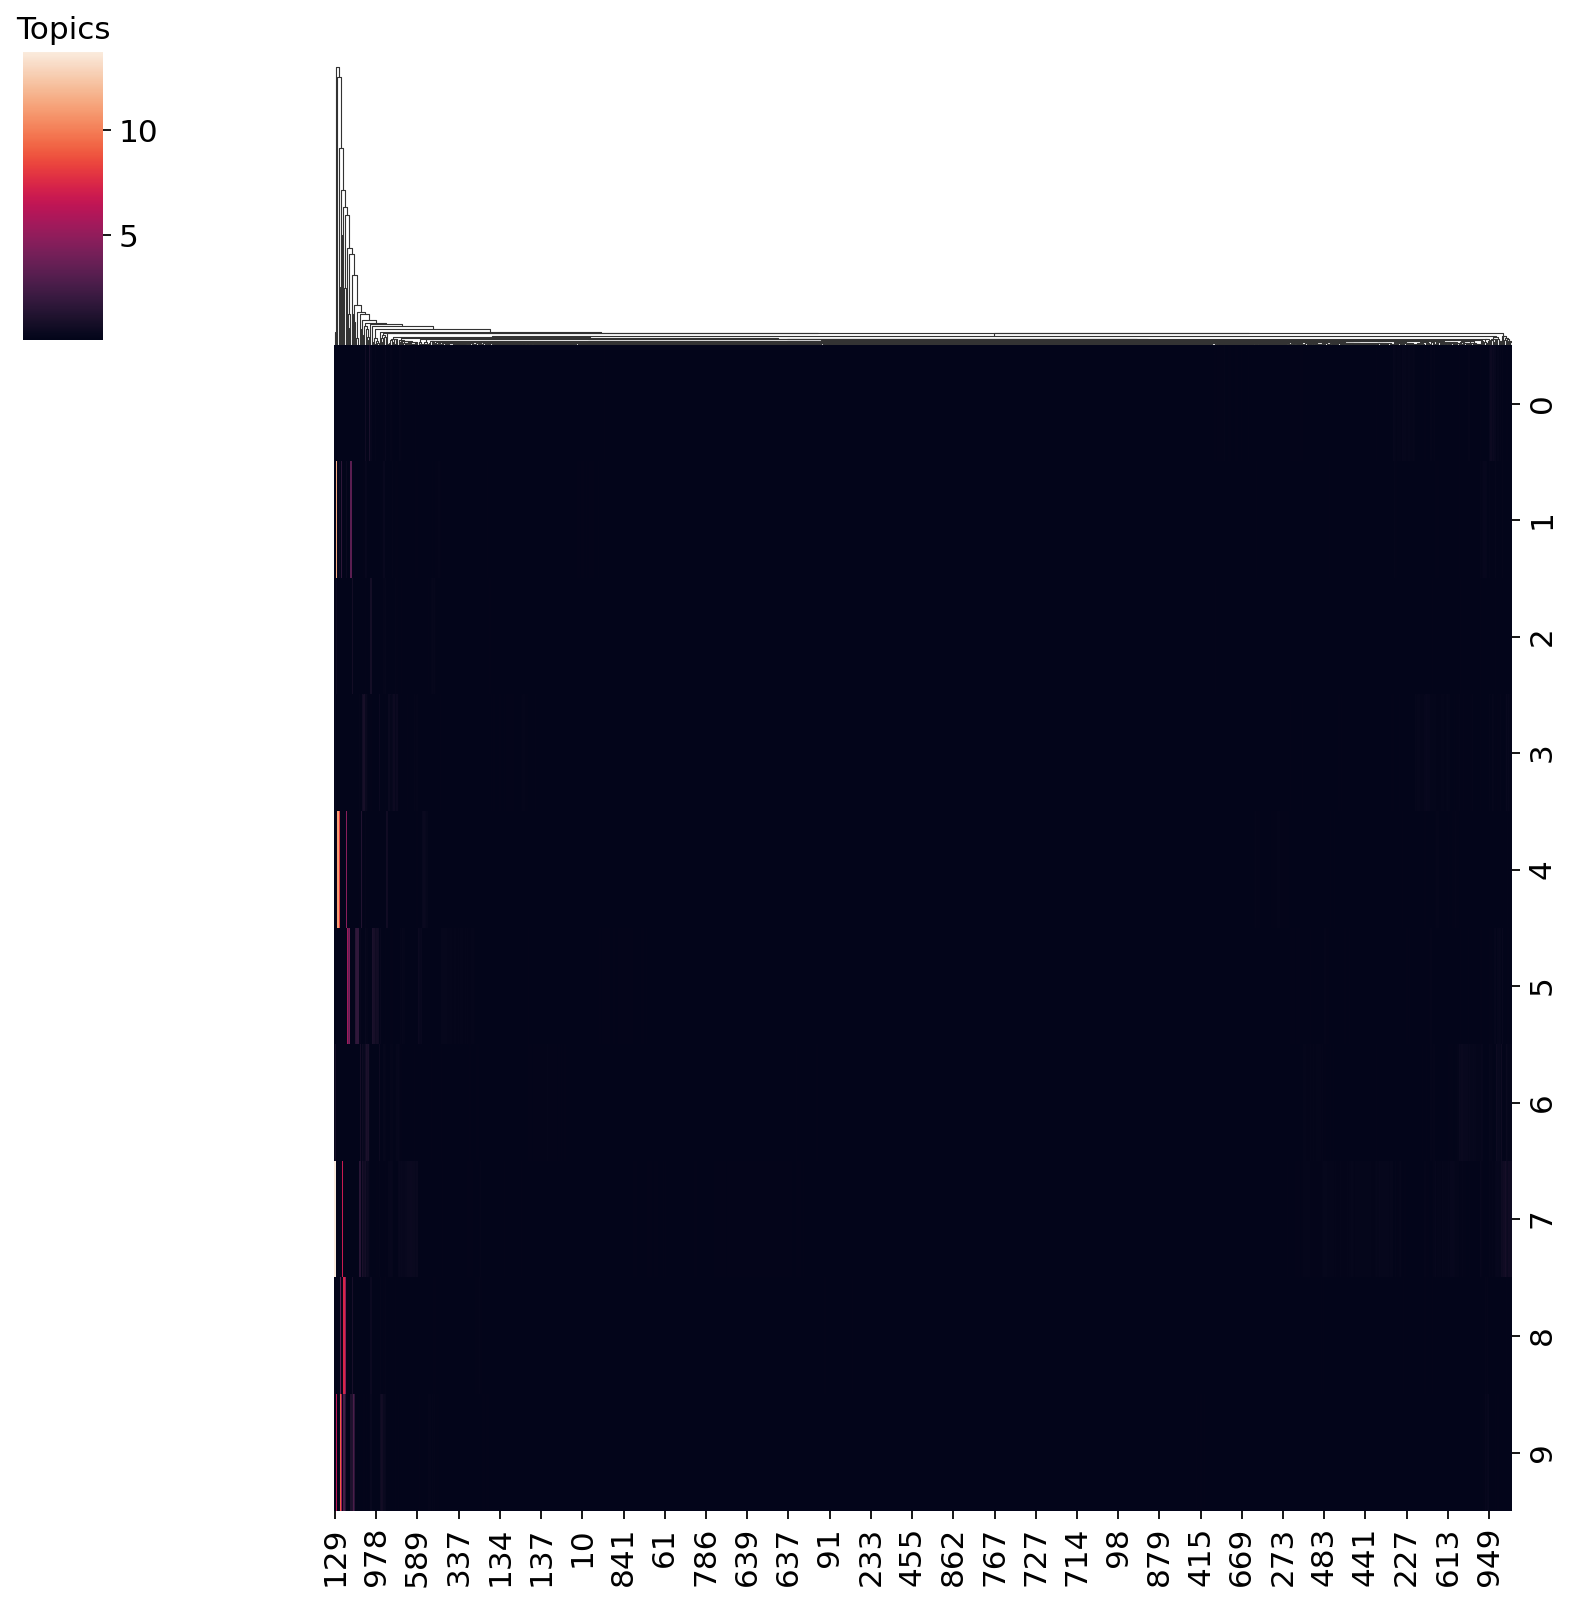

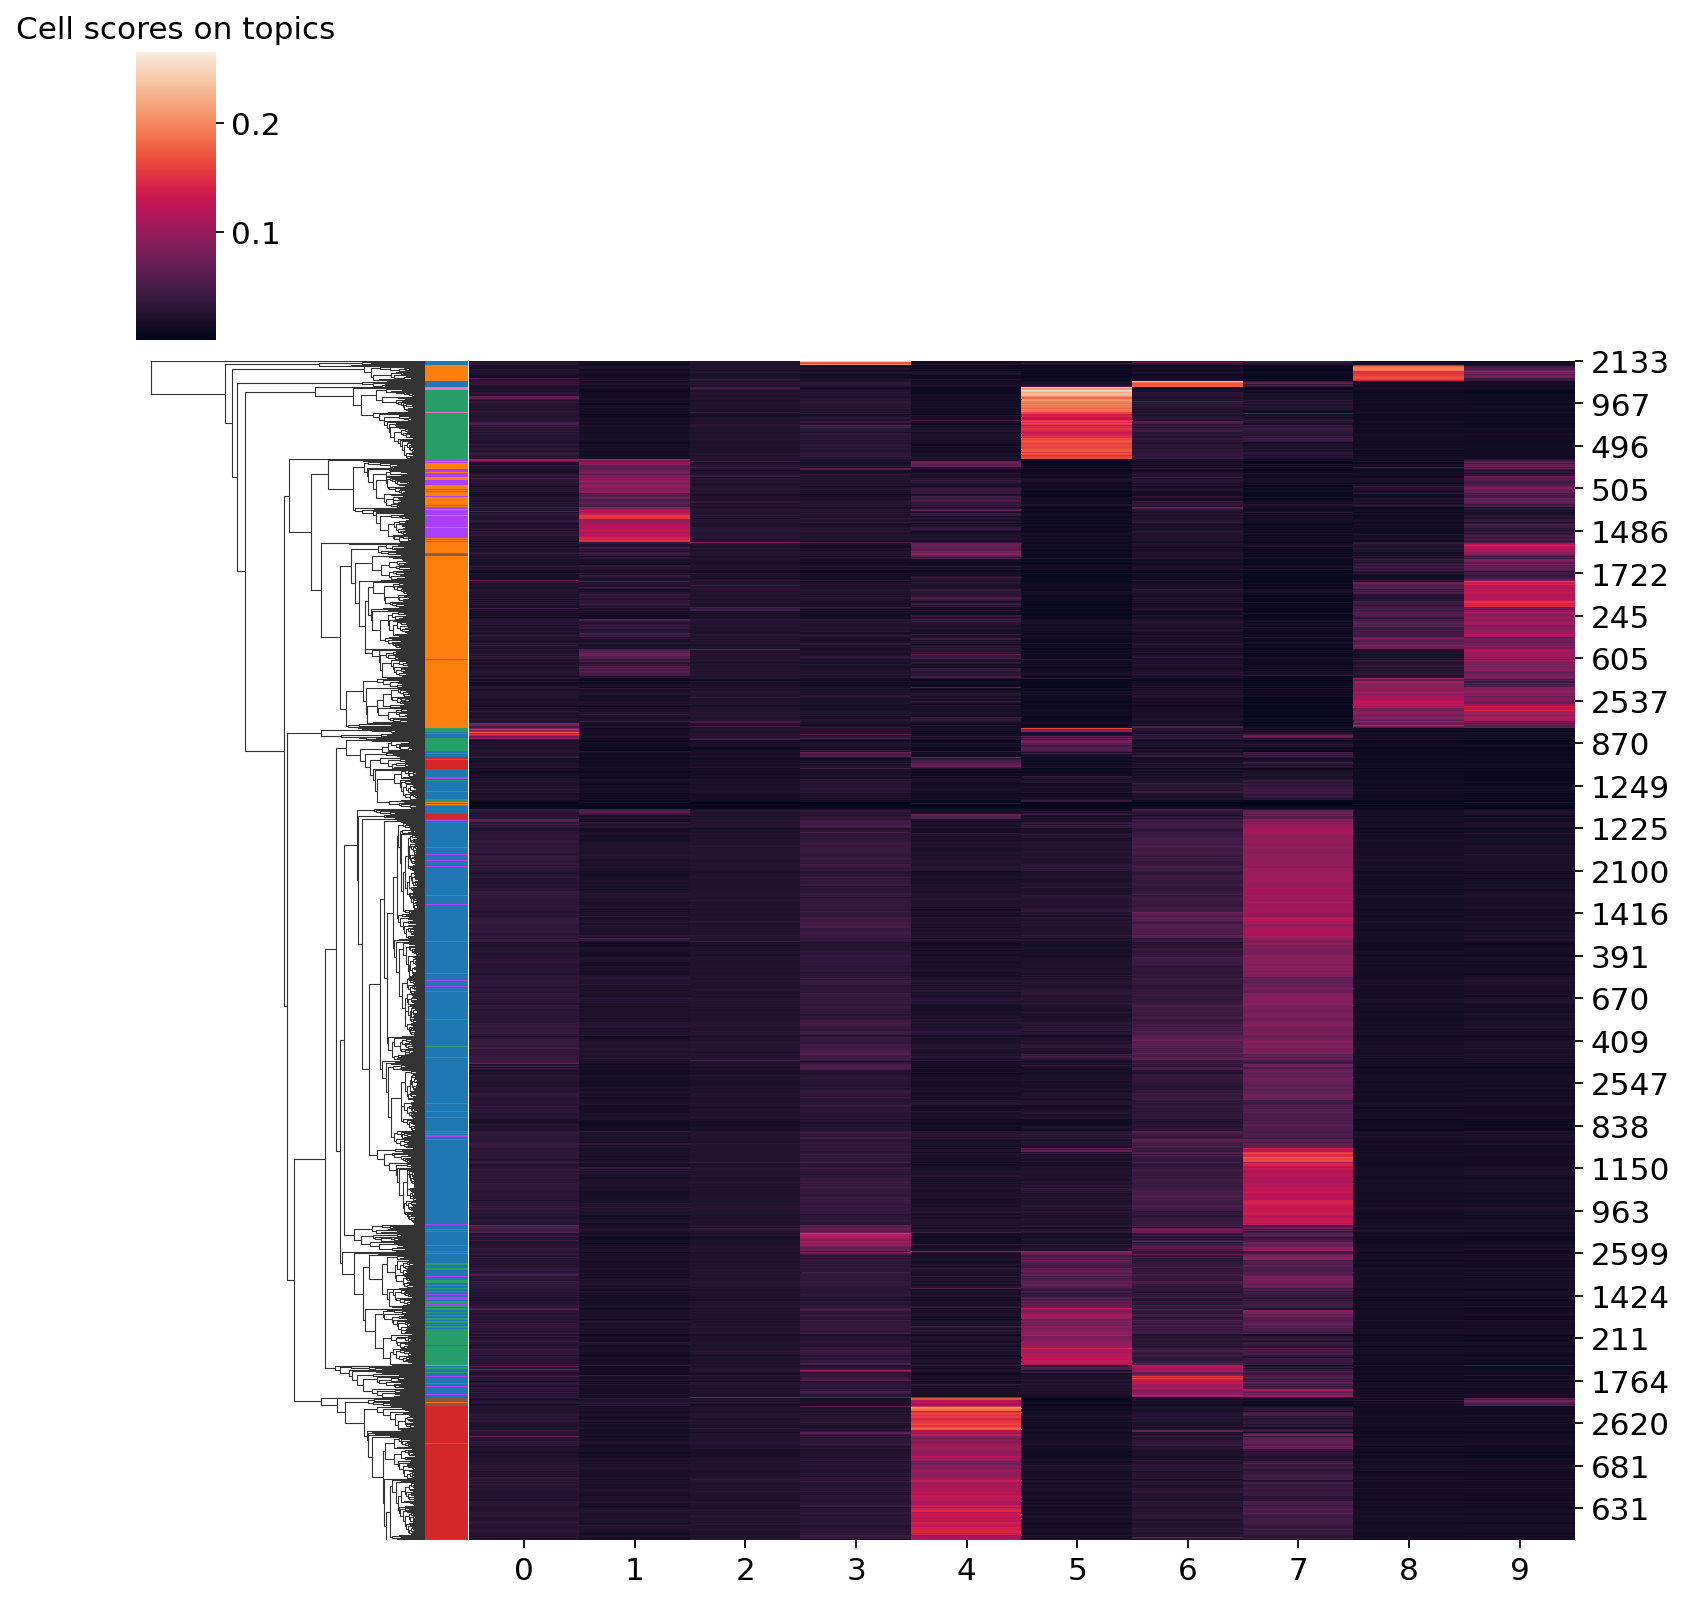

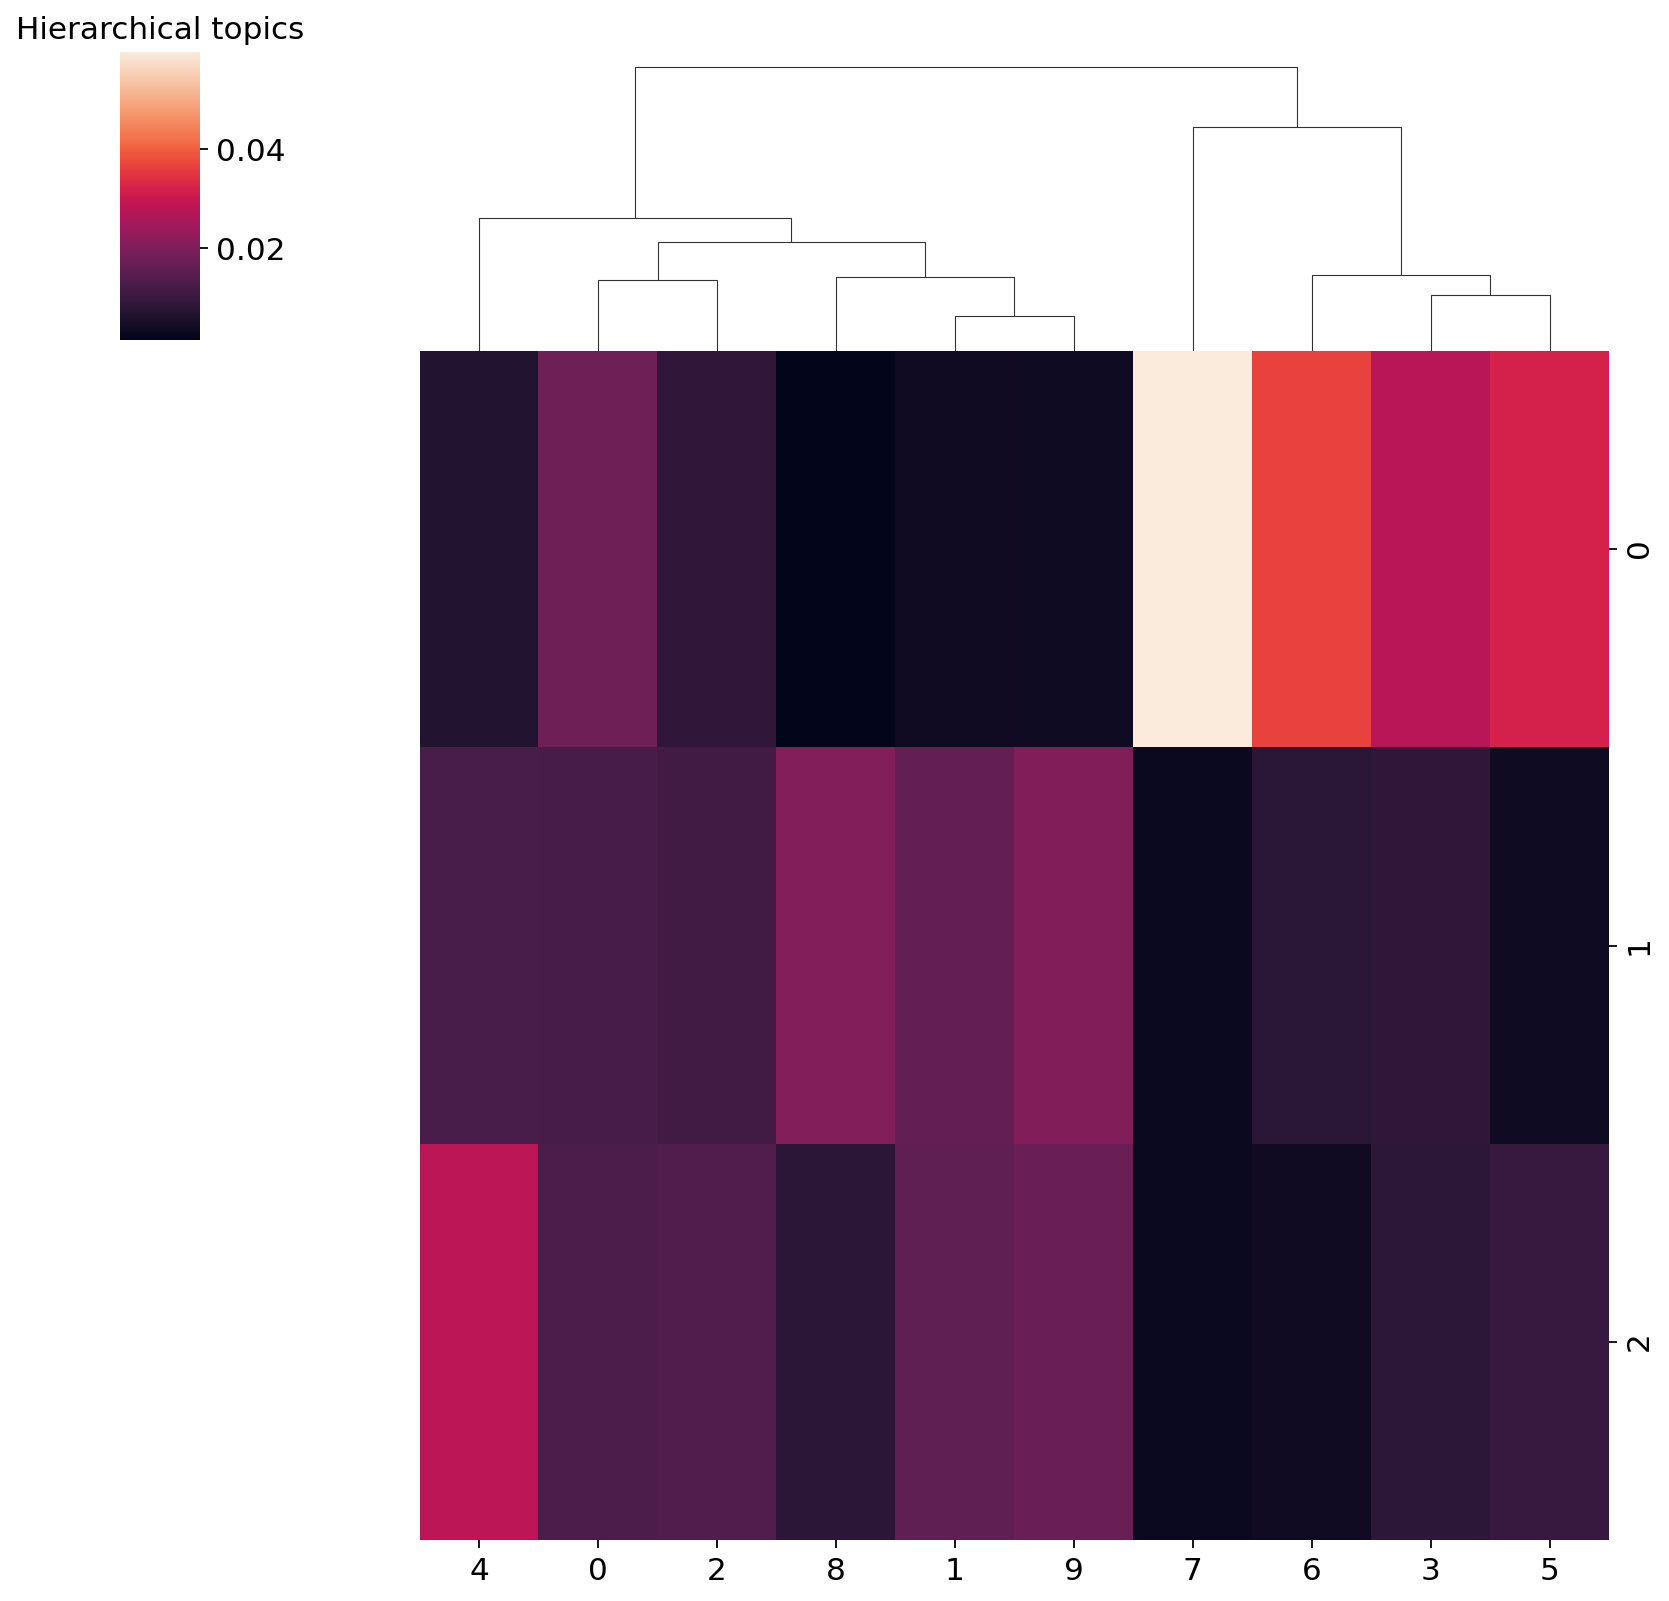

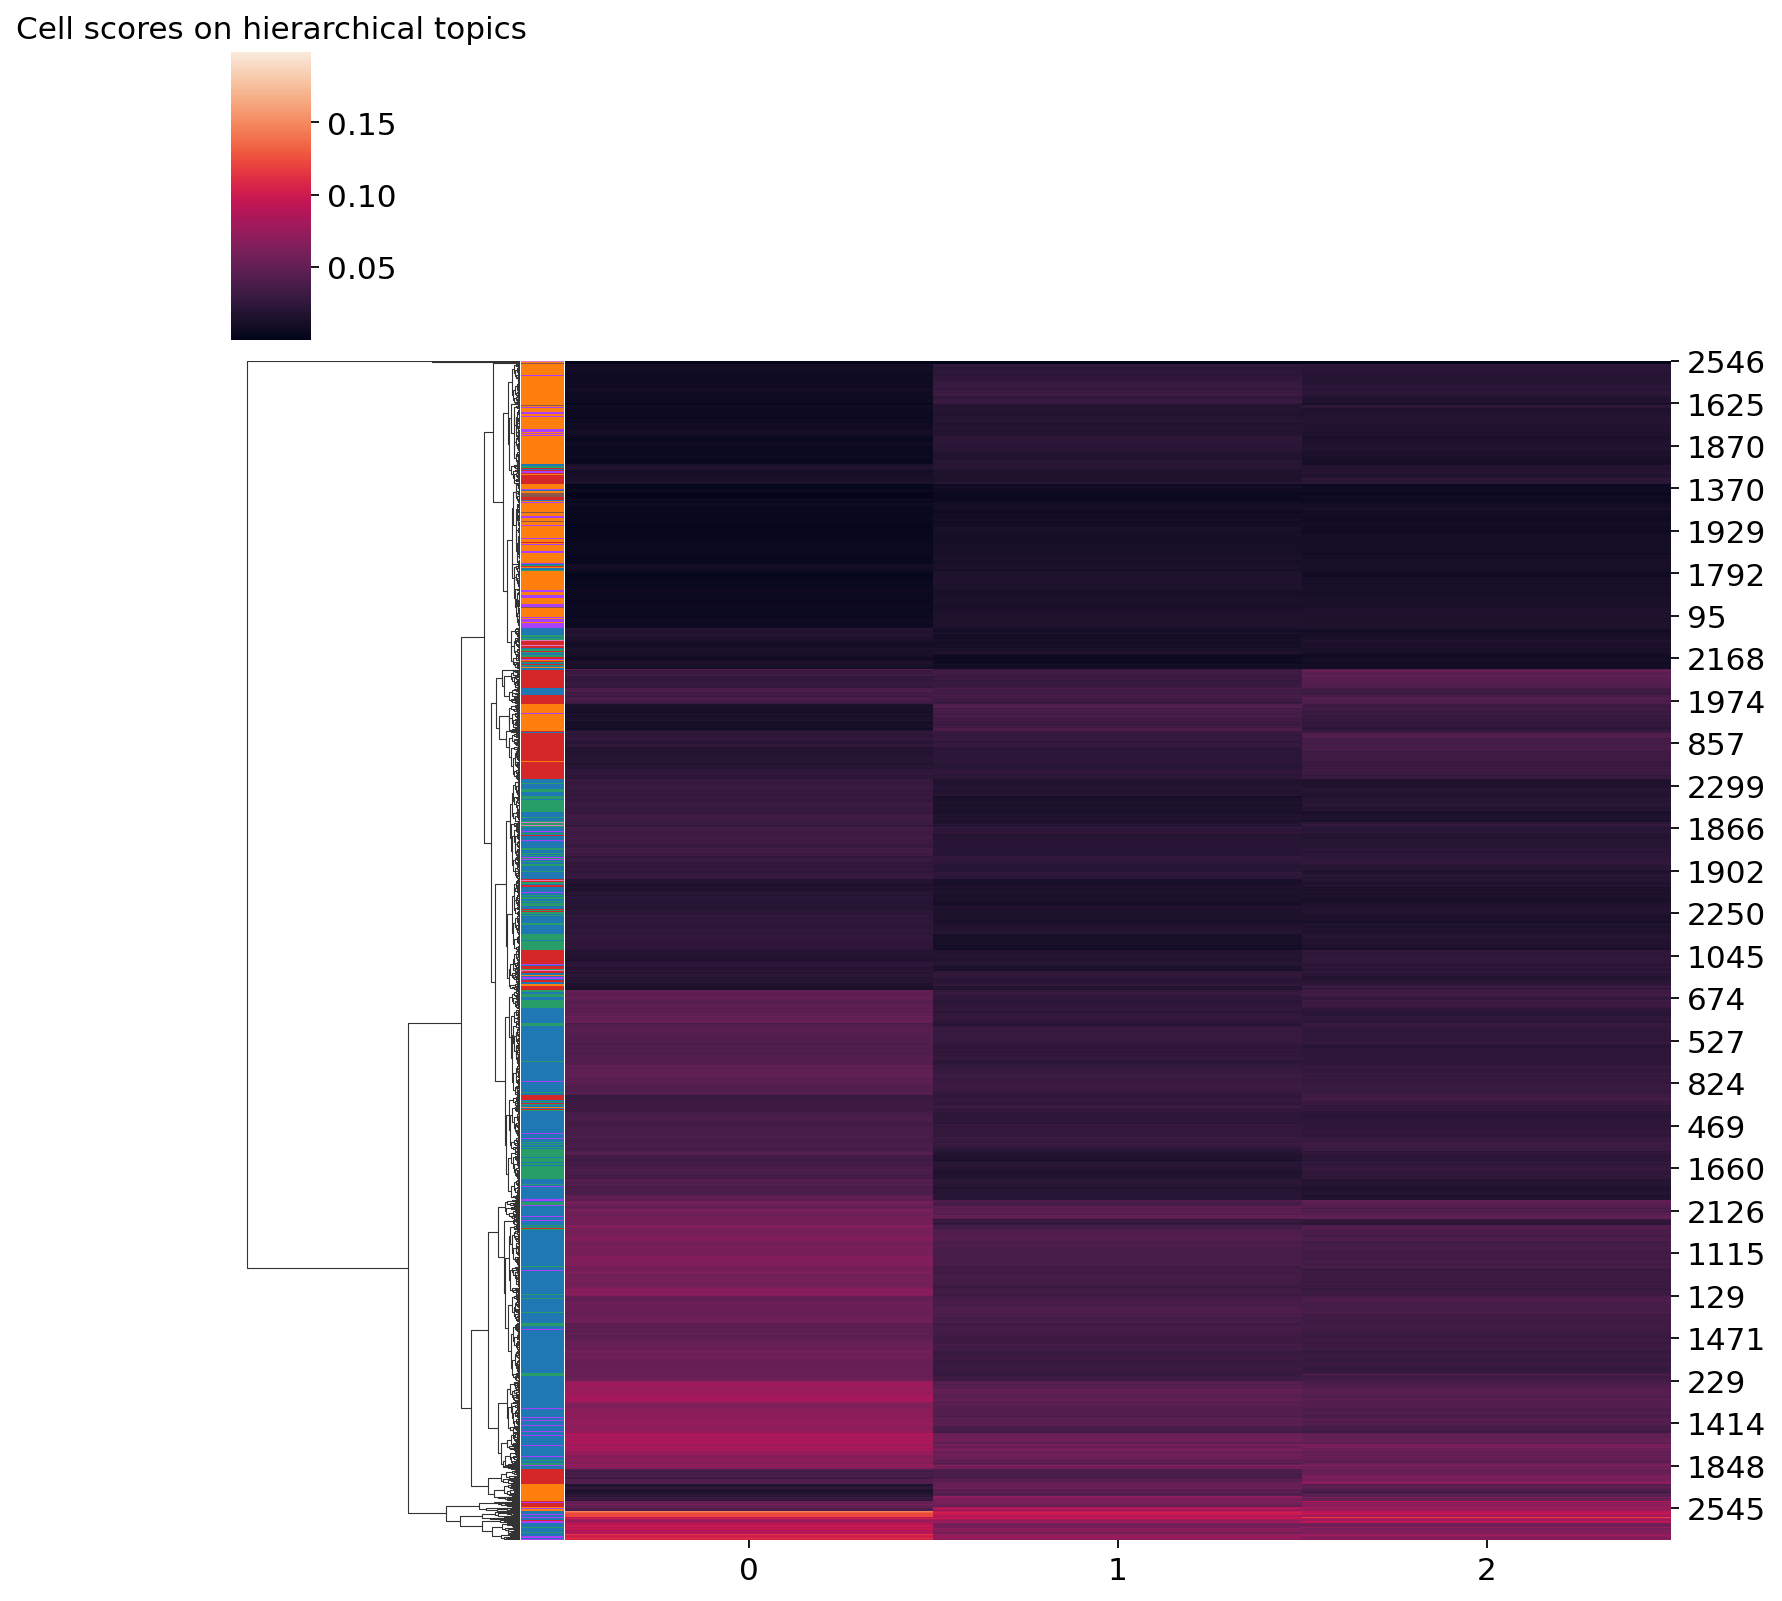

In [392]:
lut = dict(zip(np.unique(adata.obs['leiden']), adata.uns['leiden_colors']))
row_colors = adata.obs['leiden'].map(lut)

sns.clustermap(scdpf.pmeans['W'] * scdpf.pmeans['gene_scale'], row_cluster=False)
plt.title('Topics')
plt.show()


sns.clustermap(scdpf.pmeans['z'] * scdpf.pmeans['cell_scale'].reshape(-1,1), col_cluster=False, 
               row_colors=row_colors.values)
plt.title('Cell scores on topics')
plt.show()

sns.clustermap(scdpf.pmeans['hW'], row_cluster=False)
plt.title('Hierarchical topics')
plt.show()

sns.clustermap(scdpf.pmeans['hz'] * scdpf.pmeans['cell_scale'].reshape(-1,1), col_cluster=False, row_colors=row_colors.values)
plt.title('Cell scores on hierarchical topics')
plt.show()

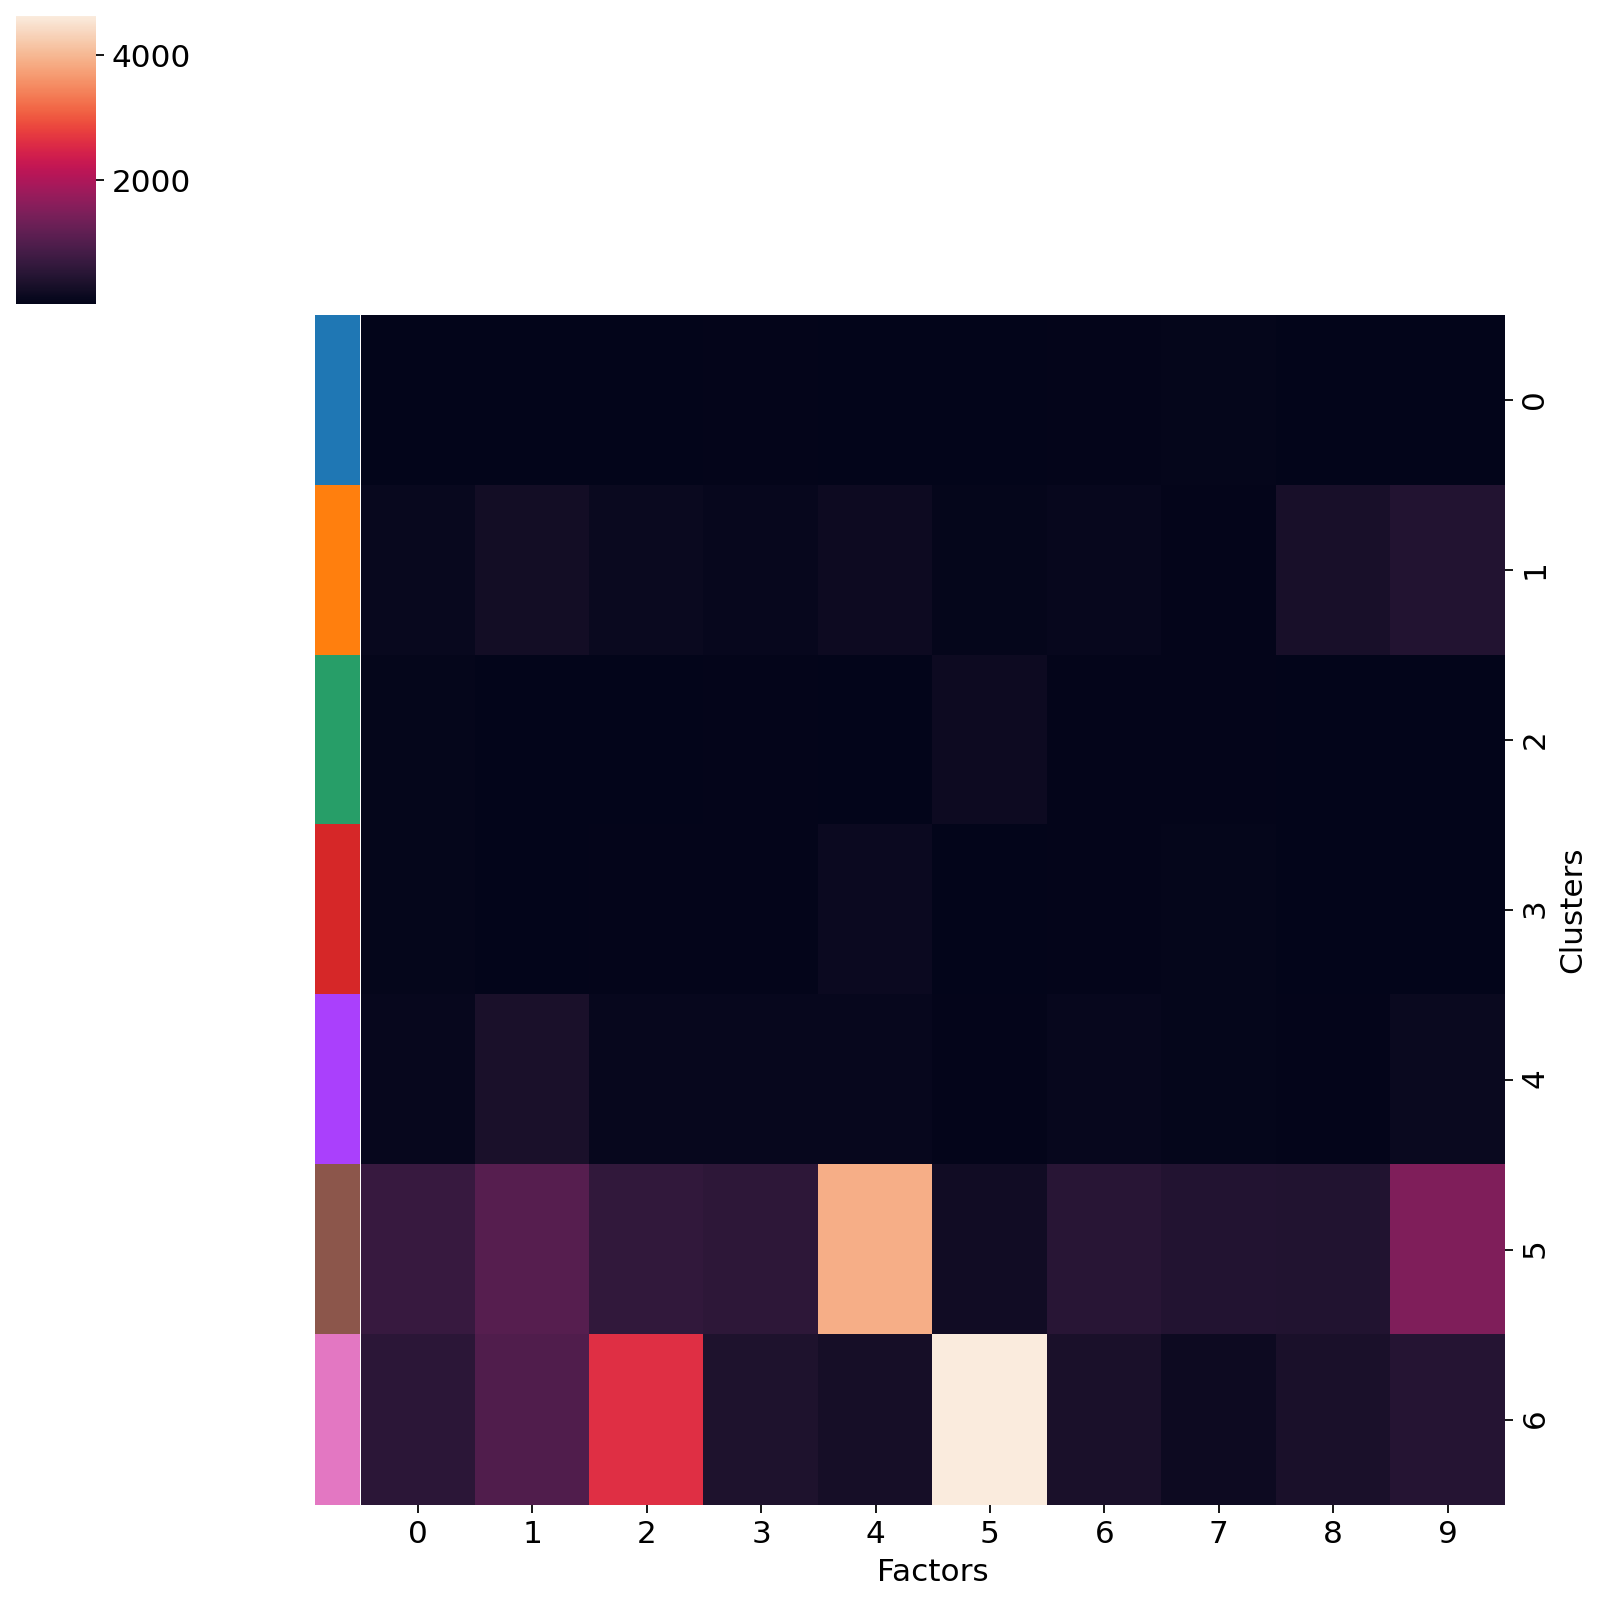

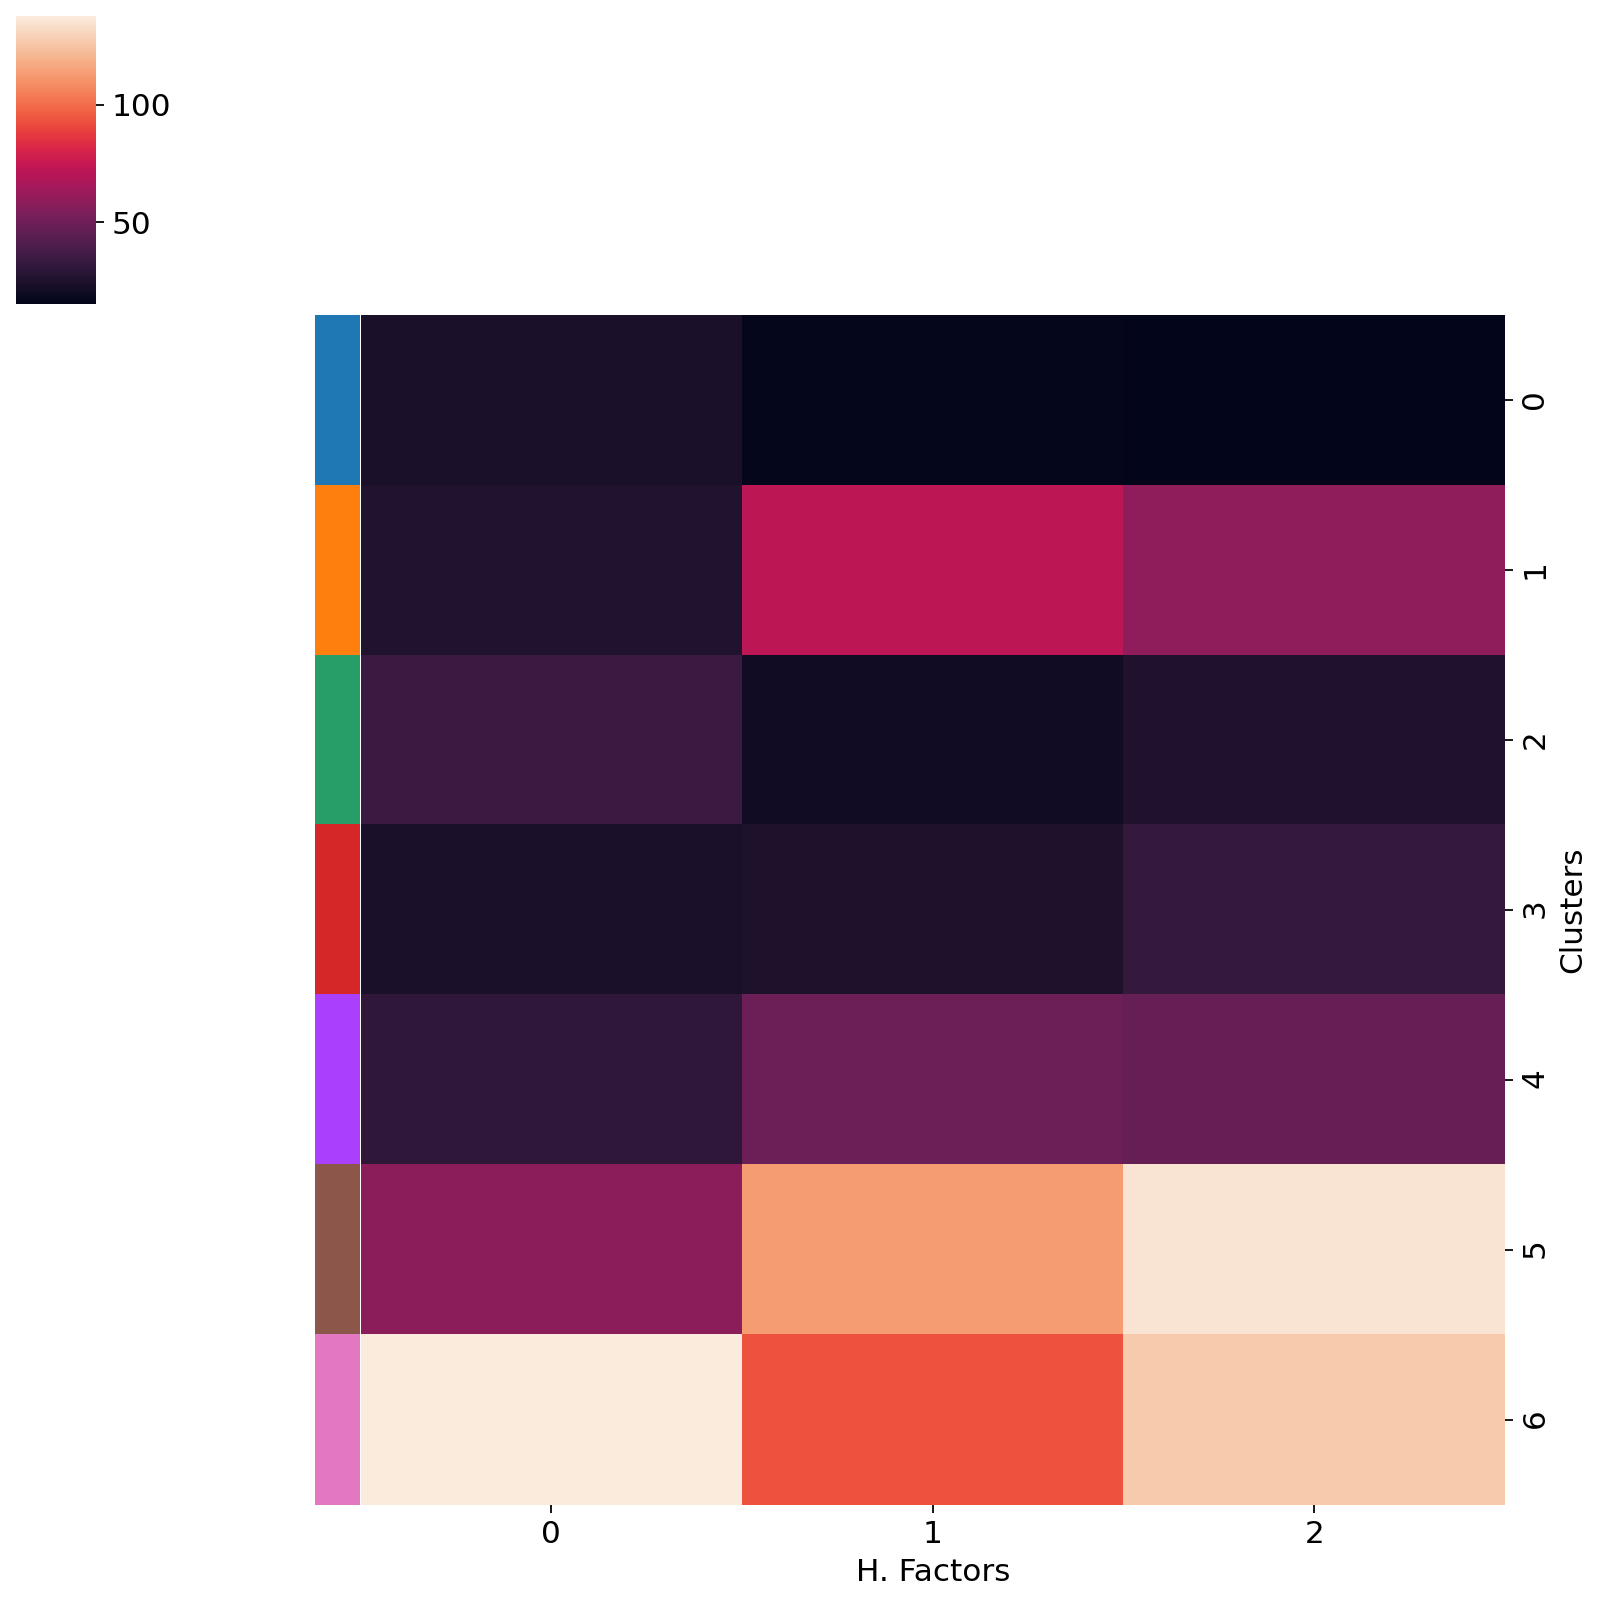

In [393]:
cluster_assignments = adata.obs['leiden']
unique_cluster_ids = np.unique(cluster_assignments.values)
cell_scores = scdpf.pmeans['z'] / scdpf.pmeans['cell_scale'].reshape(-1,1)
cell_hscores = scdpf.pmeans['hz'] / scdpf.pmeans['cell_scale'].reshape(-1,1)
mean_cluster_scores = []
mean_cluster_hscores = []
for c in unique_cluster_ids:
    cell_idx = np.where(cluster_assignments == c)[0]
    mean_cluster_scores.append(np.mean(cell_scores[cell_idx], axis=0))
    mean_cluster_hscores.append(np.mean(cell_hscores[cell_idx], axis=0))
    
mean_cluster_scores = np.array(mean_cluster_scores)
mean_cluster_hscores = np.array(mean_cluster_hscores)

fig = sns.clustermap(mean_cluster_scores, row_colors=list(lut.values()), col_cluster=False, row_cluster=False)
ax = fig.ax_heatmap
ax.set_xlabel("Factors")
ax.set_ylabel("Clusters")
plt.show()

fig = sns.clustermap(mean_cluster_hscores, row_colors=list(lut.values()), col_cluster=False, row_cluster=False)
ax = fig.ax_heatmap
ax.set_xlabel("H. Factors")
ax.set_ylabel("Clusters")
plt.show()

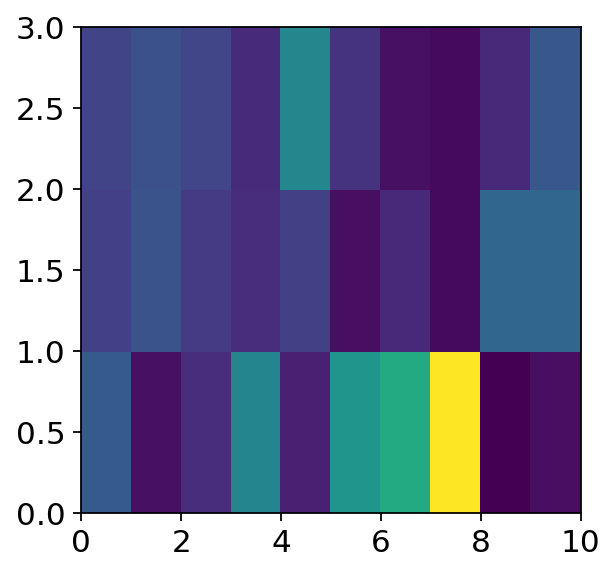

In [394]:
plt.pcolormesh(scdpf.pmeans['hW'])

In [395]:
ranks = scdpf.get_rankings()

In [396]:
ranks[2][:10], ranks[4][:10]

(['FTH1',
  'TALDO1',
  'GPX1',
  'SERPINB1',
  'C20orf27',
  'JUND',
  'SDHB',
  'H2AFY',
  'TMEM205',
  'HBP1'],
 ['CD74',
  'HLA-DRA',
  'HLA-DPB1',
  'CD79A',
  'TCL1A',
  'IGLL5',
  'HVCN1',
  'IRF8',
  'LINC00926',
  'LAT2'])

In [397]:
# enrichments = scdpf.get_enrichments()

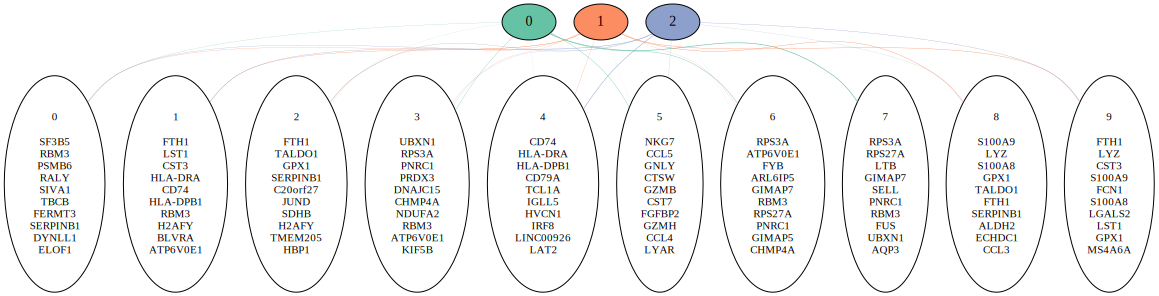

In [398]:
scdpf.get_graph(enrichments=None, ard_filter=[.001, .001])